# JAMFitter

In [1]:
import os,sys
import threading
import copy
import numpy as np
import pandas as pd
import time
from mpmath import fp

from scipy.integrate import quad,fixed_quad
from scipy.special import jv, zeta
from scipy import interpolate
from scipy.optimize import leastsq,least_squares

import types
from timeit import time

#--matplotlib
import matplotlib
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rc('text',usetex=True)
import pylab as py
import matplotlib.gridspec as gridspec


#--jupyter widgets
from IPython import display
import ipywidgets as widgets

#--other
import subprocess
import shutil

#--jit
from numba import jit

<ipython-input-1-3983b5dc8ab9>:19: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-w8ue55v2 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
path = '/work/JAM/barryp/JAM/fitpack2testing/'
sys.path.insert(0, path)
os.environ['FITPACK']=path
#os.environ["PATH"]='/work/JAM/apps/bin:'+os.environ["PATH"]

In [3]:
os.environ['FITPACK']='/work/JAM/barryp/JAM/fitpack2testing/'
os.environ['LHAPDF_DATA_PATH']='/work/JAM/apps/lhapdf_tables/'
os.environ['LHAPDF_DATA_PATH']='/work/JAM/barryp/misc/:'+os.environ['LHAPDF_DATA_PATH']
os.environ['LHAPDF_DATA_PATH']='/work/JAM/apps/lhapdf_tables/more/more1:'+os.environ['LHAPDF_DATA_PATH']
os.environ["PATH"]='/work/JAM/apps/bin:'+os.environ["PATH"]

In [4]:
from tools.tools import load, save, checkdir,lprint,id_generator,gen_code,send_command
from tools.config import conf, load_config, load_config2
from qcdlib.aux import AUX
from qcdlib.eweak import EWEAK
from qcdlib.alphaS import ALPHAS
from fitlib.resman import RESMAN
from fitlib.parman import PARMAN
from analysis.corelib import core

## Tools

In [5]:
def jobstat(stop=True,t=30):
    while 1:
        print(send_command('squeue -u barryp'))
        display.clear_output(wait=True)
        if stop==True: break
        time.sleep(t)

#@jit(nopython=True)
def set_active_params(active_list):
    for _ in active_list:
        for param in conf['params'][_]:
            if conf['params'][_][param]['min']!=None:
                conf['params'][_][param]['fixed'] = False

#@jit(nopython=True)
def get_samples(wdir,active_list=[]):
    resman=RESMAN(parallel=False,datasets=False)
    parman=resman.parman
    
    samples=[]
    mcrun=os.listdir('%s/mcrun'%wdir)
    cnt=0
    for fname in mcrun:
        cnt+=1
        lprint('retrieving samples %d/%d'%(cnt,len(mcrun)))
        data=np.load('%s/mcrun/%s'%(wdir,fname),allow_pickle=True).item(0)
        conf['params']  =data['params']
        conf['datasets']=data['datasets']
        set_active_params(active_list)
        
        parman.get_ordered_free_params()
        samples.append(parman.par)
    checkdir('%s/data'%wdir)
    np.save('%s/data/samples'%wdir,np.array(samples))
    return np.array(samples)


## Calculations

In [6]:
# @jit(nopython=True)
def gen_red_chi2(wdir,samples,inputfile,active_list=[]):
    load_config2(inputfile)
    set_active_params(active_list)
    conf['bootstrap'] = False
    resman=RESMAN(parallel=True,datasets=True) #--attempting parallel=True
    parman=resman.parman
    red_chi2=[]
    cnt=0
    sampleflag=[]
    for i in range(len(samples)):
        par=samples[i]
        cnt+=1
        lprint('computing red chi2 %d/%d'%(cnt,len(samples)))
        res,rres,nres=resman.get_residuals(par)
        if np.sum(res**2)/res.size>10:
            sampleflag.append(0)
            continue
        else: sampleflag.append(1)
        red_chi2.append(np.sum(res**2)/res.size)
    checkdir('%s/mcrun_good'%wdir)
    for i in range(len(os.listdir('%s/mcrun'%wdir))):
        if sampleflag[i]==1:
            cmd=['cp']
            cmd.append('%s/mcrun/%s'%(wdir,os.listdir('%s/mcrun'%wdir)[i]))
            cmd.append('%s/mcrun_good/%s'%(wdir,os.listdir('%s/mcrun'%wdir)[i]))
            p=subprocess.Popen(cmd,stdout=subprocess.PIPE)        
    shutil.rmtree('%s/mcrun'%wdir)
    cmd=['mv']
    cmd.append('%s/mcrun_good'%wdir)
    cmd.append('%s/mcrun'%wdir)
    p=subprocess.Popen(cmd,stdout=subprocess.PIPE)
    
    checkdir('%s/data'%wdir)
    np.save('%s/data/red_chi2'%wdir,np.array(red_chi2))
    return np.array(red_chi2)

# @jit(nopython=True)
def gen_mean_chi2(wdir,data,samples):
    
    chi2={}
    
    for k in data:
        chi2[k]={}
        for kk in data[k]:
            chi2[k][kk]={}
            p=data[k][kk]
            if k=='pITD':
                #--get chi2
                c=[x for x in p if 'cov' in x]
                cov=np.zeros((len(c),len(c)))
                for i in range(len(c)):
                    cov[i]=p[c[i]]
                covinv=np.linalg.inv(cov)
                vect=p['value']-np.mean(p['prediction-rep'],axis=0)
                chi2[k][kk]['chi2']=np.einsum('i,ij,j',vect,covinv,vect)
                chi2[k][kk]['npts']=len(p['value'])
            else:
                res=(p['value']-np.mean(p['prediction-rep'],axis=0))/p['alpha']
                chi2[k][kk]['npts']=len(res)
                chi2[k][kk]['chi2']=np.sum(res**2)
                
    chi2['total']={}
    chi2['total']['chi2']=0
    chi2['total']['npts']=0
    for k in chi2:
        if k=='total': continue
        for kk in chi2[k]:
            chi2['total']['chi2']+=chi2[k][kk]['chi2']
            chi2['total']['npts']+=chi2[k][kk]['npts']
            
    print(len(samples[0]))
    chi2['dof']=chi2['total']['npts']-len(samples[0])
    
    checkdir('%s/data'%wdir)
    np.save('%s/data/chi2'%wdir,chi2)
    return chi2
    
# @jit(nopython=True)
def gen_predictions(wdir,samples,inputfile,active_list=[]):
    load_config2(inputfile)
    set_active_params(active_list)
    conf['bootstrap'] = False
    resman=RESMAN(parallel=True,datasets=True)
    parman=resman.parman

    obsres={}
    if 'dy-pion' in conf['datasets']: obsres['dy-pion']=resman.dy_pion_res
    if 'ln' in conf['datasets']: obsres['ln']=resman.ln_res
    if 'pITD' in conf['datasets']: obsres['pITD']=resman.pITD_res
    
    data={}
    
    for _ in obsres:
        tabs=copy.copy(obsres[_].tabs)
        for idx in tabs:
            tabs[idx]['prediction-rep']=[]
        data[_]=tabs
    
    cnt=0
    for par in samples:
        cnt+=1
        lprint('progress: %i/%i'%(cnt,len(samples)))
        res,rres,nres=resman.get_residuals(par,initial=True)

        for _ in obsres:
            for idx in data[_]:
                prediction=copy.copy(obsres[_].tabs[idx]['prediction'])
                data[_][idx]['prediction-rep'].append(prediction)
                
    checkdir('%s/data'%wdir)
    np.save('%s/data/predictions'%wdir,data)
    return data

def gen_predictions_nosys(wdir,samples,inputfile,active_list=[]):
    load_config2(inputfile)
    set_active_params(active_list)
    conf['bootstrap'] = False
    resman=RESMAN(parallel=True,datasets=True)
    parman=resman.parman
    
    samplesmod=[]
    for i in range(len(samples)):
        samplesmod.append([])
        for j in range(len(parman.order)):
            if parman.order[j][1]=='lat-sys': continue
            samplesmod[i].append(samples[i][j])
    samplesmod=np.array(samplesmod)
    
    for k in conf['params']:
        for kk in conf['params'][k]:
            if k=='lat-sys':
                conf['params'][k][kk]={'value':0.0,'min':-0.1,'max':0.1,'fixed':True}
                
    resman=RESMAN(parallel=True,datasets=True)
    parman=resman.parman
    
    obsres={}
#     if 'dy-pion' in conf['datasets']: obsres['dy-pion']=resman.dy_pion_res
#     if 'ln' in conf['datasets']: obsres['ln']=resman.ln_res
    if 'pITD' in conf['datasets']: obsres['pITD']=resman.pITD_res
    
    data={}
    
    for _ in obsres:
        tabs=copy.copy(obsres[_].tabs)
        for idx in tabs:
            tabs[idx]['prediction-rep']=[]
        data[_]=tabs
    
    cnt=0
    for par in samplesmod:
        cnt+=1
        lprint('progress: %i/%i'%(cnt,len(samplesmod)))
        res,rres,nres=resman.get_residuals(par,initial=True)

        for _ in obsres:
            for idx in data[_]:
                prediction=copy.copy(obsres[_].tabs[idx]['prediction'])
                data[_][idx]['prediction-rep'].append(prediction)
                
    checkdir('%s/data'%wdir)
    np.save('%s/data/predictions_nosys'%wdir,data)
    return data


def gen_pdf(wdir,samples,inputfile,active_list=[],Q2=None):
    load_config2(inputfile)
    set_active_params(active_list)
    conf['bootstrap'] = False
    resman=RESMAN(parallel=False,datasets=False)
    parman=resman.parman
    
    pdf=conf['pdf-pion']

    if Q2==None: Q2=conf['Q20']
    X=10**np.linspace(-3,-1,200)
    X=np.append(X,np.linspace(0.1,1,200))
    XF={}

    cnt=0
    for par in samples:
        cnt+=1
        lprint('progress: %i/%i'%(cnt,len(samples)))

        parman.set_new_params(par)

        for flav in ['valence','sea','g']:
            if flav not in XF: XF[flav]=[]

            if flav=='valence':
                func=lambda x: pdf.get_xF(x,Q2,'ub')-pdf.get_xF(x,Q2,'u')
            elif flav=='sea':
                func=lambda x: pdf.get_xF(x,Q2,'u')
            else:
                func=lambda x: pdf.get_xF(x,Q2,'g')

            XF[flav].append([func(x) for x in X])

    data={'X':X,'Q2':Q2,'XF':XF}
    
    checkdir('%s/data'%wdir)
    np.save('%s/data/pdf'%(wdir),data)
    return data


## Extra functions to create

-PDFs

-ratio of uncertainties of PDFs to central values with no lattice and without systematics

## book keeping class

In [7]:
class BOOK:
    
    def __init__(self,wdir,input_file,active_list=[]):
        self.input_file=input_file
        self.active_list=active_list
        checkdir('%s/data'%wdir)
        
#         self.samples=get_samples(wdir,self.active_list)
        if 'red_chi2.npy' not in os.listdir('%s/data'%wdir): 
            self.setup(wdir)
        else:
            self.red_chi2=np.load('%s/data/red_chi2.npy'%wdir)
            
        self.samples=np.load('%s/data/samples.npy'%wdir)
        if 'predictions.npy' in os.listdir('%s/data'%wdir):
            self.predictions=np.load('%s/data/predictions.npy'%wdir,allow_pickle=True).item(0)
        else: 
            self.predictions=gen_predictions(wdir,self.samples,self.input_file,self.active_list)
            
        if 'chi2.npy' not in os.listdir('%s/data'%wdir):
            self.chi2=gen_mean_chi2(wdir,self.predictions,self.samples)
        else:
            self.chi2=np.load('%s/data/chi2.npy'%wdir,allow_pickle=True).item(0)
    
        if 'predictions_nosys.npy' in os.listdir('%s/data'%wdir):
            self.predictions_nosys=np.load('%s/data/predictions_nosys.npy'%wdir,allow_pickle=True).item(0)
        else:
            self.predictions_nosys=gen_predictions_nosys(wdir,self.samples,self.input_file,self.active_list)
            
        if 'pdf.npy' in os.listdir('%s/data'%wdir):
            self.pdfs=np.load('%s/data/pdf.npy'%wdir,allow_pickle=True).item(0)
        else:
            self.pdfs=gen_pdf(wdir,self.samples,self.input_file,self.active_list)

    def setup(self,wdir):

        self.samples=get_samples(wdir,self.active_list)
        
        self.red_chi2=gen_red_chi2(wdir,self.samples,self.input_file,self.active_list)
        time.sleep(3)
        self.samples=get_samples(wdir,self.active_list)


## Plotting routines

In [8]:
def plot_chi2(wdir,data):
    nrows,ncols=1,1
    fig = py.figure(figsize=(ncols*7,nrows*5))
    ax=py.subplot(nrows,ncols,1)
    ax.hist(data,bins=20);
    ax.tick_params(axis='both', which='both', labelsize=15,direction='in')
    ax.set_xlabel(r'$\chi^2_{\rm red}$',size=30);
    ax.set_ylabel(r'$\rm yield$',size=30);
    
    py.tight_layout()
    checkdir('%s/gallery'%wdir)
    py.savefig('%s/gallery/chi2.png'%wdir)
    
       
def plot_data_over_theory(wdir,data,expt):
    
    tab=copy.deepcopy(data['pITD'][expt])
    zunique=np.unique(tab['ZoA'])
    nrows=1
    ncols=len(zunique)
    py.figure(figsize=(4*ncols,4*nrows))
    
    cnt=0
    p=tab
    #--get chi2
    c=[x for x in p if 'cov' in x]
    cov=np.zeros((len(c),len(c)))
    for i in range(len(c)):
        cov[i]=p[c[i]]
    covinv=np.linalg.inv(cov)
    vect=p['value']-np.mean(p['prediction-rep'],axis=0)
    chi2=np.einsum('i,ij,j',vect,covinv,vect)
    print(chi2)
    npts=len(vect)

    for i in range(len(zunique)):
        cnt+=1
        theory=np.mean(p['prediction-rep'],axis=0)
        dtheory=np.std(p['prediction-rep'],axis=0)
        nu=[]
        vals=[]
        alphas=[]
        meanthy=[]
        stdthy=[]
        for j in range(len(p['N'])):
            if p['ZoA'][j]==zunique[i]:
                nu.append(p['nu'][j])
                vals.append(p['value'][j])
                alphas.append(p['alpha'][j])
                meanthy.append(theory[j])
                stdthy.append(dtheory[j])
        nu=np.array(nu)
        vals=np.array(vals)
        alphas=np.array(alphas)
        meanthy=np.array(meanthy)
        stdthy=np.array(stdthy)
        if len(nu)==0: continue
        ax=py.subplot(nrows,ncols,cnt)
        ax.errorbar(nu,vals/meanthy,yerr=alphas/meanthy,fmt='.',label=r'$z=%i a$'%zunique[i])
        ax.axhline(y=1,color='k',alpha=0.5)
        ax.fill_between(nu,1-stdthy/meanthy,1+stdthy/meanthy,alpha=0.3,fc='y')
        ax.set_ylim(0.99,1.01)
        ax.set_yticks([0.99,0.995,1,1.005,1.01])
        if i==0:
            ax.set_yticklabels([r'$0.99$','',r'$1$','',r'$1.01$'])
        else: ax.set_yticklabels([])
        ax.tick_params(direction='in',which='both',labelsize=20)
        if i==0: ax.set_ylabel(r'${\rm data~/~theory}$',size=30)
        ax.legend(fontsize=25,loc='upper left')#,frameon=False)
        ax.set_xlabel(r'$\nu$',size=30)
        if i==0: ax.text(0.1,0.3,r'$L=%i$'%p['L'][0],transform=ax.transAxes,size=30)
        if i==1: ax.text(0.1,0.3,r'$\chi^2/{\rm npts}=%.3f$'%(chi2/npts),transform=ax.transAxes,size=30)
    py.tight_layout()
    checkdir('%s/gallery/'%wdir)
    py.savefig('%s/gallery/data_over_theory_pITD-%s.png'%(wdir,expt))
    py.savefig('%s/gallery/data_over_theory_pITD-%s.pdf'%(wdir,expt))

def plot_data_and_theory(wdir,data,expt):
    
    tab=copy.deepcopy(data['pITD'][expt])
    zunique=np.unique(tab['ZoA'])
    nrows=1
    ncols=len(zunique)
    py.figure(figsize=(4*ncols,4*nrows))
    
    cnt=0
    p=tab
    #--get chi2
    c=[x for x in p if 'cov' in x]
    cov=np.zeros((len(c),len(c)))
    for i in range(len(c)):
        cov[i]=p[c[i]]
    covinv=np.linalg.inv(cov)
    vect=p['value']-np.mean(p['prediction-rep'],axis=0)
    chi2=np.einsum('i,ij,j',vect,covinv,vect)
    print(chi2)
    npts=len(vect)

    for i in range(len(zunique)):
        cnt+=1
        theory=np.mean(p['prediction-rep'],axis=0)
        dtheory=np.std(p['prediction-rep'],axis=0)
        nu=[]
        vals=[]
        alphas=[]
        meanthy=[]
        stdthy=[]
        for j in range(len(p['N'])):
            if p['ZoA'][j]==zunique[i]:
                nu.append(p['nu'][j])
                vals.append(p['value'][j])
                alphas.append(p['alpha'][j])
                meanthy.append(theory[j])
                stdthy.append(dtheory[j])
        nu=np.array(nu)
        vals=np.array(vals)
        alphas=np.array(alphas)
        meanthy=np.array(meanthy)
        stdthy=np.array(stdthy)
        if len(nu)==0: continue
        ax=py.subplot(nrows,ncols,cnt)
        ax.errorbar(nu,vals,yerr=alphas,fmt='.',label=r'$z=%i a$'%zunique[i])
        ax.fill_between(nu,meanthy-stdthy,meanthy+stdthy,alpha=0.3,fc='y')
        ax.tick_params(direction='in',which='both',labelsize=20)
        ax.legend(fontsize=25,loc='upper left')#,frameon=False)
        ax.set_xlabel(r'$\nu$',size=30)
        if i==0: ax.text(0.1,0.3,r'$L=%i$'%p['L'][0],transform=ax.transAxes,size=30)
        if i==1: ax.text(0.1,0.3,r'$\chi^2/{\rm npts}=%.3f$'%(chi2/npts),transform=ax.transAxes,size=30)
    py.tight_layout()
    checkdir('%s/gallery/'%wdir)
    py.savefig('%s/gallery/data_and_theory_pITD-%s.png'%(wdir,expt))
    py.savefig('%s/gallery/data_and_theory_pITD-%s.pdf'%(wdir,expt))

def plot_data_and_theory_sysnosys(wdir,data,datanosys,expt):
    
    tab=copy.deepcopy(data['pITD'][expt])
    zunique=np.unique(tab['ZoA'])
    nrows=1
    ncols=len(zunique)
    py.figure(figsize=(6*ncols,6*nrows))
    
    cnt=0
    p=tab
    pnosys=copy.deepcopy(datanosys['pITD'][expt])

    for i in range(len(zunique)):
        cnt+=1
        theorytot=np.mean(p['prediction-rep'],axis=0)
        dtheorytot=np.std(p['prediction-rep'],axis=0)
        theorynosys=np.mean(pnosys['prediction-rep'],axis=0)
        dtheorynosys=np.std(pnosys['prediction-rep'],axis=0)
        onlysys=[]
        for j in range(len(p['prediction-rep'])):
            onlysys.append(p['prediction-rep'][j]-pnosys['prediction-rep'][j])
        theoryonlysys=np.mean(onlysys,axis=0)
        dtheoryonlysys=np.std(onlysys,axis=0)
        nu=[]
        vals=[]
        alphas=[]
        meanthy=[]
        stdthy=[]
        meanthynosys=[]
        stdthynosys=[]
        meanthyonlysys=[]
        stdthyonlysys=[]
        for j in range(len(p['N'])):
            if p['ZoA'][j]==zunique[i]:
                nu.append(p['nu'][j])
                vals.append(p['value'][j])
                alphas.append(p['alpha'][j])
                meanthy.append(theorytot[j])
                stdthy.append(dtheorytot[j])
                meanthynosys.append(theorynosys[j])
                stdthynosys.append(dtheorynosys[j])
                meanthyonlysys.append(theoryonlysys[j])
                stdthyonlysys.append(dtheoryonlysys[j])
                
        nu=np.array(nu)
        vals=np.array(vals)
        alphas=np.array(alphas)
        meanthy=np.array(meanthy)
        stdthy=np.array(stdthy)
        meanthynosys=np.array(meanthynosys)
        stdthynosys=np.array(stdthynosys)
        meanthyonlysys=np.array(meanthyonlysys)
        stdthyonlysys=np.array(stdthyonlysys)
        
        if len(nu)==0: continue
        ax=py.subplot(nrows,ncols,cnt)
        ax.errorbar(nu,vals,yerr=alphas,fmt='.',label=r'$z=%i a$'%zunique[i])
        ax.fill_between(nu,meanthy-stdthy,meanthy+stdthy,alpha=0.3,fc='r',label=r'$\rm full$')
        ax.fill_between(nu,meanthynosys-stdthynosys,meanthynosys+stdthynosys,alpha=0.3,fc='g',label=r'$\rm no~sys$')
        ax.fill_between(nu,meanthyonlysys-stdthyonlysys,meanthyonlysys+stdthyonlysys,alpha=0.3,fc='c',label=r'$\rm only~sys$')
        
        ax.tick_params(direction='in',which='both',labelsize=20)
        ax.legend(fontsize=25,loc='center left')#,frameon=False)
        ax.set_xlabel(r'$\nu$',size=30)
    py.tight_layout()
    checkdir('%s/gallery/'%wdir)
    py.savefig('%s/gallery/data_and_theory_pITD_sysbreakdown-%s.png'%(wdir,expt))
    py.savefig('%s/gallery/data_and_theory_pITD_sysbreakdown-%s.pdf'%(wdir,expt))


def plot_correlations(wdir,samples,inputfile,active_list=[]):
    load_config2(inputfile)
    set_active_params(active_list)
    conf['bootstrap'] = False
    resman=RESMAN(parallel=True,datasets=True)
    parman=resman.parman

    parmean=np.mean(samples,axis=0)
    
    cov=np.zeros((len(parmean),len(parmean)))
    for i in range(len(parmean)):
        for j in range(len(parmean)):
            for k in range(len(samples)):
                cov[i][j]+=(samples[k][i]-parmean[i])*(samples[k][j]-parmean[j])
    cov/=(len(samples)-1)
    
    correlation=np.zeros(cov.shape)
    for i in range(len(correlation)):
        for j in range(len(correlation[i])):
            correlation[i][j]=cov[i][j]/(cov[i][i]*cov[j][j])**0.5
            
    order=parman.order
    
    nrows,ncols=1,1
    py.figure(figsize=(10*ncols,10*nrows))
    ax=py.subplot(nrows,ncols,1)

    labs=[]
    for i in range(len(order)):
        if order[i][1]=='pdf-pion':
            parname=order[i][2][-1]
            if 'ubv' in order[i][2]:
                labs.append(r'$%s_{v}$'%parname)
            elif 'u' in order[i][2]:
                labs.append(r'$%s_{s}$'%parname)
            elif 'g' in order[i][2]:
                labs.append(r'$%s_{g}$'%parname)
        elif 'lambda'==order[i][2]:
            labs.append(r'$\Lambda$')
        elif 'lat-sys'==order[i][1]:
            parname=order[i][2][0]
            power=order[i][2][1]
            labs.append(r'$%s_{%s}$'%(parname,power))
        elif order[i][0]==2:
            expt=order[i][2]
            labs.append(r'$N_{%i}$'%expt)
            
            
    lines=[]
    normflag=False
    for i in range(len(order)-1):
        if order[i][0]==1:
            if str(order[i][2]).split(' ')[0]!=str(order[i+1][2]).split(' ')[0]:
                if order[i][1]!='lat-sys':
                    lines.append(True)
                else: lines.append(False)
            else: lines.append(False)
        elif order[i][0]==2 and normflag==False:
            lines[-1]=True
            lines.append(False)
            normflag=True
        else: lines.append(False)
    lines.append(False)
            
    im=ax.imshow(correlation)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=20) 
    im.set_clim(-1,1)
    ax.set_xticks(range(len(order)))
    ax.set_xticklabels(labs,size=20)
    ax.set_yticks(range(len(order)))
    ax.set_yticklabels(labs,size=20)
    ax.tick_params(direction='out',which='both',axis='both',labelsize=20)
    for i in range(len(lines)):
        if lines[i]==True:
            ax.axhline(y=i+0.5,c='k')
            ax.axvline(x=i+0.5,c='k')

    
    py.tight_layout()            
    checkdir('%s/gallery'%wdir)
    py.savefig('%s/gallery/correlations.png'%wdir)
    py.savefig('%s/gallery/correlations.pdf'%wdir)

    
def plot_histograms(wdir,samples,inputfile,active_list=[]):
    load_config2(inputfile)
    set_active_params(active_list)
    conf['bootstrap'] = False
    resman=RESMAN(parallel=True,datasets=True)
    parman=resman.parman

    parmean=np.mean(samples,axis=0)
    order=parman.order
    
    for i in range(len(order)):
        lprint('progress: %i/%i'%(i+1,len(order)))
        nrows,ncols=1,1
        py.figure(figsize=(6*ncols,5*nrows))
        ax=py.subplot(nrows,ncols,1)

        if order[i][1]=='pdf-pion':
            parname=order[i][2][-1]
            if 'ubv' in order[i][2]:
                title=r'$\bar{u}_{v,%s}$'%parname
            else:
                parton=order[i][2][0]
                title=r'$%s_{%s}$'%(parton,parname)
        elif 'lambda'==order[i][2]:
            title=r'$\Lambda$'
        elif 'lat-sys'==order[i][1]:
            parname=order[i][2][0]
            power=order[i][2][1]
            title=r'$%s_{%s}$'%(parname,power)
        elif order[i][0]==2:
            expt=order[i][2]
            title=r'$N_{%i}$'%expt

        par=[]
        for j in range(len(samples)):
            par.append(samples[j][i])

        par=np.array(par)

        ax.hist(par,bins=25)
        ax.axvline(x=parmean[i],ls=':')
        ax.tick_params(direction='in',which='both',labelsize=20)
        ax.set_title(title,size=30)

        py.tight_layout()
        checkdir('%s/gallery/histogram'%wdir)
        py.savefig('%s/gallery/histogram/%s.png'%(wdir,order[i][2]))
        py.savefig('%s/gallery/histogram/%s.pdf'%(wdir,order[i][2]))


## MCRUN -- Loop over

In [48]:
#--create main and template

main="""
import sys,os
import numpy as np
path = "/work/JAM/barryp/JAM/fitpack2testing/"
sys.path.insert(0, path)
os.environ['FITPACK']=path

from tools.config import conf,load_config2
from tools.tools  import load, save, checkdir
from fitlib.maxlike import MAXLIKE

conf['verbose']   = 100
conf['bootstrap'] = True
conf['ftol']      = 1e-8


load_config2("analysis-LCS/%s/%s/input.npy"%(sys.argv[3],sys.argv[2]))
data=load("/work/JAM/barryp/JAM/analysis-LCS/NLOpy3/msr-inspected/%s"%sys.argv[1]) #--for prior distributions
#--parameters
for k in conf['params']:
    for kk in conf['params'][k]:
        for i in range(len(data['order'][10])):
            if data['order'][10][i][1]=='pdf' and data['order'][10][i][2]==kk:
                conf['params'][k][kk]['value']=data['params'][10][i]
        for i in range(len(data['order'][15])):
            if data['order'][15][i][0]==1:
                if data['order'][15][i][1]==k and data['order'][15][i][2]==kk:
                    conf['params'][k][kk]['value']=data['params'][15][i]
                    print(data['order'][15][i],data['params'][15][i])
#--normalizations
for k in conf['datasets']:
    for kk in conf['datasets'][k]['norm']:
        for i in range(len(data['order'][15])):
            if data['order'][15][i][0]==2:
                if data['order'][15][i][1]==k and data['order'][15][i][2]==kk:
                    conf['datasets'][k]['norm'][kk]['value']=data['params'][15][i]

ml=MAXLIKE()
ml.run2()

data={"params":conf["params"],"datasets":conf["datasets"]}
checkdir("analysis-LCS/%s/%s/mcrun"%(sys.argv[3],sys.argv[2]))
np.save("analysis-LCS/%s/%s/mcrun/%s"%(sys.argv[3],sys.argv[2],sys.argv[1]),data)
"""

template="""#!/bin/csh
#SBATCH --account=jam
#SBATCH --nodes 1
#SBATCH --partition=production
#SBATCH --cpus-per-task 5
#SBATCH --mem=2G
#SBATCH --time=10:00:00
#SBATCH --constraint=general
#SBATCH --job-name="<observable> <pathname>"
#SBATCH --output=/w/jam-sciwork18/barryp/Notebooks-Jupyterhub/Lattice/analysis-LCS/<observable>/<pathname>/out/<fname>.out
#SBATCH --error=/w/jam-sciwork18/barryp/Notebooks-Jupyterhub/Lattice/analysis-LCS/<observable>/<pathname>/out/<fname>.err
/home/barryp/.conda/envs/pb3/bin/python main.py <fname> <pathname> <observable>
"""

In [56]:
for B in [0,1,2,3]:
    for P in [0,1,2,3]:
        for F in [0,1,2,3]:
            name=''
            if B==0: B1fixed,B2fixed=True,True
            if B==1:
                B1fixed,B2fixed=False,True
                name+='B1'
            if B==2:
                B1fixed,B2fixed=True,False
                name+='B2'
            if B==3:
                B1fixed,B2fixed=False,False
                name+='B1B2'
            if P==0: P1fixed,P2fixed=True,True
            if P==1:
                P1fixed,P2fixed=False,True
                name+='P1'
            if P==2:
                P1fixed,P2fixed=True,False
                name+='P2'
            if P==3:
                P1fixed,P2fixed=False,False
                name+='P1P2'
            if F==0: F1fixed,F2fixed=True,True
            if F==1:
                F1fixed,F2fixed=False,True
                name+='F1'
            if F==2:
                F1fixed,F2fixed=True,False
                name+='F2'
            if F==3:
                F1fixed,F2fixed=False,False
                name+='F1F2'
                
            if B==0 and P==0 and F==0: continue
            if P==1 and B==0 and F==0: continue
            if B==1 and P==0 and F==0: continue
                
            if B!=3 or P!=3 or F!=0: continue
            print(B,P,F)
            
            name+='-fromDYLN-p1'
            
            #--fitting setups
            conf['bootstrap']=True
            conf['flat par']=True
            conf['ftol']=1e-8

            #--setups for DGLAP
            conf['dglap mode']='truncated'
            conf['alphaSmode']='backward'
            conf['order'] = 'NLO'
            conf['Q20']   = 1.27**2

            #--setup for LN
            conf['ln mode']='model'
            conf['SPLFUNC model']='IMF exp'
            
            #--setup for LCS
            #--0: mu**2=(2GeV)**2, 1: mu**2=(4GeV)**2, 2: mu**2=conf['Q20'], type(conf['LCS scale'])!=int: mu=conf['LCS scale']*mc
            conf['LCS scale']=0


            #--grids

            conf['path2idistab']   = '%s/grids/grids-idis/distab/'%os.environ['FITPACK']

            #--datasets

            conf['datasets']={}

            ##--LN
            conf['datasets']['ln']={}
            conf['datasets']['ln']['filters']=[]
            conf['datasets']['ln']['filters'].append("y<0.2") 
            conf['datasets']['ln']['xlsx']={}
            conf['datasets']['ln']['xlsx'][1000]='ln/expdata/1000.xlsx' 
            conf['datasets']['ln']['xlsx'][2000]='ln/expdata/2000.xlsx' 
            conf['datasets']['ln']['norm']={}
            conf['datasets']['ln']['norm'][1000]={'value':    1.170,'fixed':False,'min':0.5,'max':1.5}
            conf['datasets']['ln']['norm'][2000]={'value':    0.964,'fixed':False,'min':0.5,'max':1.5}

            ##--DY-pion
            conf['datasets']['dy-pion']={}
            conf['datasets']['dy-pion']['filters']=[]
            conf['datasets']['dy-pion']['filters'].append("Q2>4.16**2")
            #conf['datasets']['dy-pion']['filters'].append("Q2<8.34**2")
            conf['datasets']['dy-pion']['filters'].append("Q2<59.0")
            conf['datasets']['dy-pion']['filters'].append("xF>0") 
            conf['datasets']['dy-pion']['filters'].append("xF<0.9") 
            conf['datasets']['dy-pion']['xlsx']={}
            conf['datasets']['dy-pion']['xlsx'][10001]='dy-pion/expdata/10001.xlsx'
            conf['datasets']['dy-pion']['xlsx'][10002]='dy-pion/expdata/10002.xlsx'
            conf['datasets']['dy-pion']['xlsx'][10003]='dy-pion/expdata/10003.xlsx'
            conf['datasets']['dy-pion']['norm']={}
            conf['datasets']['dy-pion']['norm'][10001]={'value':    1.047,'fixed':False,'min':   0.5,'max':    1.5}
            conf['datasets']['dy-pion']['norm'][10002]={'value':    0.867,'fixed':False,'min':   0.5,'max':    1.5}
            conf['datasets']['dy-pion']['norm'][10003]={'value':    0.805,'fixed':False,'min':   0.5,'max':    1.5}
            
            ##--pITD lattice
            conf['datasets']['pITD']={}
            conf['datasets']['pITD']['filters']=[]
            conf['datasets']['pITD']['filters'].append('ZoA<9')
            conf['datasets']['pITD']['filters'].append('ZoA>2')
            conf['datasets']['pITD']['filters'].append('p==1')
            conf['datasets']['pITD']['xlsx']={}
            conf['datasets']['pITD']['xlsx'][1001]='pITD-pion/expdata/1001.xlsx' #--Real part, large lattice volume
            conf['datasets']['pITD']['xlsx'][1002]='pITD-pion/expdata/1002.xlsx' #--Real part, small lattice volume
            conf['datasets']['pITD']['norm']={}

            #--parameters
            conf['params']={}

            #--pdf parameters

            conf['pdf parametrization']=2
            conf['qpdf on']=False
            conf['params']['pdf']={}

            conf['params']['pdf']['g1 N']    ={'value':    3.87592e-01, 'min':  None, 'max':  None, 'fixed': True }
            conf['params']['pdf']['g1 a']    ={'value':   -6.23068169e-01, 'min':  -1.9, 'max':     1, 'fixed': True}
            conf['params']['pdf']['g1 b']    ={'value':    9.25741583e+00, 'min':     0, 'max':    10, 'fixed': True}

            conf['params']['pdf']['uv1 N']   ={'value':    3.47549e-01, 'min':  None, 'max':  None, 'fixed': True }
            conf['params']['pdf']['uv1 a']   ={'value':   -1.21835956e-01, 'min':  -0.5, 'max':     1, 'fixed': True}
            conf['params']['pdf']['uv1 b']   ={'value':    3.20766744e+00, 'min':     0, 'max':    10, 'fixed': True}

            conf['params']['pdf']['dv1 N']   ={'value':    1.52089e-01, 'min':  None, 'max':  None, 'fixed': True }
            conf['params']['pdf']['dv1 a']   ={'value':   -2.39874967e-01, 'min':  -0.5, 'max':     1, 'fixed': True}
            conf['params']['pdf']['dv1 b']   ={'value':    3.83902620e+00, 'min':     0, 'max':    10, 'fixed': True}

            conf['params']['pdf']['db1 N']   ={'value':    3.67609928e-02, 'min':     0, 'max':     1, 'fixed': True}
            conf['params']['pdf']['db1 a']   ={'value':   -8.41360631e-01, 'min':    -1, 'max':     1, 'fixed': True}
            conf['params']['pdf']['db1 b']   ={'value':    5.31285539e+00, 'min':     0, 'max':    10, 'fixed': True}

            conf['params']['pdf']['ub1 N']   ={'value':    1.95464789e-02, 'min':     0, 'max':     1, 'fixed': True}
            conf['params']['pdf']['ub1 a']   ={'value':    -9.93659187e-01, 'min':    -1, 'max':     1, 'fixed': True}
            conf['params']['pdf']['ub1 b']   ={'value':    8.38905814e+00, 'min':     0, 'max':    10, 'fixed': True}

            conf['params']['pdf']['s1 N']    ={'value':    0.00000e+00, 'min':     0, 'max':     1, 'fixed': True }
            conf['params']['pdf']['s1 a']    ={'value':   1.34706224e-01, 'min':  -0.5, 'max':     1, 'fixed': True}
            conf['params']['pdf']['s1 b']    ={'value':    6.00759596e+00, 'min':     0, 'max':    10, 'fixed': True}

            conf['params']['pdf']['sb1 N']   ={'value':    7.46109845e-07, 'min':     0, 'max':     1, 'fixed': True}
            conf['params']['pdf']['sb1 a']   ={'value':   3.83495317e-01, 'min':  -0.5, 'max':     1, 'fixed': True}
            conf['params']['pdf']['sb1 b']   ={'value':    4.61209808e+00, 'min':     0, 'max':    10, 'fixed': True}

            conf['params']['pdf']['sea1 N']  ={'value':    5.71081196e-03, 'min':     0, 'max':     1, 'fixed': True}
            conf['params']['pdf']['sea1 a']  ={'value':   -1.36329697e+00, 'min':  -1.9, 'max':    -1, 'fixed': True}
            conf['params']['pdf']['sea1 b']  ={'value':    4.74721050e+00, 'min':     0, 'max':    10, 'fixed': True}

            conf['params']['pdf']['sea2 N']  ={'value':    2.08640e-02, 'min':     0, 'max':     1, 'fixed': 'sea1 N'}
            conf['params']['pdf']['sea2 a']  ={'value':   -1.500000000, 'min':  -1.9, 'max':    -1, 'fixed': 'sea1 a'}
            conf['params']['pdf']['sea2 b']  ={'value':    1.00000e+01, 'min':     0, 'max':    10, 'fixed': 'sea1 b'}

            #--pdf-pion parameters
            conf['params']['pdf-pion']={}
            conf['pdf-pion parametrization']='sea'

            conf['params']['pdf-pion']['g1 N']   ={'value':   5.03895e-01, 'min':  0.0 , 'max':     1,'fixed':False}
            conf['params']['pdf-pion']['g1 a']   ={'value':    -9.048e-01, 'min': -1.9 , 'max':    10,'fixed':False}
            conf['params']['pdf-pion']['g1 b']   ={'value':   7.68225e+00, 'min':  0.0 , 'max':   100,'fixed':False}

            conf['params']['pdf-pion']['ubv1 N'] ={'value':     1.175e+00, 'min':  0.0 , 'max':    10,'fixed':True}
            conf['params']['pdf-pion']['ubv1 a'] ={'value':    -2.914e-01, 'min': -0.9 , 'max':     0,'fixed':False}
            conf['params']['pdf-pion']['ubv1 b'] ={'value':     9.202e-01, 'min':  0.0 , 'max':    10,'fixed':False}
            conf['params']['pdf-pion']['ubv1 c'] ={'value':             0, 'min': -1.0 , 'max':   100,'fixed':True}
            conf['params']['pdf-pion']['ubv1 d'] ={'value':             2, 'min':  1.0 , 'max':    10,'fixed':True}

            conf['params']['pdf-pion']['dv1 N']  ={'value':     1.175e+00, 'min':  0.0 , 'max':    10,'fixed':'ubv1 N'}
            conf['params']['pdf-pion']['dv1 a']  ={'value':     2.914e-01, 'min': -1.8 , 'max':    10,'fixed':'ubv1 a'}
            conf['params']['pdf-pion']['dv1 b']  ={'value':     9.202e-01, 'min':  0.0 , 'max':    10,'fixed':'ubv1 b'}
            conf['params']['pdf-pion']['dv1 c'] ={'value':              0, 'min': -1.0 , 'max':   100,'fixed':'ubv1 c'}
            conf['params']['pdf-pion']['dv1 d'] ={'value':              2, 'min':  1.0 , 'max':    10,'fixed':'ubv1 d'}

            conf['params']['pdf-pion']['u1 N']   ={'value':             0, 'min':  0.0 , 'max':    10,'fixed':True}
            conf['params']['pdf-pion']['u1 a']   ={'value':    -7.228e-01, 'min': -1.9 , 'max':    10,'fixed':False}
            conf['params']['pdf-pion']['u1 b']   ={'value':    5.5854e+00, 'min':  0.0 , 'max':   100,'fixed':False}

            conf['params']['pdf-pion']['db1 N']  ={'value':    2.6720e-02, 'min':  0.0 , 'max':    10,'fixed':'u1 N'}
            conf['params']['pdf-pion']['db1 a']  ={'value':    -7.228e-01, 'min': -1.8 , 'max':    10,'fixed':'u1 a'}
            conf['params']['pdf-pion']['db1 b']  ={'value':    5.5854e+00, 'min':  0.0 , 'max':   100,'fixed':'u1 b'}

            conf['params']['pdf-pion']['s1 N']   ={'value':    2.6720e-02, 'min':  0.0 , 'max':    10,'fixed':'u1 N'}
            conf['params']['pdf-pion']['s1 a']   ={'value':    -7.228e-01, 'min': -1.8 , 'max':    10,'fixed':'u1 a'}
            conf['params']['pdf-pion']['s1 b']   ={'value':    5.5854e+00, 'min':  0.0 , 'max':   100,'fixed':'u1 b'}

            conf['params']['pdf-pion']['sb1 N']  ={'value':    2.6720e-02, 'min':  0.0 , 'max':    10,'fixed':'u1 N'}
            conf['params']['pdf-pion']['sb1 a']  ={'value':    -7.228e-01, 'min': -1.8 , 'max':    10,'fixed':'u1 a'}
            conf['params']['pdf-pion']['sb1 b']  ={'value':    5.5854e+00, 'min':  0.0 , 'max':   100,'fixed':'u1 b'}

            #--LN parameter
            conf['params']['p->pi,n']={}
            conf['ln parametrization']=0
            conf['params']['p->pi,n']['lambda']={'value': 1.31e+00, 'min': 0.0, 'max': 2.0, 'fixed': False}

            #--Lattice systematics corrections parameters
            conf['params']['lat-sys']={}
            #--pITD systematics
            conf['params']['lat-sys']['alpha-pITD']  ={'value':-0.5, 'min':  -1, 'max':  1, 'fixed': True} #--jacobi polynomial parameter
            conf['params']['lat-sys']['beta-pITD']   ={'value': 3.0, 'min':  -1, 'max': 10, 'fixed': True} #--jacobi polynomial parameter
            conf['params']['lat-sys']['b1-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': B1fixed, 'zero':True} #--higher-twist effect
            conf['params']['lat-sys']['p1-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': P1fixed, 'zero':True} #--lattice spacing effect
            conf['params']['lat-sys']['r1-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': True, 'zero':True} #--lattice spacing effect
            conf['params']['lat-sys']['m1-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': True, 'zero':True} #--pion mass effect
            conf['params']['lat-sys']['f1-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': F1fixed, 'zero':True} #--finite volume effect
            conf['params']['lat-sys']['b2-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': B2fixed, 'zero':True} #--higher-twist effect
            conf['params']['lat-sys']['p2-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': P2fixed, 'zero':True} #--lattice spacing effect
            conf['params']['lat-sys']['r2-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': True, 'zero':True} #--lattice spacing effect
            conf['params']['lat-sys']['m2-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': True, 'zero':True} #--pion mass effect
            conf['params']['lat-sys']['f2-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': F2fixed, 'zero':True} #--finite volume effect

            print(name)
            checkdir('analysis-LCS/pITD/%s'%name)
#             if 'input.npy' not in os.listdir('analysis-LCS/pITD/%s'%name):
#                 np.save('analysis-LCS/pITD/%s/input.npy'%name,conf)
            np.save('analysis-LCS/pITD/%s/input.npy'%name,conf)

            #--Run fit

            gen_code(main,'main.py')
            # checkdir('analysis-LCS/pITD/%s'%name)
            checkdir('analysis-LCS/pITD/%s/out/'%name)
            fnames=os.listdir('/work/JAM/barryp/JAM/analysis-LCS/NLOpy3/msr-inspected/') #--prior distributions
            for fname in fnames[:]:
                checkdir('analysis-LCS/pITD/%s/mcrun'%name)
                if '%s.npy'%fname in os.listdir('analysis-LCS/pITD/%s/mcrun'%name): continue
                toslurm=template.replace('<pathname>',name)
                toslurm=toslurm.replace('<fname>',fname)
                toslurm=toslurm.replace('<observable>','pITD')
                gen_code(toslurm,'toslurm.sh')
                print(_,send_command('sbatch toslurm.sh'))
                display.clear_output(wait=True)
                #break

 Submitted batch job 41332197



In [77]:
jobstat(stop=True)
# send_command('scancel 39807327')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          41318556   jupyter jupyterh   barryp  R    6:44:52      1 farm180247
          41332193 productio pITD B1B   barryp  R      32:17      1 farm180102
          41332194 productio pITD B1B   barryp  R      32:17      1 farm180132
          41331248 productio pITD B1B   barryp  R      35:39      1 farm19106
          41332196 productio pITD B1B   barryp  R      35:39      1 farm19105
          41332197 productio pITD B1B   barryp  R      35:39      1 farm19106
          41332150 productio pITD B1B   barryp  R      35:40      1 farm180204
          41332153 productio pITD B1B   barryp  R      35:40      1 farm180213
          41332154 productio pITD B1B   barryp  R      35:40      1 farm180134
          41332155 productio pITD B1B   barryp  R      35:40      1 farm180134
          41332157 productio pITD B1B   barryp  R      35:40      1 farm180221
          41332158 productio pITD B1B   barryp  R

In [25]:
# Bfixed=True
# Pfixed=False
# Ffixed=True

# name='P1'

# #--fitting setups
# conf['bootstrap']=True
# conf['flat par']=True
# conf['ftol']=1e-8

# #--setups for DGLAP
# conf['dglap mode']='truncated'
# conf['alphaSmode']='backward'
# conf['order'] = 'NLO'
# conf['Q20']   = 1.27**2

# #--setup for LN
# conf['ln mode']='model'
# conf['SPLFUNC model']='IMF exp'

# #--setup for LCS
# #--0: mu**2=(2GeV)**2, 1: mu**2=(4GeV)**2, 2: mu**2=conf['Q20'], type(conf['LCS scale'])!=int: mu=conf['LCS scale']*mc
# conf['LCS scale']=0


# #--grids

# conf['path2idistab']   = '%s/grids/grids-idis/distab/'%os.environ['FITPACK']

# #--datasets

# conf['datasets']={}

# ##--LN
# conf['datasets']['ln']={}
# conf['datasets']['ln']['filters']=[]
# conf['datasets']['ln']['filters'].append("y<0.2") 
# conf['datasets']['ln']['xlsx']={}
# conf['datasets']['ln']['xlsx'][1000]='ln/expdata/1000.xlsx' 
# conf['datasets']['ln']['xlsx'][2000]='ln/expdata/2000.xlsx' 
# conf['datasets']['ln']['norm']={}
# conf['datasets']['ln']['norm'][1000]={'value':    1.170,'fixed':False,'min':0.5,'max':1.5}
# conf['datasets']['ln']['norm'][2000]={'value':    0.964,'fixed':False,'min':0.5,'max':1.5}

# ##--DY-pion
# conf['datasets']['dy-pion']={}
# conf['datasets']['dy-pion']['filters']=[]
# conf['datasets']['dy-pion']['filters'].append("Q2>4.16**2")
# #conf['datasets']['dy-pion']['filters'].append("Q2<8.34**2")
# conf['datasets']['dy-pion']['filters'].append("Q2<59.0")
# conf['datasets']['dy-pion']['filters'].append("xF>0") 
# conf['datasets']['dy-pion']['filters'].append("xF<0.9") 
# conf['datasets']['dy-pion']['xlsx']={}
# conf['datasets']['dy-pion']['xlsx'][10001]='dy-pion/expdata/10001.xlsx'
# conf['datasets']['dy-pion']['xlsx'][10002]='dy-pion/expdata/10002.xlsx'
# conf['datasets']['dy-pion']['xlsx'][10003]='dy-pion/expdata/10003.xlsx'
# conf['datasets']['dy-pion']['norm']={}
# conf['datasets']['dy-pion']['norm'][10001]={'value':    1.047,'fixed':False,'min':   0.5,'max':    1.5}
# conf['datasets']['dy-pion']['norm'][10002]={'value':    0.867,'fixed':False,'min':   0.5,'max':    1.5}
# conf['datasets']['dy-pion']['norm'][10003]={'value':    0.805,'fixed':False,'min':   0.5,'max':    1.5}

# ##--pITD lattice
# conf['datasets']['pITD']={}
# conf['datasets']['pITD']['filters']=[]
# conf['datasets']['pITD']['filters'].append('ZoA<9')
# conf['datasets']['pITD']['filters'].append('ZoA>2')
# conf['datasets']['pITD']['xlsx']={}
# conf['datasets']['pITD']['xlsx'][1001]='pITD-pion/expdata/1001.xlsx' #--Real part, large lattice volume
# conf['datasets']['pITD']['xlsx'][1002]='pITD-pion/expdata/1002.xlsx' #--Real part, small lattice volume
# conf['datasets']['pITD']['norm']={}

# #--parameters
# conf['params']={}

# #--pdf parameters

# conf['pdf parametrization']=2
# conf['qpdf on']=False
# conf['params']['pdf']={}

# conf['params']['pdf']['g1 N']    ={'value':    3.87592e-01, 'min':  None, 'max':  None, 'fixed': True }
# conf['params']['pdf']['g1 a']    ={'value':   -6.23068169e-01, 'min':  -1.9, 'max':     1, 'fixed': True}
# conf['params']['pdf']['g1 b']    ={'value':    9.25741583e+00, 'min':     0, 'max':    10, 'fixed': True}

# conf['params']['pdf']['uv1 N']   ={'value':    3.47549e-01, 'min':  None, 'max':  None, 'fixed': True }
# conf['params']['pdf']['uv1 a']   ={'value':   -1.21835956e-01, 'min':  -0.5, 'max':     1, 'fixed': True}
# conf['params']['pdf']['uv1 b']   ={'value':    3.20766744e+00, 'min':     0, 'max':    10, 'fixed': True}

# conf['params']['pdf']['dv1 N']   ={'value':    1.52089e-01, 'min':  None, 'max':  None, 'fixed': True }
# conf['params']['pdf']['dv1 a']   ={'value':   -2.39874967e-01, 'min':  -0.5, 'max':     1, 'fixed': True}
# conf['params']['pdf']['dv1 b']   ={'value':    3.83902620e+00, 'min':     0, 'max':    10, 'fixed': True}

# conf['params']['pdf']['db1 N']   ={'value':    3.67609928e-02, 'min':     0, 'max':     1, 'fixed': True}
# conf['params']['pdf']['db1 a']   ={'value':   -8.41360631e-01, 'min':    -1, 'max':     1, 'fixed': True}
# conf['params']['pdf']['db1 b']   ={'value':    5.31285539e+00, 'min':     0, 'max':    10, 'fixed': True}

# conf['params']['pdf']['ub1 N']   ={'value':    1.95464789e-02, 'min':     0, 'max':     1, 'fixed': True}
# conf['params']['pdf']['ub1 a']   ={'value':    -9.93659187e-01, 'min':    -1, 'max':     1, 'fixed': True}
# conf['params']['pdf']['ub1 b']   ={'value':    8.38905814e+00, 'min':     0, 'max':    10, 'fixed': True}

# conf['params']['pdf']['s1 N']    ={'value':    0.00000e+00, 'min':     0, 'max':     1, 'fixed': True }
# conf['params']['pdf']['s1 a']    ={'value':   1.34706224e-01, 'min':  -0.5, 'max':     1, 'fixed': True}
# conf['params']['pdf']['s1 b']    ={'value':    6.00759596e+00, 'min':     0, 'max':    10, 'fixed': True}

# conf['params']['pdf']['sb1 N']   ={'value':    7.46109845e-07, 'min':     0, 'max':     1, 'fixed': True}
# conf['params']['pdf']['sb1 a']   ={'value':   3.83495317e-01, 'min':  -0.5, 'max':     1, 'fixed': True}
# conf['params']['pdf']['sb1 b']   ={'value':    4.61209808e+00, 'min':     0, 'max':    10, 'fixed': True}

# conf['params']['pdf']['sea1 N']  ={'value':    5.71081196e-03, 'min':     0, 'max':     1, 'fixed': True}
# conf['params']['pdf']['sea1 a']  ={'value':   -1.36329697e+00, 'min':  -1.9, 'max':    -1, 'fixed': True}
# conf['params']['pdf']['sea1 b']  ={'value':    4.74721050e+00, 'min':     0, 'max':    10, 'fixed': True}

# conf['params']['pdf']['sea2 N']  ={'value':    2.08640e-02, 'min':     0, 'max':     1, 'fixed': 'sea1 N'}
# conf['params']['pdf']['sea2 a']  ={'value':   -1.500000000, 'min':  -1.9, 'max':    -1, 'fixed': 'sea1 a'}
# conf['params']['pdf']['sea2 b']  ={'value':    1.00000e+01, 'min':     0, 'max':    10, 'fixed': 'sea1 b'}

# #--pdf-pion parameters
# conf['params']['pdf-pion']={}
# conf['pdf-pion parametrization']='sea'

# conf['params']['pdf-pion']['g1 N']   ={'value':   5.03895e-01, 'min':  0.0 , 'max':     1,'fixed':False}
# conf['params']['pdf-pion']['g1 a']   ={'value':    -9.048e-01, 'min': -1.9 , 'max':    10,'fixed':False}
# conf['params']['pdf-pion']['g1 b']   ={'value':   7.68225e+00, 'min':  0.0 , 'max':   100,'fixed':False}

# conf['params']['pdf-pion']['ubv1 N'] ={'value':     1.175e+00, 'min':  0.0 , 'max':    10,'fixed':True}
# conf['params']['pdf-pion']['ubv1 a'] ={'value':    -2.914e-01, 'min': -0.9 , 'max':     0,'fixed':False}
# conf['params']['pdf-pion']['ubv1 b'] ={'value':     9.202e-01, 'min':  0.0 , 'max':    10,'fixed':False}
# conf['params']['pdf-pion']['ubv1 c'] ={'value':             0, 'min': -1.0 , 'max':   100,'fixed':True}
# conf['params']['pdf-pion']['ubv1 d'] ={'value':             2, 'min':  1.0 , 'max':    10,'fixed':True}

# conf['params']['pdf-pion']['dv1 N']  ={'value':     1.175e+00, 'min':  0.0 , 'max':    10,'fixed':'ubv1 N'}
# conf['params']['pdf-pion']['dv1 a']  ={'value':     2.914e-01, 'min': -1.8 , 'max':    10,'fixed':'ubv1 a'}
# conf['params']['pdf-pion']['dv1 b']  ={'value':     9.202e-01, 'min':  0.0 , 'max':    10,'fixed':'ubv1 b'}
# conf['params']['pdf-pion']['dv1 c'] ={'value':              0, 'min': -1.0 , 'max':   100,'fixed':'ubv1 c'}
# conf['params']['pdf-pion']['dv1 d'] ={'value':              2, 'min':  1.0 , 'max':    10,'fixed':'ubv1 d'}

# conf['params']['pdf-pion']['u1 N']   ={'value':             0, 'min':  0.0 , 'max':    10,'fixed':True}
# conf['params']['pdf-pion']['u1 a']   ={'value':    -7.228e-01, 'min': -1.9 , 'max':    10,'fixed':False}
# conf['params']['pdf-pion']['u1 b']   ={'value':    5.5854e+00, 'min':  0.0 , 'max':   100,'fixed':False}

# conf['params']['pdf-pion']['db1 N']  ={'value':    2.6720e-02, 'min':  0.0 , 'max':    10,'fixed':'u1 N'}
# conf['params']['pdf-pion']['db1 a']  ={'value':    -7.228e-01, 'min': -1.8 , 'max':    10,'fixed':'u1 a'}
# conf['params']['pdf-pion']['db1 b']  ={'value':    5.5854e+00, 'min':  0.0 , 'max':   100,'fixed':'u1 b'}

# conf['params']['pdf-pion']['s1 N']   ={'value':    2.6720e-02, 'min':  0.0 , 'max':    10,'fixed':'u1 N'}
# conf['params']['pdf-pion']['s1 a']   ={'value':    -7.228e-01, 'min': -1.8 , 'max':    10,'fixed':'u1 a'}
# conf['params']['pdf-pion']['s1 b']   ={'value':    5.5854e+00, 'min':  0.0 , 'max':   100,'fixed':'u1 b'}

# conf['params']['pdf-pion']['sb1 N']  ={'value':    2.6720e-02, 'min':  0.0 , 'max':    10,'fixed':'u1 N'}
# conf['params']['pdf-pion']['sb1 a']  ={'value':    -7.228e-01, 'min': -1.8 , 'max':    10,'fixed':'u1 a'}
# conf['params']['pdf-pion']['sb1 b']  ={'value':    5.5854e+00, 'min':  0.0 , 'max':   100,'fixed':'u1 b'}

# #--LN parameter
# conf['params']['p->pi,n']={}
# conf['ln parametrization']=0
# conf['params']['p->pi,n']['lambda']={'value': 1.31e+00, 'min': 0.0, 'max': 2.0, 'fixed': False}

# #--Lattice systematics corrections parameters
# conf['params']['lat-sys']={}
# #--pITD systematics
# conf['params']['lat-sys']['alpha-pITD']  ={'value':-0.5, 'min':  -1, 'max':  1, 'fixed': True} #--jacobi polynomial parameter
# conf['params']['lat-sys']['beta-pITD']   ={'value': 3.0, 'min':  -1, 'max': 10, 'fixed': True} #--jacobi polynomial parameter
# conf['params']['lat-sys']['b1-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': Bfixed, 'zero':True} #--higher-twist effect
# conf['params']['lat-sys']['p1-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': Pfixed, 'zero':True} #--lattice spacing effect
# conf['params']['lat-sys']['r1-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': True, 'zero':True} #--lattice spacing effect
# conf['params']['lat-sys']['m1-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': True, 'zero':True} #--pion mass effect
# conf['params']['lat-sys']['f1-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': Ffixed, 'zero':True} #--finite volume effect
# conf['params']['lat-sys']['b2-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': True, 'zero':True} #--higher-twist effect
# conf['params']['lat-sys']['p2-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': True, 'zero':True} #--lattice spacing effect
# conf['params']['lat-sys']['r2-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': True, 'zero':True} #--lattice spacing effect
# conf['params']['lat-sys']['m2-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': True, 'zero':True} #--pion mass effect
# conf['params']['lat-sys']['f2-pITD']     ={'value': 0.0, 'min':  -1, 'max':  1, 'fixed': True, 'zero':True} #--finite volume effect

# print(name)
# checkdir('analysis-LCS/pITD/%s'%name)
# # if 'input.npy' not in os.listdir('analysis-LCS/pITD2/%s'%name):
# #     np.save('analysis-LCS/pITD2/%s/input.npy'%name,conf)
# np.save('analysis-LCS/pITD/%s/input.npy'%name,conf)

# # #--Run fit
# # main="""
# # import sys,os
# # import numpy as np
# # path = "/work/JAM/barryp/JAM/fitpack2testing/"
# # sys.path.insert(0, path)
# # os.environ['FITPACK']=path

# # from tools.config import conf,load_config2
# # from tools.tools  import load, save, checkdir
# # from fitlib.maxlike import MAXLIKE

# # conf['verbose']   = 100
# # conf['bootstrap'] = True
# # conf['ftol']      = 1e-8

# # load_config2("analysis-LCS/pITD2/%s/input.npy"%sys.argv[2])
# # data=load("/work/JAM/barryp/JAM/analysis-LCS/NLOpy3/msr-inspected/%s"%sys.argv[1]) #--for prior distributions
# # for k in conf['params']:
# #     for kk in conf['params'][k]:
# #         for i in range(len(data['order'][10])):
# #             if data['order'][10][i][1]=='pdf' and data['order'][10][i][2]==kk:
# #                 conf['params'][k][kk]['value']=data['params'][10][i]
# #         for i in range(len(data['order'][16])):
# #             if data['order'][16][i][1]=='pdf-pion' and data['order'][16][i][2]==kk:
# #                 conf['params'][k][kk]['value']=data['params'][16][i]

# # ml=MAXLIKE()
# # ml.run2(flat=True)

# # data={"params":conf["params"],"datasets":conf["datasets"]}
# # checkdir("analysis-LCS/pITD2/%s/mcrun"%sys.argv[2])
# # np.save("analysis-LCS/pITD2/%s/mcrun/%s"%(sys.argv[2],sys.argv[1]),data)
# # """

# # template="""#!/bin/csh
# # #SBATCH --account=jam
# # #SBATCH --nodes 1
# # #SBATCH --partition=production
# # #SBATCH --cpus-per-task 5
# # #SBATCH --mem=2G
# # #SBATCH --time=02:00:00
# # #SBATCH --constraint=general
# # #SBATCH --job-name="pITD2 <pathname>"
# # #SBATCH --output=/w/jam-sciwork18/barryp/Notebooks-Jupyterhub/Lattice/analysis-LCS/pITD2/<pathname>/out/<fname>.out
# # #SBATCH --error=/w/jam-sciwork18/barryp/Notebooks-Jupyterhub/Lattice/analysis-LCS/pITD2/<pathname>/out/<fname>.err
# # /home/barryp/.conda/envs/pb3/bin/python  main.py <fname> <pathname>
# # """
# gen_code(main,'main.py')
# checkdir('analysis-LCS/pITD/%s'%name)
# checkdir('analysis-LCS/pITD/%s/out/'%name)
# fnames=os.listdir('/work/JAM/barryp/JAM/analysis-LCS/NLOpy3/msr-inspected/') #--prior distributions
# for fname in fnames[:]:
#     toslurm=template.replace('<pathname>',name)
#     toslurm=toslurm.replace('<fname>',fname)
#     gen_code(toslurm,'toslurm.sh')
#     print(_,send_command('sbatch toslurm.sh'))
#     display.clear_output(wait=True)
#     #break

18.301124554592306
18.301124554592306
19.51993538920192
19.51993538920192
[[1, 'pdf-pion', 'g1 N'], [1, 'pdf-pion', 'g1 a'], [1, 'pdf-pion', 'g1 b'], [1, 'pdf-pion', 'ubv1 a'], [1, 'pdf-pion', 'ubv1 b'], [1, 'pdf-pion', 'u1 a'], [1, 'pdf-pion', 'u1 b'], [1, 'p->pi,n', 'lambda'], [1, 'lat-sys', 'b1-pITD'], [1, 'lat-sys', 'p1-pITD'], [1, 'lat-sys', 'b2-pITD'], [1, 'lat-sys', 'p2-pITD'], [2, 'ln', 1000], [2, 'ln', 2000], [2, 'dy-pion', 10001], [2, 'dy-pion', 10002], [2, 'dy-pion', 10003]]
loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading pITD data sets 1001
loading pITD data sets 1002
progress: 17/17[[1, 'pdf-pion', 'g1 N'], [1, 'pdf-pion', 'g1 a'], [1, 'pdf-pion', 'g1 b'], [1, 'pdf-pion', 'ubv1 a'], [1, 'pdf-pion', 'ubv1 b'], [1, 'pdf-pion', 'u1 a'], [1

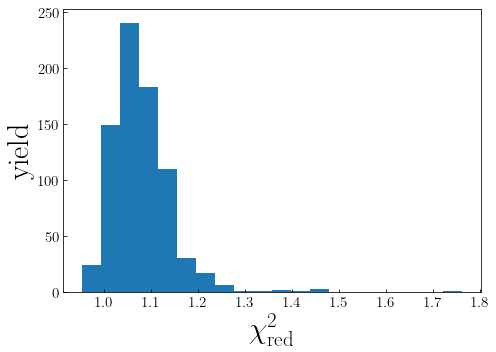

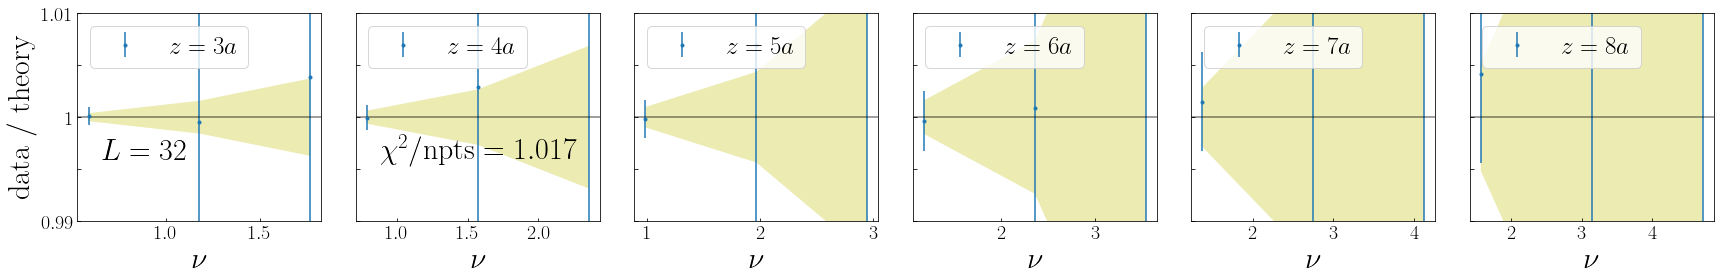

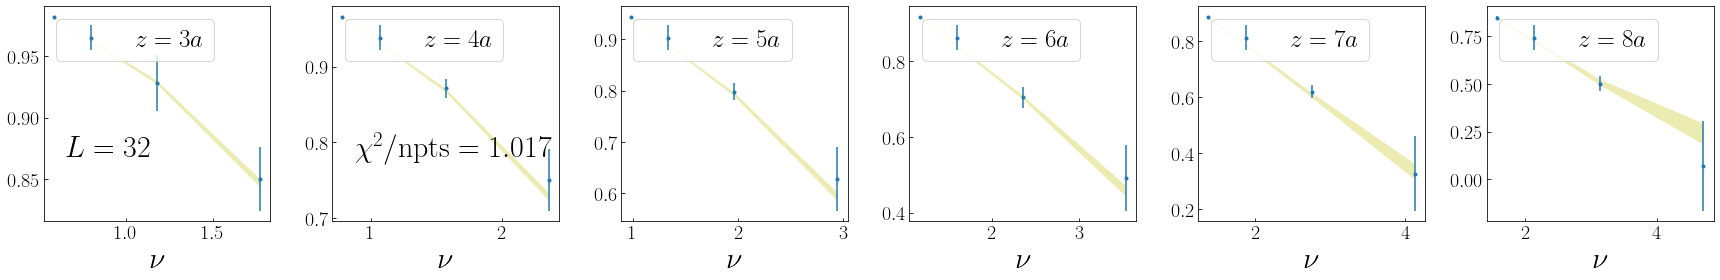

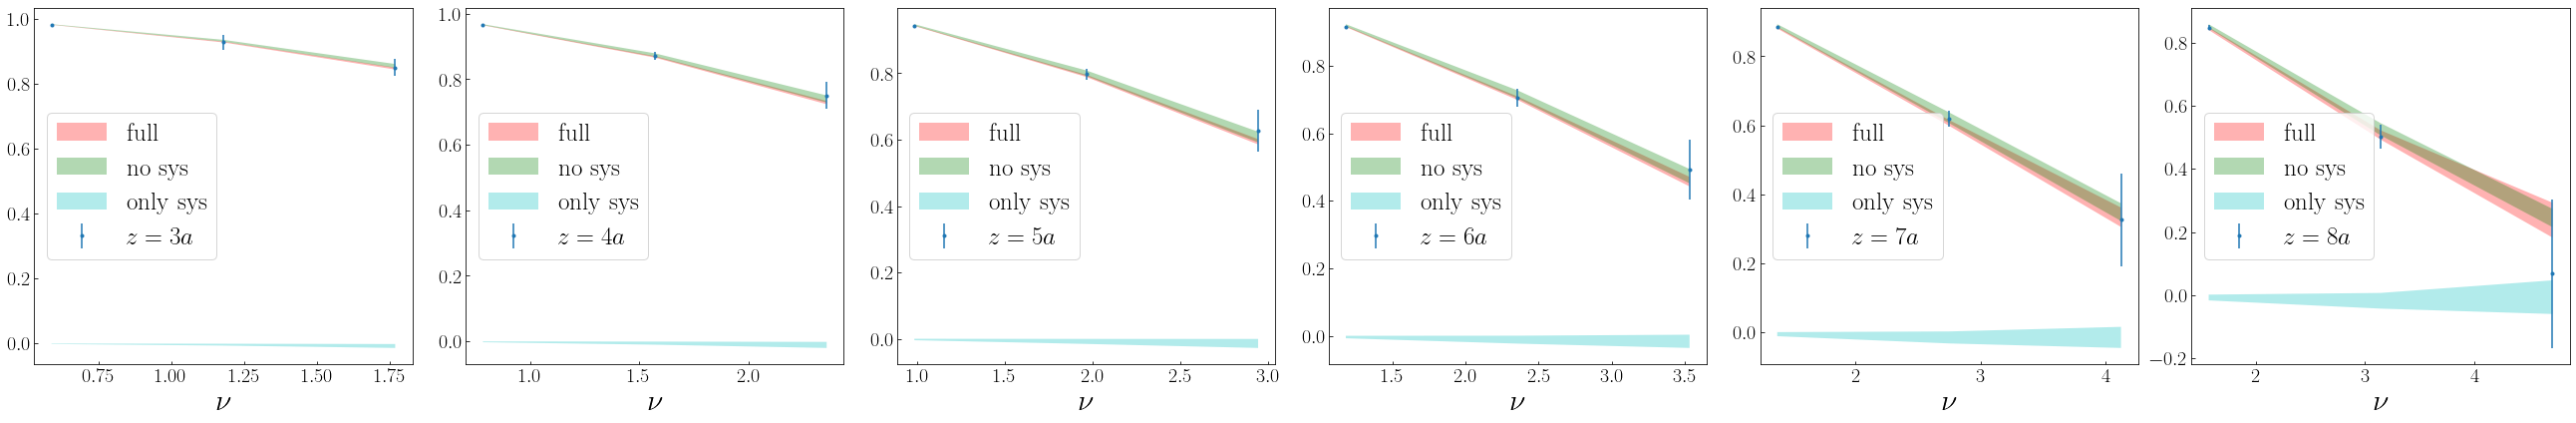

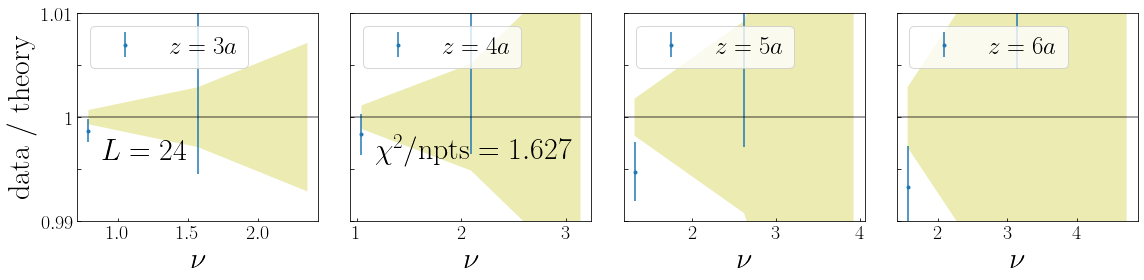

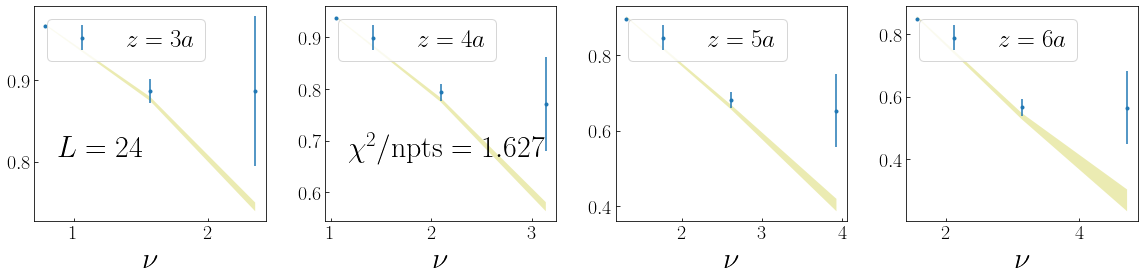

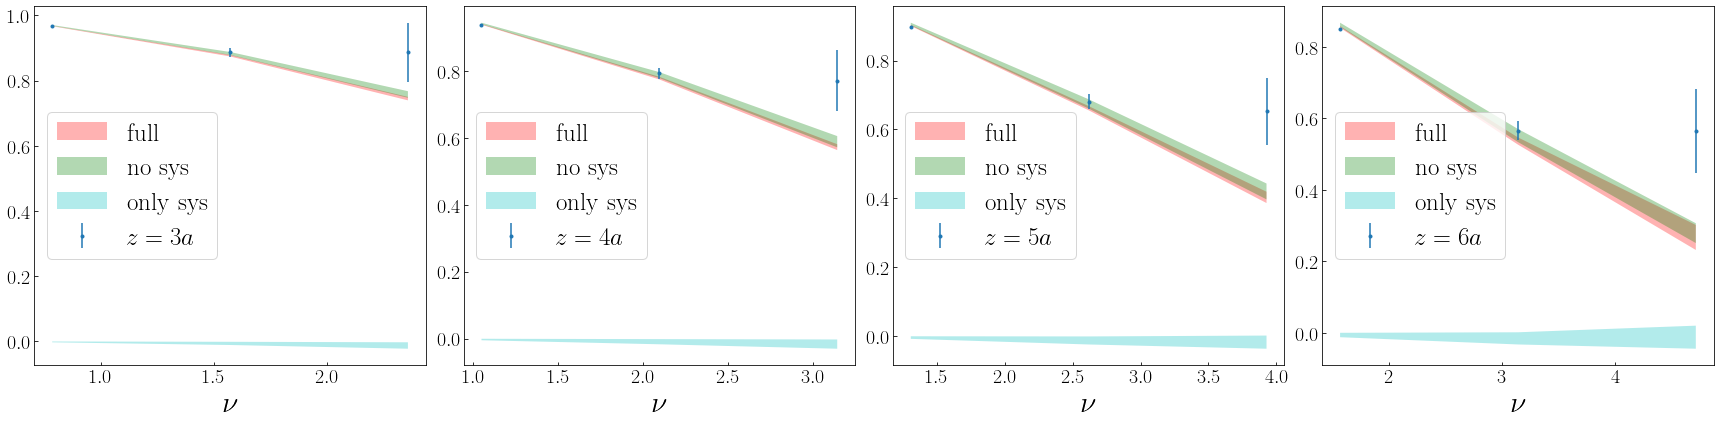

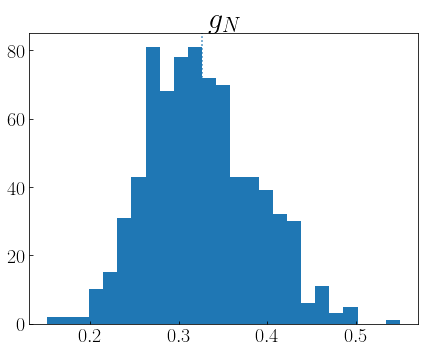

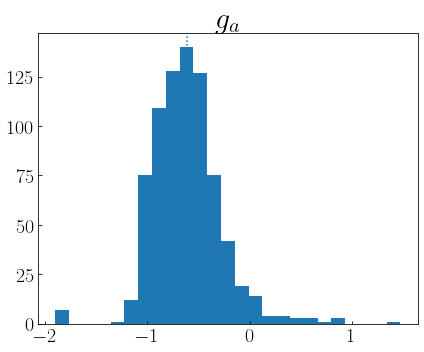

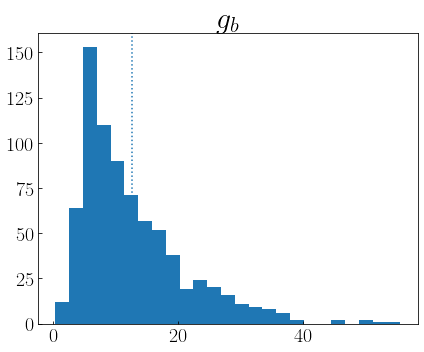

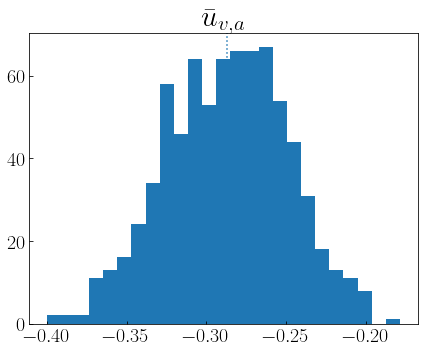

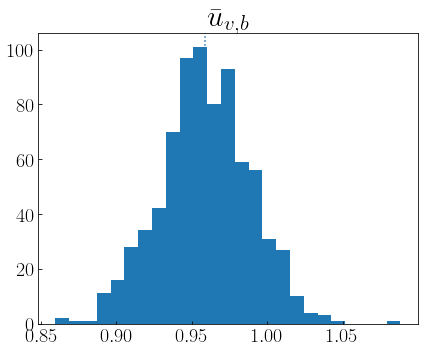

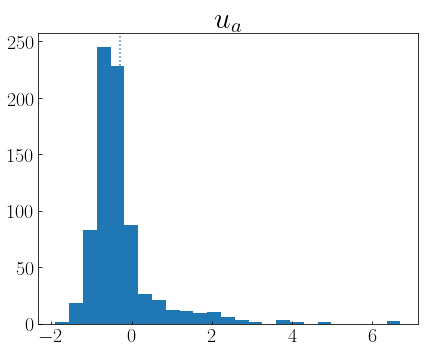

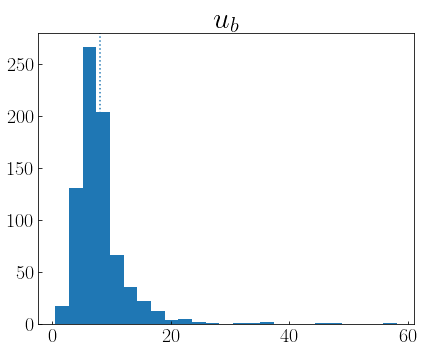

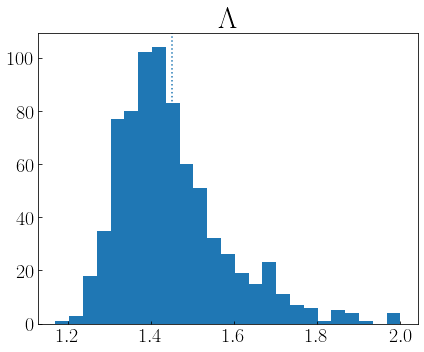

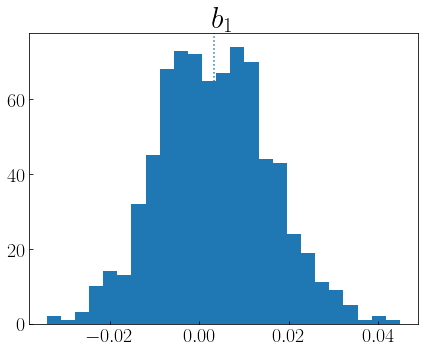

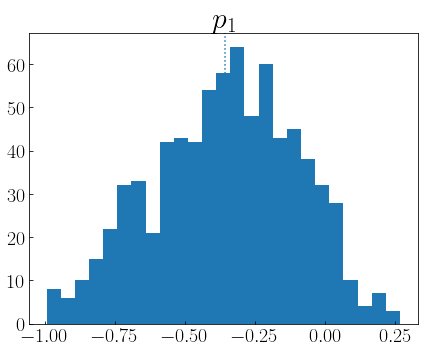

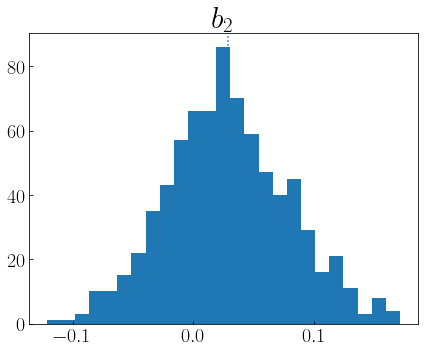

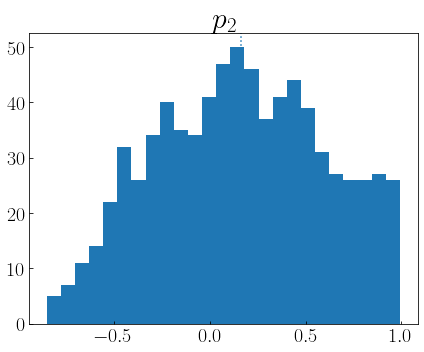

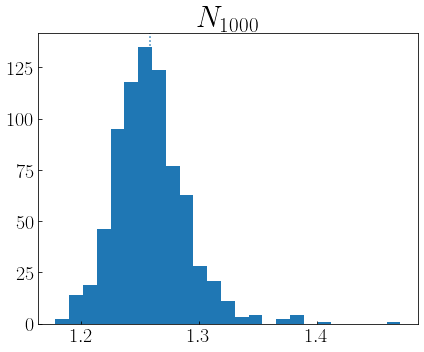

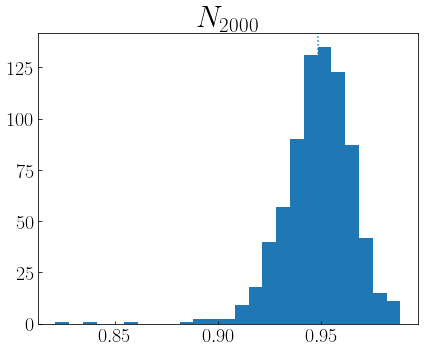

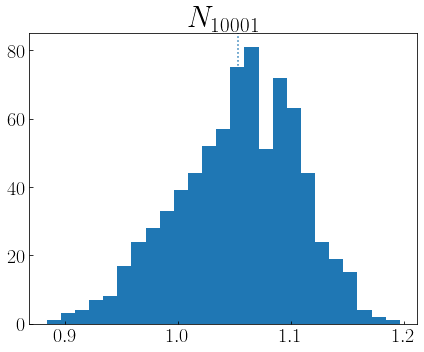

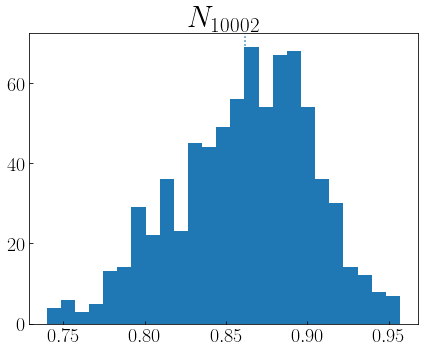

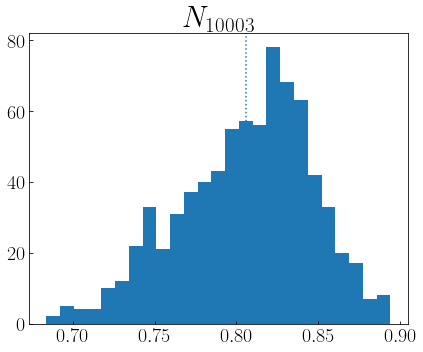

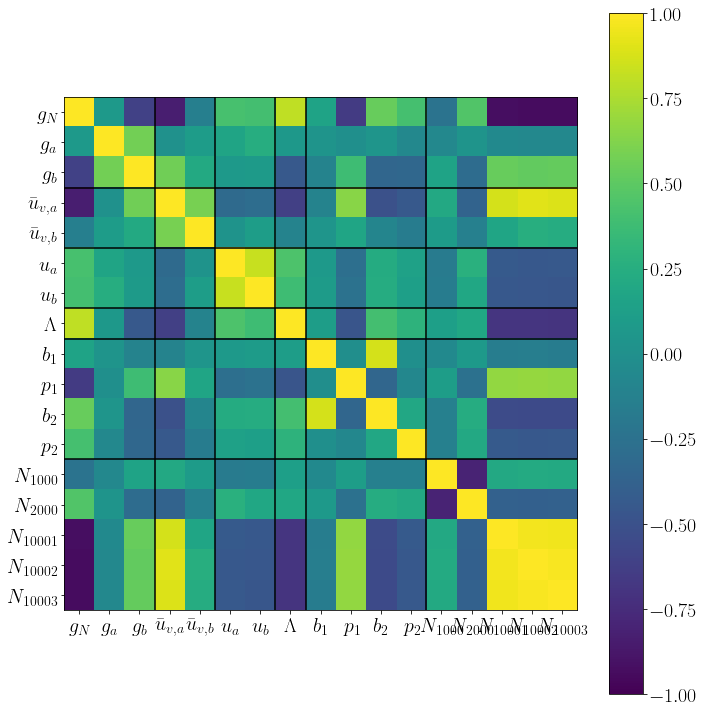

In [9]:
# %matplotlib agg
wdir='analysis-LCS/pITD/B1B2P1P2-fromDYLN//'
book1=BOOK(wdir,'%s/input.npy'%wdir)
plot_chi2(wdir,book1.red_chi2)
for k in [1001,1002]:
    plot_data_over_theory(wdir,book1.predictions,k)
    plot_data_and_theory(wdir,book1.predictions,k)
    plot_data_and_theory_sysnosys(wdir,book1.predictions,book1.predictions_nosys,k)
plot_histograms(wdir,book1.samples,'%s/input.npy'%wdir)
plot_correlations(wdir,book1.samples,'%s/input.npy'%wdir)

In [ ]:
wdir='analysis-LCS/pITD/B1B2P1P2F1F2/'
book1=BOOK(wdir,'%s/input.npy'%wdir)

In [11]:
plot_data_and_theory(wdir,book1.predictions,1001)

NameError: name 'book1' is not defined

In [16]:
for i in range(len(os.listdir('analysis-LCS/pITD'))):
    print(os.listdir('analysis-LCS/pITD/')[i])
    if 'mcrun' in os.listdir('analysis-LCS/pITD/%s'%os.listdir('analysis-LCS/pITD/')[i]):
        if 'data' in os.listdir('analysis-LCS/pITD/%s'%os.listdir('analysis-LCS/pITD/')[i]):
            print('already analyzed')
        elif len(os.listdir('analysis-LCS/pITD/%s/mcrun'%os.listdir('analysis-LCS/pITD/')[i]))==0.5*len(os.listdir('analysis-LCS/pITD/%s/out'%os.listdir('analysis-LCS/pITD/')[i])):
            print('finished running, begin analysis')
            wdir='analysis-LCS/pITD/%s'%os.listdir('analysis-LCS/pITD/')[i]
            book1=BOOK(wdir,'%s/input.npy'%wdir)
            # book1.pdfs=calc_pdfs('/work/JAM/barryp/JAM/analysis-TMD/Vlad/pp3/',book1.samples[book1.red_chi2<2])
            plot_chi2(wdir,book1.red_chi2)
        else:
            print('still running')
    else:
        print('not yet run')

P1P2
already analyzed
B2P2F1
already analyzed
B2F1F2
already analyzed
B2P1F2
already analyzed
P2F2
already analyzed
P1F1
already analyzed
B1B2P1P2F1F2
already analyzed
B1P2F1F2
already analyzed
P1
already analyzed
F2
already analyzed
P1P2F2
already analyzed
B1P1
already analyzed
B2P2
already analyzed
B2P1P2F1F2
already analyzed
B2F1
already analyzed
B1F2
already analyzed
B2P1F1
already analyzed
B2P2F2
already analyzed
F1P1
already analyzed
B2P2F1F2
already analyzed
P1F2
already analyzed
F1F2
already analyzed
P2F1
already analyzed
B2P1P2
already analyzed
P2
already analyzed
F1
already analyzed
P1F1F2
already analyzed
B2P1
already analyzed
B1P2
already analyzed
P1P2F1
already analyzed
B1F1
already analyzed
B1B2P2F1F2
already analyzed
B2F2
already analyzed
B1P1P2F2
already analyzed
B1B2F1
already analyzed
B1P1P2F1F2
already analyzed
P2F1F2
already analyzed
B1B2P1P2F1
already analyzed
B1B2P1F1F2
already analyzed
B1B2P2
already analyzed
B1P2F2
already analyzed
B2P1F1F2
already analyzed
B2P1

In [9]:
%matplotlib agg
for i in range(len(os.listdir('analysis-LCS/pITD'))):
    print(os.listdir('analysis-LCS/pITD/')[i])
    wdir='analysis-LCS/pITD/%s'%os.listdir('analysis-LCS/pITD/')[i]
    checkdir('%s/gallery'%wdir)
    book1=BOOK(wdir,'%s/input.npy'%wdir)
    plot_chi2(wdir,book1.red_chi2)
    for k in [1001,1002]:
        plot_data_over_theory(wdir,book1.predictions,k)
        plot_data_and_theory(wdir,book1.predictions,k)
        plot_data_and_theory_sysnosys(wdir,book1.predictions,book1.predictions_nosys,k)
    if 'histogram' in os.listdir('%s/gallery/'%wdir): continue
    plot_correlations(wdir,book1.samples,'%s/input.npy'%wdir)
    plot_histograms(wdir,book1.samples,'%s/input.npy'%wdir)

P1P2
19.48411134854221
19.48411134854221
21.683955585400213
21.683955585400213
B2P2F1
18.384443212644484
18.384443212644484
28.68591718162145
28.68591718162145
B2F1F2
20.215385449501444
20.215385449501444
36.894611203439666
36.894611203439666
B2P1F2
17.370773921968603
17.370773921968603
19.547063213650517
19.547063213650517
P2F2
18.44126738475321
18.44126738475321
24.19304086413439
24.19304086413439
P1F1
19.86087101362141
19.86087101362141
22.692369029027077
22.692369029027077
B1B2P1P2F1F2
18.098495128263618
18.098495128263618
19.30948792889876
19.30948792889876
B1P2F1F2
18.588805873681004
18.588805873681004
34.33678100592053
34.33678100592053
P1
19.406661991862897
19.406661991862897
21.391867824979443
21.391867824979443
F2
18.98745249424342
18.98745249424342
30.087487220925908
30.087487220925908
P1P2F2
19.812600434449045
19.812600434449045
22.117465060955283
22.117465060955283
B1P1
16.93515531051273
16.93515531051273
27.235635915992475
27.235635915992475
B2P2
17.892098434175583
17.892

In [80]:
from scipy.special import gamma,binom,factorial

class SYSTEMATICS():
    
    def __init__(self):
        self.alpha=-0.5
        self.beta=3
        self.setup()
        
    def setup(self):
        self.NU=np.linspace(0.19,4.75,40)
        self.storage01=np.array([self.get_sigma0n(1,_) for _ in self.NU])
        self.storage02=np.array([self.get_sigma0n(2,_) for _ in self.NU])

    def jacobipoly(self,n,x):
        alpha,beta=self.alpha,self.beta
        jacobi=0
        for j in range(n+1):
            omega=binom(n,j)*(-1)**j/factorial(n)*gamma(alpha+n+1)*gamma(alpha+beta+n+j+1)/gamma(alpha+beta+n+1)/gamma(alpha+j+1)
            jacobi+=omega*x**j
        return jacobi
    
    def get_sigma0n(self,n,nu):
        alpha,beta=self.alpha,self.beta
        integrand=lambda x: np.cos(nu*x)*x**(alpha)*(1-x)**beta*self.jacobipoly(n,x)
        return quad(integrand,0,1)[0]
    
    def get_b1term(self,z,b1):
        return self.storage01*b1*z**2
    
    def get_b2term(self,z,b2):
        return self.storage02*b2*z**2
    
    def get_p1term(self,a,z,p1):
        return self.storage01*p1*a/np.abs(z)
    
    def get_p2term(self,a,z,p2):
        return self.storage02*p2*a/np.abs(z)
    
    def get_f1term(self,mpi,L,z,f1):
        return self.storage01*f1*np.exp(-mpi*(L-z))
    
    def get_f2term(self,mpi,L,z,f2):
        return self.storage02*f2*np.exp(-mpi*(L-z))
    

In [10]:
sys=SYSTEMATICS()

In [11]:
wdir='analysis-LCS/pITD/B1B2P1P2F1F2-fromDYLN//'
book1=BOOK(wdir,'%s/input.npy'%wdir)

In [12]:
print(book1.predictions['pITD'][1001]['a'])

[0.127 0.127 0.127 0.127 0.127 0.127 0.127 0.127 0.127 0.127 0.127 0.127
 0.127 0.127 0.127 0.127 0.127 0.127]


In [87]:
def plot_systematics(wdir,samples,predictions,inputfile,active_list=[]):
    load_config2(inputfile)
    set_active_params(active_list)
    conf['bootstrap'] = False
    resman=RESMAN(parallel=True,datasets=True)
    parman=resman.parman

    parmean=np.mean(samples,axis=0)
    order=parman.order
    
    b1=[]
    b2=[]
    p1=[]
    p2=[]
    f1=[]
    f2=[]
    for i in range(len(order)):
        for j in range(len(samples)):
            if order[i][2]=='b1-pITD': b1.append(samples[j][i])
            if order[i][2]=='b2-pITD': b2.append(samples[j][i])
            if order[i][2]=='p1-pITD': p1.append(samples[j][i])
            if order[i][2]=='p2-pITD': p2.append(samples[j][i])
            if order[i][2]=='f1-pITD': f1.append(samples[j][i])
            if order[i][2]=='f2-pITD': f2.append(samples[j][i])
                
    b1,b2,p1,p2,f1,f2=np.array(b1),np.array(b2),np.array(p1),np.array(p2),np.array(f1),np.array(f2)
    
    sys=SYSTEMATICS()
    NU=sys.NU
    
    nrows,ncols=2,0
    if len(b1)!=0 or len(b2)!=0: ncols+=1
    if len(p1)!=0 or len(p2)!=0: ncols+=1
    if len(f1)!=0 or len(f2)!=0: ncols+=1
        
    py.figure(figsize=(4*ncols,4*nrows))
    cnt=0
    if len(b1)!=0 or len(b2)!=0:
        cnt+=1
        z1=predictions['pITD'][1001]['z'][0]*5 #--unit conversion
        z2=predictions['pITD'][1001]['z'][-1]*5 #--unit conversion
        if len(b1)!=0:
            B1z1=[]
            B1z2=[]
            for i in range(len(b1)):
                B1z1.append(sys.get_b1term(z1,b1[i]))
                B1z2.append(sys.get_b1term(z2,b1[i]))
            B1z1=np.array(B1z1)
            B1z2=np.array(B1z2)
        if len(b2)!=0:
            B2z1=[]
            B2z2=[]
            for i in range(len(b2)):
                B2z1.append(sys.get_b2term(z1,b2[i]))
                B2z2.append(sys.get_b2term(z2,b2[i]))
            B2z1=np.array(B2z1)
            B2z2=np.array(B2z2)

        ax=py.subplot(nrows,ncols,cnt)
        bx=py.subplot(nrows,ncols,cnt+ncols)
        if len(b1)!=0:
            ax.plot(NU,B1z1[0],c='r',label=r'$b_1~{\rm term}$',alpha=1)
            [ax.plot(NU,_,c='r',alpha=0.1) for _ in B1z1]
            bx.plot(NU,B1z2[0],c='r',label=r'$b_1~{\rm term}$',alpha=1)
            [bx.plot(NU,_,c='r',alpha=0.1) for _ in B1z2]
        if len(b2)!=0:
            ax.plot(NU,B2z1[0],c='g',label=r'$b_2~{\rm term}$',alpha=1)
            [ax.plot(NU,_,c='g',alpha=0.1) for _ in B2z1]
            bx.plot(NU,B2z2[0],c='g',label=r'$b_2~{\rm term}$',alpha=1)
            [bx.plot(NU,_,c='g',alpha=0.1) for _ in B2z2]
        if len(b1)!=0 and len(b2)!=0:
            ax.plot(NU,B1z1[0]+B2z1[0],c='c',label=r'$\rm sum$',alpha=1)
            [ax.plot(NU,B1z1[i]+B2z1[i],c='c',alpha=0.1) for i in range(len(B1z2))]
            bx.plot(NU,B1z2[0]+B2z2[0],c='c',label=r'$\rm sum$',alpha=1)
            [bx.plot(NU,B1z2[i]+B2z2[i],c='c',alpha=0.1) for i in range(len(B1z2))]
        ax.text(0.1,0.1,r'$z=%.3f~{\rm GeV}^{-1}$'%z1,transform=ax.transAxes,size=15)
        ax.legend(fontsize=15,loc='upper left')
        ax.tick_params(direction='in',axis='both',which='both',labelsize=15)
        bx.text(0.1,0.1,r'$z=%.3f~{\rm GeV}^{-1}$'%z2,transform=bx.transAxes,size=15)
        bx.legend(fontsize=15,loc='upper left')
        bx.tick_params(direction='in',axis='both',which='both',labelsize=15)
        bx.set_xlabel(r'$\nu$',size=25)
        ax.set_title(r'$z^2 B_1(\nu)$',size=25)
        
    if len(p1)!=0 or len(p2)!=0:
        cnt+=1
        z1=predictions['pITD'][1001]['z'][0]*5 #--unit conversion
        z2=predictions['pITD'][1001]['z'][-1]*5 #--unit conversion
        a=predictions['pITD'][1001]['a'][0]*5 #--unit conversion
        if len(p1)!=0:
            P1z1=[]
            P1z2=[]
            for i in range(len(p1)):
                P1z1.append(sys.get_p1term(a,z1,p1[i]))
                P1z2.append(sys.get_p1term(a,z2,p1[i]))
            P1z1=np.array(P1z1)
            P1z2=np.array(P1z2)
        if len(p2)!=0:
            P2z1=[]
            P2z2=[]
            for i in range(len(p2)):
                P2z1.append(sys.get_p2term(a,z1,p2[i]))
                P2z2.append(sys.get_p2term(a,z2,p2[i]))
            P2z1=np.array(P2z1)
            P2z2=np.array(P2z2)

        ax=py.subplot(nrows,ncols,cnt)
        bx=py.subplot(nrows,ncols,cnt+ncols)
        if len(p1)!=0:
            ax.plot(NU,P1z1[0],c='r',label=r'$p_1~{\rm term}$',alpha=1)
            [ax.plot(NU,_,c='r',alpha=0.1) for _ in P1z1]
            bx.plot(NU,P1z2[0],c='r',label=r'$p_1~{\rm term}$',alpha=1)
            [bx.plot(NU,_,c='r',alpha=0.1) for _ in P1z2]
        if len(p2)!=0:
            ax.plot(NU,P2z1[0],c='g',label=r'$p_2~{\rm term}$',alpha=1)
            [ax.plot(NU,_,c='g',alpha=0.1) for _ in P2z1]
            bx.plot(NU,P2z2[0],c='g',label=r'$p_2~{\rm term}$',alpha=1)
            [bx.plot(NU,_,c='g',alpha=0.1) for _ in P2z2]
        if len(p1)!=0 and len(p2)!=0:
            ax.plot(NU,P1z1[0]+P2z1[0],c='c',label=r'$\rm sum$',alpha=1)
            [ax.plot(NU,P1z1[i]+P2z1[i],c='c',alpha=0.1) for i in range(len(P1z2))]
            bx.plot(NU,P1z2[0]+P2z2[0],c='c',label=r'$\rm sum$',alpha=1)
            [bx.plot(NU,P1z2[i]+P2z2[i],c='c',alpha=0.1) for i in range(len(P1z2))]
        ax.text(0.1,0.1,r'$z=%.3f~{\rm GeV}^{-1}$'%z1,transform=ax.transAxes,size=15)
        ax.legend(fontsize=15,loc='center left')
        ax.tick_params(direction='in',axis='both',which='both',labelsize=15)
        bx.text(0.1,0.1,r'$z=%.3f~{\rm GeV}^{-1}$'%z2,transform=bx.transAxes,size=15)
        bx.legend(fontsize=15,loc='center left')
        bx.tick_params(direction='in',axis='both',which='both',labelsize=15)
        bx.set_xlabel(r'$\nu$',size=25)
        ax.set_title(r'$\frac{a}{|z|} P_1(\nu)$',size=25)
        
    if len(f1)!=0 or len(f2)!=0:
        cnt+=1
        mpi=predictions['pITD'][1001]['mpi'][0]*1e-3 #--unit conversion
        z=predictions['pITD'][1001]['z'][0]*5 #--unit conversion
        L1=predictions['pITD'][1001]['L'][0]*5*predictions['pITD'][1002]['a'][0] #--unit conversion
        L2=predictions['pITD'][1002]['L'][0]*5*predictions['pITD'][1001]['a'][0] #--unit conversion
        if len(f1)!=0:
            F1L1=[]
            F1L2=[]
            for i in range(len(f1)):
                F1L1.append(sys.get_f1term(mpi,L1,z,f1[i]))
                F1L2.append(sys.get_f1term(mpi,L2,z,f1[i]))
            F1L1=np.array(F1L1)
            F1L2=np.array(F1L2)
        if len(f2)!=0:
            F2L1=[]
            F2L2=[]
            for i in range(len(f2)):
                F2L1.append(sys.get_f2term(mpi,L1,z,f2[i]))
                F2L2.append(sys.get_f2term(mpi,L2,z,f2[i]))
            F2L1=np.array(F2L1)
            F2L2=np.array(F2L2)

        ax=py.subplot(nrows,ncols,cnt)
        bx=py.subplot(nrows,ncols,cnt+ncols)
        if len(f1)!=0:
            ax.plot(NU,F1L1[0],c='r',label=r'$f_1~{\rm term}$',alpha=1)
            [ax.plot(NU,_,c='r',alpha=0.1) for _ in F1L1]
            bx.plot(NU,F1L2[0],c='r',label=r'$f_1~{\rm term}$',alpha=1)
            [bx.plot(NU,_,c='r',alpha=0.1) for _ in F1L2]
        if len(f2)!=0:
            ax.plot(NU,F2L1[0],c='g',label=r'$f_2~{\rm term}$',alpha=1)
            [ax.plot(NU,_,c='g',alpha=0.1) for _ in F2L1]
            bx.plot(NU,F2L2[0],c='g',label=r'$f_2~{\rm term}$',alpha=1)
            [bx.plot(NU,_,c='g',alpha=0.1) for _ in F2L2]
        if len(f1)!=0 and len(f2)!=0:
            ax.plot(NU,F1L1[0]+F2L1[0],c='c',label=r'$\rm sum$',alpha=1)
            [ax.plot(NU,F1L1[i]+F2L1[i],c='c',alpha=0.1) for i in range(len(F1L2))]
            bx.plot(NU,F1L2[0]+F2L2[0],c='c',label=r'$\rm sum$',alpha=1)
            [bx.plot(NU,F1L2[i]+F2L2[i],c='c',alpha=0.1) for i in range(len(F1L2))]
        ax.text(0.1,0.1,r'$L=32~a$',transform=ax.transAxes,size=15)
        ax.legend(fontsize=15,loc='upper left')
        ax.tick_params(direction='in',axis='both',which='both',labelsize=15)
        bx.text(0.1,0.1,r'$L=24~a$',transform=bx.transAxes,size=15)
        bx.legend(fontsize=15,loc='upper left')
        bx.tick_params(direction='in',axis='both',which='both',labelsize=15)
        bx.set_xlabel(r'$\nu$',size=25)
        ax.set_title(r'$e^{-m_\pi (L-z)} F_1(\nu)$',size=25)
        
    py.tight_layout()
    checkdir('%s/gallery'%wdir)
    py.savefig('%s/gallery/systematics.png'%wdir)
    py.savefig('%s/gallery/systematics.pdf'%wdir)

loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading pITD data sets 1001
loading pITD data sets 1002


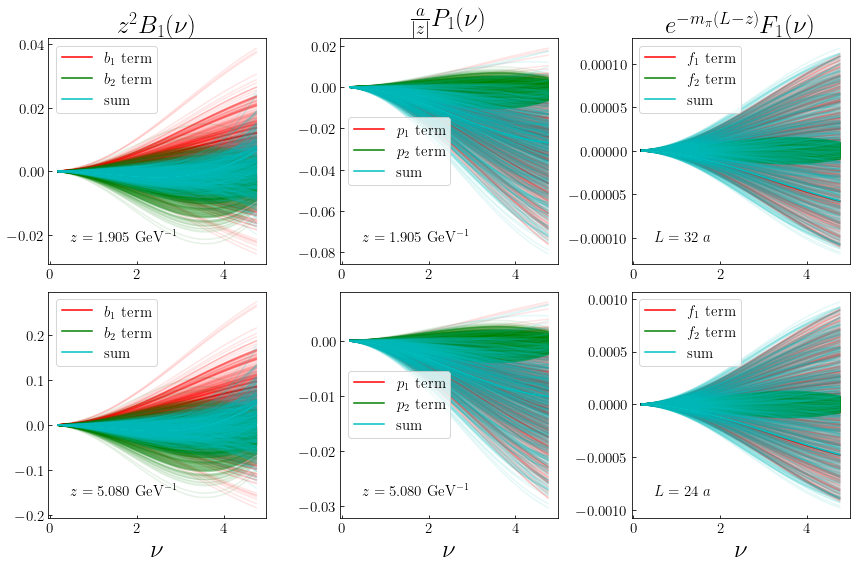

In [88]:
# %matplotlib agg
# for i in range(1):#range(len(os.listdir('analysis-LCS/pITD'))):
#     print(os.listdir('analysis-LCS/pITD/')[i])
#     wdir='analysis-LCS/pITD/%s'%os.listdir('analysis-LCS/pITD/')[i]
# #     checkdir('%s/gallery'%wdir)
# #     if 'systematics.png' in os.listdir('%s/gallery'%wdir): continue
#     book1=BOOK(wdir,'%s/input.npy'%wdir)
# #     plot_chi2(wdir,book1.red_chi2)
# #     plot_systematics(wdir,book1.samples,book1.predictions,'%s/input.npy'%wdir)
#     time.sleep(3)

wdir='analysis-LCS/pITD/B1B2P1P2F1F2-fromDYLN/'
book1=BOOK(wdir,'%s/input.npy'%wdir)
plot_systematics(wdir,book1.samples,book1.predictions,'%s/input.npy'%wdir)

In [70]:
def plot_chi2_all(homedir):
    
    mapper={}
    fits=os.listdir('%s/analysis-LCS/pITD'%homedir)
    chi2npts=[]
    chi2dof=[]
    for i in range(len(fits)):
        mapper[i]=fits[i]
        chi2=np.load('%s/analysis-LCS/pITD/%s/data/chi2.npy'%(homedir,fits[i]),allow_pickle=True).item(0)
        chi2npts.append(chi2['total']['chi2']/chi2['total']['npts'])
        chi2dof.append(chi2['total']['chi2']/chi2['dof'])
        
    chi2npts.append(0.894067)
    chi2dof.append(0.942095351239669)
    mapper[len(fits)+1]='no-sys'
        
    nrows,ncols=1,1
    py.figure(figsize=(12*ncols,4*nrows))
    ax=py.subplot(nrows,ncols,1)
    ax.plot(range(len(fits)+1),chi2npts,'g',label=r'$\chi^2/{\rm npts}$')
    ax.plot(range(len(fits)+1),chi2dof,'r',label=r'$\chi^2/{\rm dof}$')
    ax.plot(len(fits),chi2npts[-1],'g*',ms=10,label=r'$\chi^2/{\rm npts~no~sys}$')
    ax.plot(len(fits),chi2dof[-1],'r*',ms=10,label=r'$\chi^2/{\rm dof~no~sys}$')
    ax.set_xticks(range(len(fits)+1))
    ax.tick_params(direction='in',which='both',labelsize=10)
    ax.set_xlim(-1,len(fits)+1)
    
    ax.axhline(y=np.min(chi2npts),c='g',ls=':')
    ax.axhline(y=np.min(chi2dof),c='r',ls=':')
    ax.legend(fontsize=20)
    py.tight_layout()
    checkdir('%s/new_gallery'%homedir)
    py.savefig('%s/new_gallery/chi2npts.png'%homedir)
    
    return mapper

In [14]:
def plot_chi2_pITD(homedir):
    
    mapper={}
    fits=os.listdir('%s/analysis-LCS/pITD'%homedir)
    chi2npts={1001:[],1002:[]}
    for i in range(len(fits)):
        mapper[i]=fits[i]
        chi2=np.load('%s/analysis-LCS/pITD/%s/data/chi2.npy'%(homedir,fits[i]),allow_pickle=True).item(0)
        for k in [1001,1002]:
            chi2npts[k].append(chi2['pITD'][k]['chi2']/chi2['pITD'][k]['npts'])
        
    chi2npts[1001].append(1.041327)
    chi2npts[1002].append(2.156697)
    mapper[len(fits)+1]='no-sys'
        
    nrows,ncols=1,1
    py.figure(figsize=(12*ncols,4*nrows))
    ax=py.subplot(nrows,ncols,1)
    ax.plot(range(len(fits)+1),chi2npts[1001],'g',label=r'$\chi^2/{\rm npts~1001}$')
    ax.plot(range(len(fits)+1),chi2npts[1002],'r',label=r'$\chi^2/{\rm npts~1002}$')
    ax.plot(len(fits),chi2npts[1001][-1],'g*',ms=10,label=r'$\chi^2/{\rm npts~no~sys~1001}$')
    ax.plot(len(fits),chi2npts[1002][-1],'r*',ms=10,label=r'$\chi^2/{\rm npts~no~sys~1002}$')
    ax.set_xticks(range(len(fits)+1))
    ax.tick_params(direction='in',which='both',labelsize=10)
    ax.set_xlim(-1,len(fits)+1)
    
    ax.axhline(y=np.min(chi2npts[1001]),c='g',ls=':')
    ax.axhline(y=np.min(chi2npts[1002]),c='r',ls=':')
    ax.legend(fontsize=20)
    py.tight_layout()
    checkdir('%s/new_gallery'%homedir)
    py.savefig('%s/new_gallery/chi2npts-pITD.png'%homedir)
    
    return mapper

In [15]:
def plot_chi2_DY(homedir):
    
    mapper={}
    fits=os.listdir('%s/analysis-LCS/pITD'%homedir)
    chi2npts={10001:[],10002:[],10003:[]}
    for i in range(len(fits)):
        mapper[i]=fits[i]
        chi2=np.load('%s/analysis-LCS/pITD/%s/data/chi2.npy'%(homedir,fits[i]),allow_pickle=True).item(0)
        for k in [10001,10002,10003]:
            chi2npts[k].append(chi2['dy-pion'][k]['chi2']/chi2['dy-pion'][k]['npts'])
        
    chi2npts[10001].append(0.84035)
    chi2npts[10002].append(0.514772)
    chi2npts[10003].append(0.763452)
    mapper[len(fits)+1]='no-sys'
        
    nrows,ncols=1,1
    py.figure(figsize=(12*ncols,4*nrows))
    ax=py.subplot(nrows,ncols,1)
    ax.plot(range(len(fits)+1),chi2npts[10001],'g',label=r'$\chi^2/{\rm npts~10001}$')
    ax.plot(range(len(fits)+1),chi2npts[10002],'r',label=r'$\chi^2/{\rm npts~10002}$')
    ax.plot(range(len(fits)+1),chi2npts[10003],'b',label=r'$\chi^2/{\rm npts~10003}$')
    ax.plot(len(fits),chi2npts[10001][-1],'g*',ms=10,label=r'$\chi^2/{\rm npts~no~sys~10001}$')
    ax.plot(len(fits),chi2npts[10002][-1],'r*',ms=10,label=r'$\chi^2/{\rm npts~no~sys~10002}$')
    ax.plot(len(fits),chi2npts[10003][-1],'b*',ms=10,label=r'$\chi^2/{\rm npts~no~sys~10003}$')
    ax.set_xticks(range(len(fits)+1))
    ax.tick_params(direction='in',which='both',labelsize=10)
    ax.set_xlim(-1,len(fits)+1)
    
    ax.axhline(y=np.min(chi2npts[10001]),c='g',ls=':')
    ax.axhline(y=np.min(chi2npts[10002]),c='r',ls=':')
    ax.axhline(y=np.min(chi2npts[10003]),c='b',ls=':')
    ax.legend(fontsize=20)
    py.tight_layout()
    checkdir('%s/new_gallery'%homedir)
    py.savefig('%s/new_gallery/chi2npts-DY.png'%homedir)
    
    return mapper

In [16]:
def plot_chi2_LN(homedir):
    
    mapper={}
    fits=os.listdir('%s/analysis-LCS/pITD'%homedir)
    chi2npts={1000:[],2000:[]}
    for i in range(len(fits)):
        mapper[i]=fits[i]
        chi2=np.load('%s/analysis-LCS/pITD/%s/data/chi2.npy'%(homedir,fits[i]),allow_pickle=True).item(0)
        for k in [1000,2000]:
            chi2npts[k].append(chi2['ln'][k]['chi2']/chi2['ln'][k]['npts'])
        
    chi2npts[1000].append(0.381296)
    chi2npts[2000].append(1.523709)
    mapper[len(fits)+1]='no-sys'
        
    nrows,ncols=1,1
    py.figure(figsize=(12*ncols,4*nrows))
    ax=py.subplot(nrows,ncols,1)
    ax.plot(range(len(fits)+1),chi2npts[1000],'g',label=r'$\chi^2/{\rm npts~1000}$')
    ax.plot(range(len(fits)+1),chi2npts[2000],'r',label=r'$\chi^2/{\rm npts~2000}$')
    ax.plot(len(fits),chi2npts[1000][-1],'g*',ms=10,label=r'$\chi^2/{\rm npts~no~sys~1000}$')
    ax.plot(len(fits),chi2npts[2000][-1],'r*',ms=10,label=r'$\chi^2/{\rm npts~no~sys~2000}$')
    ax.set_xticks(range(len(fits)+1))
    ax.tick_params(direction='in',which='both',labelsize=10)
    ax.set_xlim(-1,len(fits)+1)
    
    ax.axhline(y=np.min(chi2npts[1000]),c='g',ls=':')
    ax.axhline(y=np.min(chi2npts[2000]),c='r',ls=':')
    ax.legend(fontsize=20)
    py.tight_layout()
    checkdir('%s/new_gallery'%homedir)
    py.savefig('%s/new_gallery/chi2npts-LN.png'%homedir)
    
    return mapper

In [110]:
# mapper=plot_chi2_all('.')
mapper=plot_chi2_pITD('.')
mapper=plot_chi2_DY('.')
mapper=plot_chi2_LN('.')

In [116]:
mapper[44]

'P1P2F1F2'

In [11]:
def plot_pdfs(wdir,nolatt,nosys,pdfs):
    
    newpdf=pdfs
    midpdf=nosys
    oldpdf=nolatt
    
    nrows,ncols=1,2
    py.figure(figsize=(8*ncols,6*nrows))

    ax=py.subplot(nrows,ncols,1)
    ax.plot(newpdf['X'],np.mean(newpdf['XF']['valence'],axis=0),'r',label=r'$\rm full$')
    ax.fill_between(newpdf['X'],np.mean(newpdf['XF']['valence'],axis=0)-np.std(newpdf['XF']['valence'],axis=0),np.mean(newpdf['XF']['valence'],axis=0)+np.std(newpdf['XF']['valence'],axis=0),alpha=0.5,fc='r')
    ax.plot(midpdf['X'],np.mean(midpdf['XF']['valence'],axis=0),'g',label=r'$\rm no~systematics$')
    ax.fill_between(midpdf['X'],np.mean(midpdf['XF']['valence'],axis=0)-np.std(midpdf['XF']['valence'],axis=0),np.mean(midpdf['XF']['valence'],axis=0)+np.std(midpdf['XF']['valence'],axis=0),alpha=0.5,fc='g')
    ax.plot(oldpdf['X'],np.mean(oldpdf['XF']['valence'],axis=0),'y',label=r'$\rm w/o~lattice$')
    ax.fill_between(oldpdf['X'],np.mean(oldpdf['XF']['valence'],axis=0)-np.std(oldpdf['XF']['valence'],axis=0),np.mean(oldpdf['XF']['valence'],axis=0)+np.std(oldpdf['XF']['valence'],axis=0),alpha=0.3,fc='y')
    ax.set_xlabel(r'$x$',size=30)
    ax.set_ylabel(r'$xq_v(x,\mu_0^2)$',size=30)
    ax.set_xlim(0,1)
    ax.set_ylim(0,0.43)
    ax.set_yticks([0,0.1,0.2,0.3,0.4])
    ax.set_yticklabels(['',r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$'])
    ax.legend(fontsize=25)
    ax.tick_params(direction='in',which='both',labelsize=25)

    ax=py.subplot(nrows,ncols,2)
    ax.plot(newpdf['X'],np.std(newpdf['XF']['valence'],axis=0)/newpdf['X']/np.mean(newpdf['XF']['valence'],axis=0),'r',lw=3)
    ax.plot(midpdf['X'],np.std(midpdf['XF']['valence'],axis=0)/midpdf['X']/np.mean(midpdf['XF']['valence'],axis=0),'g',lw=3)
    ax.plot(oldpdf['X'],np.std(oldpdf['XF']['valence'],axis=0)/oldpdf['X']/np.mean(oldpdf['XF']['valence'],axis=0),'y',lw=3)
    ax.set_xlabel(r'$x$',size=30)
    ax.set_ylabel(r'$\delta q_v/q_v$',size=30)
    ax.set_ylim(0,0.15)
    ax.set_xlim(0.2,0.9)
    # ax.semilogy()
    ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15])
    ax.set_yticklabels(['','',r'$0.02$','',r'$0.04$','',r'$0.06$','',r'$0.08$','',r'$0.1$','',r'$0.12$','',r'$0.14$',''])

    ax.tick_params(direction='in',which='both',labelsize=25)

    py.tight_layout()
    py.savefig('%s/gallery/pdfval.png'%wdir)
    py.savefig('%s/gallery/pdfval.pdf'%wdir)

In [12]:
def plot_pdfs_reps(wdir,nolatt,nosys,pdfs):
    
    newpdf=pdfs
    midpdf=nosys
    oldpdf=nolatt
    
    nrows,ncols=1,2
    py.figure(figsize=(8*ncols,6*nrows))

    ax=py.subplot(nrows,ncols,1)
    [ax.plot(newpdf['X'],_,'r',alpha=0.1) for _ in newpdf['XF']['valence']]
    [ax.plot(midpdf['X'],_,'g',alpha=0.1) for _ in midpdf['XF']['valence']]
    [ax.plot(oldpdf['X'],_,'y',alpha=0.1) for _ in oldpdf['XF']['valence']]
    ax.set_xlabel(r'$x$',size=30)
    ax.set_ylabel(r'$xq_v(x,\mu_0^2)$',size=30)
    ax.set_xlim(0,1)
    ax.set_ylim(0,0.43)
    ax.set_yticks([0,0.1,0.2,0.3,0.4])
    ax.set_yticklabels(['',r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$'])
    ax.legend(fontsize=25)
    ax.tick_params(direction='in',which='both',labelsize=25)

    ax=py.subplot(nrows,ncols,2)
    ax.plot(newpdf['X'],np.std(newpdf['XF']['valence'],axis=0)/newpdf['X']/np.mean(newpdf['XF']['valence'],axis=0),'r',lw=3)
    ax.plot(midpdf['X'],np.std(midpdf['XF']['valence'],axis=0)/midpdf['X']/np.mean(midpdf['XF']['valence'],axis=0),'g',lw=3)
    ax.plot(oldpdf['X'],np.std(oldpdf['XF']['valence'],axis=0)/oldpdf['X']/np.mean(oldpdf['XF']['valence'],axis=0),'y',lw=3)
    ax.set_xlabel(r'$x$',size=30)
    ax.set_ylabel(r'$\delta q_v/q_v$',size=30)
    ax.set_ylim(0,0.15)
    ax.set_xlim(0.2,0.9)
    # ax.semilogy()
    ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15])
    ax.set_yticklabels(['','',r'$0.02$','',r'$0.04$','',r'$0.06$','',r'$0.08$','',r'$0.1$','',r'$0.12$','',r'$0.14$',''])

    ax.tick_params(direction='in',which='both',labelsize=25)

    py.tight_layout()
    py.savefig('%s/gallery/pdfval_mod.png'%wdir)

In [13]:
def plot_pdfs_all(wdir,nolatt,pdfs):
    
    newpdf=pdfs
    oldpdf=nolatt
    
    nrows,ncols=1,3
    py.figure(figsize=(8*ncols,6*nrows))

    ax=py.subplot(nrows,ncols,1)
    ax.plot(newpdf['X'],np.mean(newpdf['XF']['valence'],axis=0),'r',label=r'$\rm full$')
    ax.fill_between(newpdf['X'],np.mean(newpdf['XF']['valence'],axis=0)-np.std(newpdf['XF']['valence'],axis=0),np.mean(newpdf['XF']['valence'],axis=0)+np.std(newpdf['XF']['valence'],axis=0),alpha=0.5,fc='r')
    ax.plot(oldpdf['X'],np.mean(oldpdf['XF']['valence'],axis=0),'y',label=r'$\rm w/o~lattice$')
    ax.fill_between(oldpdf['X'],np.mean(oldpdf['XF']['valence'],axis=0)-np.std(oldpdf['XF']['valence'],axis=0),np.mean(oldpdf['XF']['valence'],axis=0)+np.std(oldpdf['XF']['valence'],axis=0),alpha=0.3,fc='y')
    ax.set_xlabel(r'$x$',size=30)
    ax.set_ylabel(r'$xq_v(x,\mu_0^2)$',size=30)
    ax.set_xlim(0,1)
    ax.set_ylim(0,0.43)
    ax.set_yticks([0,0.1,0.2,0.3,0.4])
    ax.set_yticklabels(['',r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$'])
    ax.legend(fontsize=25)
    ax.tick_params(direction='in',which='both',labelsize=25)

    ax=py.subplot(nrows,ncols,2)
    ax.plot(newpdf['X'],np.mean(newpdf['XF']['sea'],axis=0),'r',label=r'$\rm full$')
    ax.fill_between(newpdf['X'],np.mean(newpdf['XF']['sea'],axis=0)-np.std(newpdf['XF']['sea'],axis=0),np.mean(newpdf['XF']['sea'],axis=0)+np.std(newpdf['XF']['sea'],axis=0),alpha=0.5,fc='r')
    ax.plot(oldpdf['X'],np.mean(oldpdf['XF']['sea'],axis=0),'y',label=r'$\rm w/o~lattice$')
    ax.fill_between(oldpdf['X'],np.mean(oldpdf['XF']['sea'],axis=0)-np.std(oldpdf['XF']['sea'],axis=0),np.mean(oldpdf['XF']['sea'],axis=0)+np.std(oldpdf['XF']['sea'],axis=0),alpha=0.3,fc='y')
    ax.set_xlabel(r'$x$',size=30)
    ax.set_ylabel(r'$xq_s(x,\mu_0^2)$',size=30)
    ax.set_xlim(0,1)
    ax.set_ylim(0,0.43)
    ax.set_yticks([0,0.1,0.2,0.3,0.4])
    ax.set_yticklabels(['',r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$'])
    ax.legend(fontsize=25)
    ax.tick_params(direction='in',which='both',labelsize=25)

    ax=py.subplot(nrows,ncols,3)
    ax.plot(newpdf['X'],np.mean(newpdf['XF']['g'],axis=0)/10,'r',label=r'$\rm full$')
    ax.fill_between(newpdf['X'],np.mean(newpdf['XF']['g'],axis=0)/10-np.std(newpdf['XF']['g'],axis=0)/10,np.mean(newpdf['XF']['g'],axis=0)/10+np.std(newpdf['XF']['g'],axis=0)/10,alpha=0.5,fc='r')
    ax.plot(oldpdf['X'],np.mean(oldpdf['XF']['g'],axis=0)/10,'y',label=r'$\rm w/o~lattice$')
    ax.fill_between(oldpdf['X'],np.mean(oldpdf['XF']['g'],axis=0)/10-np.std(oldpdf['XF']['g'],axis=0)/10,np.mean(oldpdf['XF']['g'],axis=0)/10+np.std(oldpdf['XF']['g'],axis=0)/10,alpha=0.3,fc='y')
    ax.set_xlabel(r'$x$',size=30)
    ax.set_ylabel(r'$xg(x,\mu_0^2)/10$',size=30)
    ax.set_xlim(0,1)
    ax.set_ylim(0,0.43)
    ax.set_yticks([0,0.1,0.2,0.3,0.4])
    ax.set_yticklabels(['',r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$'])
    ax.legend(fontsize=25)
    ax.tick_params(direction='in',which='both',labelsize=25)


    ax.tick_params(direction='in',which='both',labelsize=25)

    py.tight_layout()
    py.savefig('%s/gallery/pdf.png'%wdir)
    py.savefig('%s/gallery/pdf.pdf'%wdir)

In [14]:
def plot_pdfs_all_reps(wdir,nolatt,pdfs):
    
    newpdf=pdfs
    oldpdf=nolatt
    
    nrows,ncols=1,3
    py.figure(figsize=(8*ncols,6*nrows))

    ax=py.subplot(nrows,ncols,1)
    [ax.plot(newpdf['X'],_,'r',alpha=0.1) for _ in newpdf['XF']['valence']]
    [ax.plot(oldpdf['X'],_,'y',alpha=0.1) for _ in oldpdf['XF']['valence']]
    ax.set_xlabel(r'$x$',size=30)
    ax.set_ylabel(r'$xq_v(x,\mu_0^2)$',size=30)
    ax.set_xlim(0,1)
    ax.set_ylim(0,0.43)
    ax.set_yticks([0,0.1,0.2,0.3,0.4])
    ax.set_yticklabels(['',r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$'])
    ax.legend(fontsize=25)
    ax.tick_params(direction='in',which='both',labelsize=25)

    ax=py.subplot(nrows,ncols,2)
    [ax.plot(newpdf['X'],_,'r',alpha=0.1) for _ in newpdf['XF']['sea']]
    [ax.plot(oldpdf['X'],_,'y',alpha=0.1) for _ in oldpdf['XF']['sea']]
    ax.set_xlabel(r'$x$',size=30)
    ax.set_ylabel(r'$xq_s(x,\mu_0^2)$',size=30)
    ax.set_xlim(0,1)
    ax.set_ylim(0,0.43)
    ax.set_yticks([0,0.1,0.2,0.3,0.4])
    ax.set_yticklabels(['',r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$'])
    ax.legend(fontsize=25)
    ax.tick_params(direction='in',which='both',labelsize=25)

    ax=py.subplot(nrows,ncols,3)
    [ax.plot(newpdf['X'],_/10,'r',alpha=0.1) for _ in np.array(newpdf['XF']['g'])]
    [ax.plot(oldpdf['X'],_/10,'y',alpha=0.1) for _ in np.array(oldpdf['XF']['g'])]
    ax.set_xlabel(r'$x$',size=30)
    ax.set_ylabel(r'$xg(x,\mu_0^2)$',size=30)
    ax.set_xlim(0,1)
    ax.set_ylim(0,0.43)
    ax.set_yticks([0,0.1,0.2,0.3,0.4])
    ax.set_yticklabels(['',r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$'])
    ax.legend(fontsize=25)
    ax.tick_params(direction='in',which='both',labelsize=25)


    ax.tick_params(direction='in',which='both',labelsize=25)

    py.tight_layout()
    py.savefig('%s/gallery/pdf_mod.png'%wdir)

In [15]:
# book1.pdfs.keys()

In [16]:
# nolattPDFs=load('/work/JAM/barryp/JAM/analysis-LCS/NLOpy3/data/pdf-16.dat')
nolattPDFs=load('/work/JAM/barryp/JAM/analysis-pions/FINALpy3/step15/data/pdf-15.dat')
nosysPDFs=load('/work/JAM/barryp/JAM/analysis-LCS/pITD/pITDnlo_allp/data/pdf-17.dat')

516


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


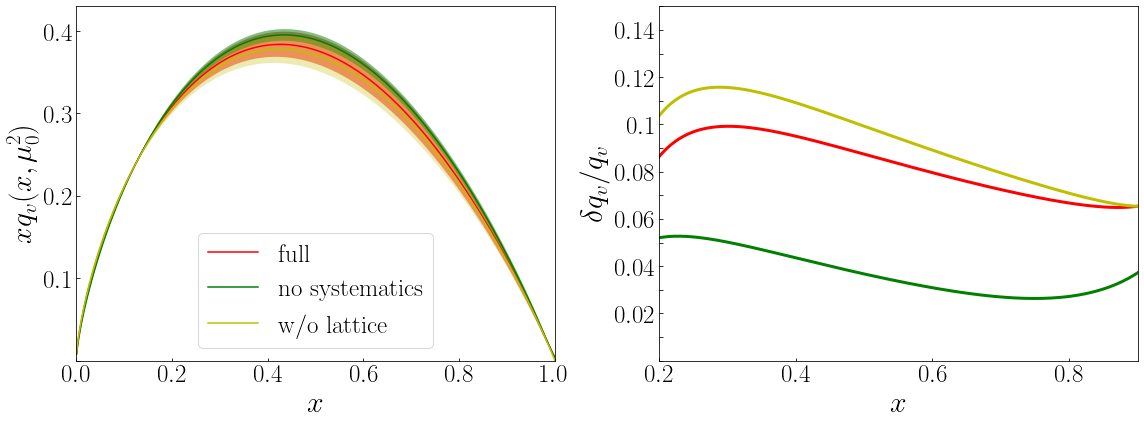

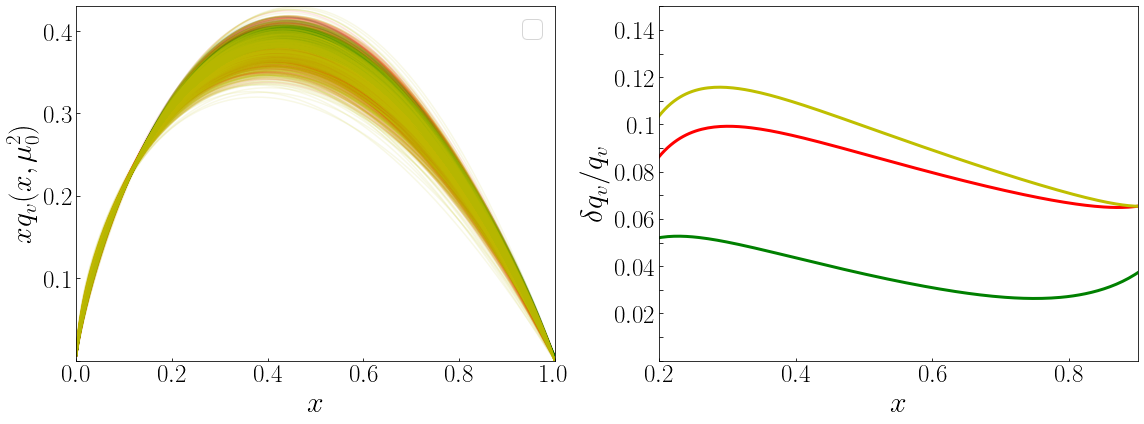

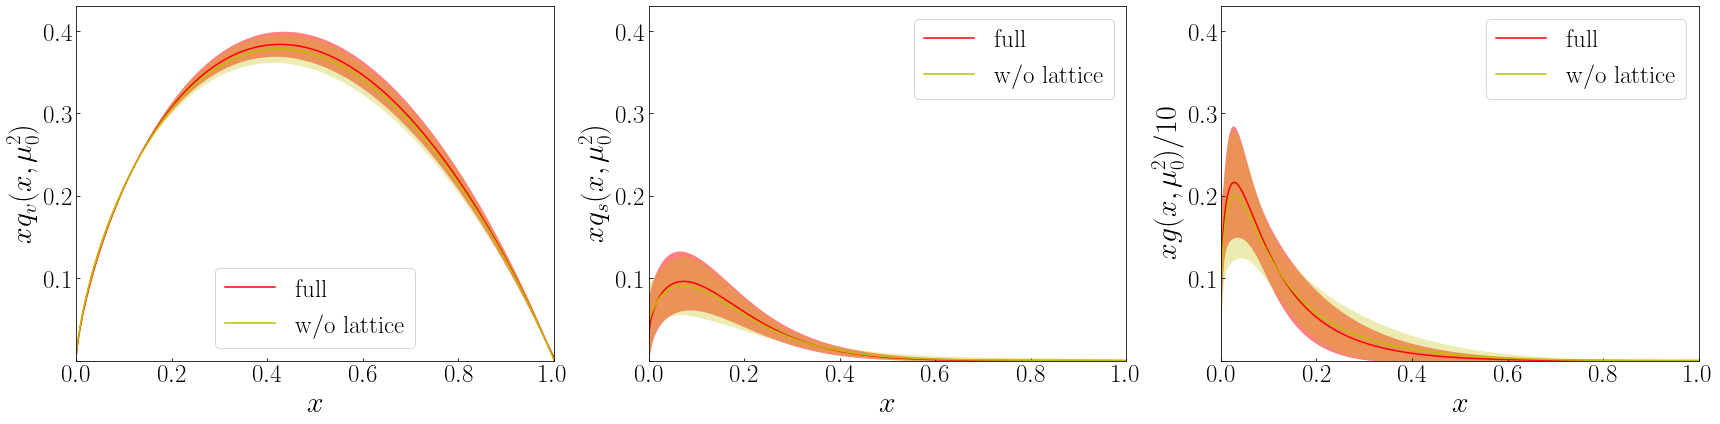

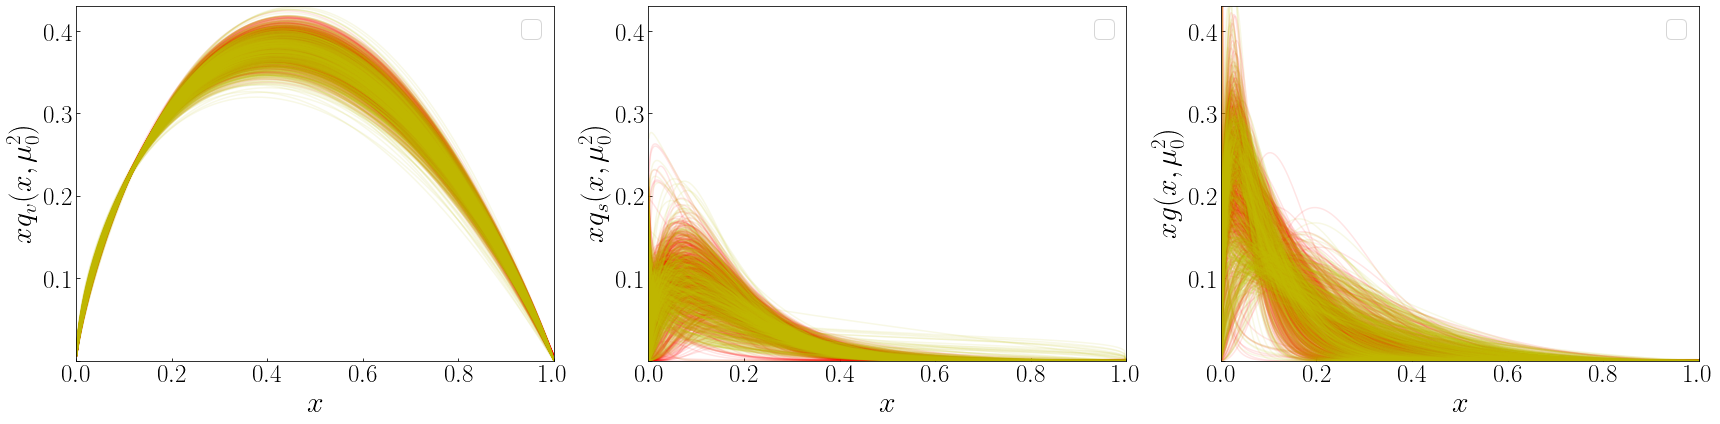

In [33]:
# wdir='analysis-LCS/pITD/P1/'
# wdir='analysis-LCS/pITD/B1B2P1P2F1F2'
wdir='analysis-LCS/pITD/B1B2P1P2-fromDYLN/'
book1=BOOK(wdir,'%s/input.npy'%wdir)
plot_pdfs(wdir,nolattPDFs,nosysPDFs,book1.pdfs)
plot_pdfs_reps(wdir,nolattPDFs,nosysPDFs,book1.pdfs)
plot_pdfs_all(wdir,nolattPDFs,book1.pdfs)
plot_pdfs_all_reps(wdir,nolattPDFs,book1.pdfs)
# plot_chi2(wdir,book1.red_chi2)
# for k in [1001,1002]:
#     plot_data_over_theory(wdir,book1.predictions,k)
#     plot_data_and_theory(wdir,book1.predictions,k)
#     plot_data_and_theory_sysnosys(wdir,book1.predictions,book1.predictions_nosys,k)
# # if 'histogram' in os.listdir('%s/gallery/'%wdir): continue
# plot_correlations(wdir,book1.samples,'%s/input.npy'%wdir)
# plot_histograms(wdir,book1.samples,'%s/input.npy'%wdir)

In [34]:
%matplotlib agg
for i in range(len(os.listdir('analysis-LCS/pITD'))):
    print(os.listdir('analysis-LCS/pITD/')[i])
    wdir='analysis-LCS/pITD/%s'%os.listdir('analysis-LCS/pITD/')[i]
#     checkdir('%s/gallery'%wdir)
#     if 'systematics.png' in os.listdir('%s/gallery'%wdir): continue
    book1=BOOK(wdir,'%s/input.npy'%wdir)
#     plot_chi2(wdir,book1.red_chi2)
#     plot_systematics(wdir,book1.samples,book1.predictions,'%s/input.npy'%wdir)
    plot_pdfs(wdir,nolattPDFs,nosysPDFs,book1.pdfs)
    time.sleep(3)

P1P2
B2P2F1


KeyboardInterrupt: 

In [105]:
mapper

{0: 'P1P2',
 1: 'B2P2F1',
 2: 'B2F1F2',
 3: 'B2P1F2',
 4: 'P2F2',
 5: 'P1F1',
 6: 'B1B2P1P2F1F2',
 7: 'B1P2F1F2',
 8: 'P1',
 9: 'F2',
 10: 'P1P2F2',
 11: 'B1P1',
 12: 'B2P2',
 13: 'B2P1P2F1F2',
 14: 'B2F1',
 15: 'B1F2',
 16: 'B2P1F1',
 17: 'B2P2F2',
 18: 'F1P1',
 19: 'B2P2F1F2',
 20: 'P1F2',
 21: 'F1F2',
 22: 'P2F1',
 23: 'B2P1P2',
 24: 'P2',
 25: 'F1',
 26: 'P1F1F2',
 27: 'B2P1',
 28: 'B1P2',
 29: 'P1P2F1',
 30: 'B1F1',
 31: 'B1B2P2F1F2',
 32: 'B2F2',
 33: 'B1P1P2F2',
 34: 'B1B2F1',
 35: 'B1P1P2F1F2',
 36: 'P2F1F2',
 37: 'B1B2P1P2F1',
 38: 'B1B2P1F1F2',
 39: 'B1B2P2',
 40: 'B1P2F2',
 41: 'B2P1F1F2',
 42: 'B2P1P2F1',
 43: 'B1P1F1',
 44: 'P1P2F1F2',
 45: 'B1P1P2',
 46: 'B1',
 47: 'B1B2F1F2',
 48: 'B1B2P1F2',
 49: 'B1B2P2F1',
 50: 'B1P1P2F1',
 51: 'B1P1F1F2',
 52: 'B1B2F2',
 53: 'B1B2P1',
 54: 'B1B2P1P2F2',
 55: 'B1P1F2',
 56: 'B1F1F2',
 57: 'B2P1P2F2',
 58: 'B1P2F1',
 59: 'B2',
 60: 'B1F1P1',
 61: 'B1B2P2F2',
 62: 'B1B2P1F1',
 63: 'B1B2P1P2',
 64: 'B1B2',
 66: 'no-sys'}

In [17]:
def par_2d_scatter(wdir,samples,inputfile,active_list=[]):
    
    load_config2(inputfile)
    set_active_params(active_list)
    conf['bootstrap'] = False
    resman=RESMAN(parallel=True,datasets=True)
    parman=resman.parman

    parmean=np.mean(samples,axis=0)
    order=parman.order

    title=list(range(len(order)))
    for i in range(len(order)):
        if order[i][1]=='pdf-pion':
            parname=order[i][2][-1]
            if 'ubv' in order[i][2]:
                title[i]=r'$\bar{u}_{v,%s}$'%parname
            else:
                parton=order[i][2][0]
                title[i]=r'$%s_{%s}$'%(parton,parname)
        elif 'lambda'==order[i][2]:
            title[i]=r'$\Lambda$'
        elif 'lat-sys'==order[i][1]:
            parname=order[i][2][0]
            power=order[i][2][1]
            title[i]=r'$%s_{%s}$'%(parname,power)
        elif order[i][0]==2:
            expt=order[i][2]
            title[i]=r'$N_{%i}$'%expt

    cnt1=0
    for i in range(len(order)):
        cnt1+=1
        nrows,ncols=4,5
        py.figure(figsize=(6*ncols,5*nrows))    
        lprint('progress: %i/%i'%(cnt1,len(order)))


        par=[]
        for j in range(len(samples)):
            par.append(samples[j][i])

        par=np.array(par)
        
        cnt2=0
        for j in range(len(order)):
            cnt2+=1
            ax=py.subplot(nrows,ncols,cnt2)
            par2=[]
            for ii in range(len(samples)):
                par2.append(samples[ii][j])
            ax.scatter(par,par2)
            ax.set_xlabel(title[i],size=35)
            ax.set_ylabel(title[j],size=35)
            ax.tick_params(direction='in',which='both',labelsize=30)

        py.tight_layout()
        checkdir('%s/gallery/scatter'%wdir)
        py.savefig('%s/gallery/scatter/%s.png'%(wdir,order[i][2]))
    

In [36]:
%matplotlib agg
wdir='analysis-LCS/pITD/B1B2P1P2-fromDYLN/'
book1=BOOK(wdir,'%s/input.npy'%wdir)
par_2d_scatter(wdir,book1.samples,'%s/input.npy'%wdir)

[[1, 'pdf-pion', 'g1 N'], [1, 'pdf-pion', 'g1 a'], [1, 'pdf-pion', 'g1 b'], [1, 'pdf-pion', 'ubv1 a'], [1, 'pdf-pion', 'ubv1 b'], [1, 'pdf-pion', 'u1 a'], [1, 'pdf-pion', 'u1 b'], [1, 'p->pi,n', 'lambda'], [1, 'lat-sys', 'b1-pITD'], [1, 'lat-sys', 'p1-pITD'], [1, 'lat-sys', 'b2-pITD'], [1, 'lat-sys', 'p2-pITD'], [2, 'ln', 1000], [2, 'ln', 2000], [2, 'dy-pion', 10001], [2, 'dy-pion', 10002], [2, 'dy-pion', 10003]]
loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading pITD data sets 1001
loading pITD data sets 1002
progress: 17/17

Process w1:
Process w0:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/work/JAM/barryp/JAM/fitpack2testing/tools/parallel.py", line 69, in worker
    work = self.recv(sock)
  File "/work/JAM/barryp/JAM/fitpack2testing/tools/parallel.py", line 55, in recv
    return pickle.loads(sock.recv())
  File "/work/JAM/barryp/JAM/fitpack2testing/tools/parallel.py", line 69, in worker
    work = self.recv(sock)
  File "zmq/backend/cython/socket.pyx", line 781, in zmq.backend.cython.socket.Socket.recv
  File "/work/JAM/barr

In [18]:
from sklearn.cluster import KMeans

def cluster(wdir,samples,clusterpars,nc,inputfile,active_list=[]):
    load_config2(inputfile)
    set_active_params(active_list)
    conf['bootstrap'] = False
    resman=RESMAN(parallel=True,datasets=True)
    parman=resman.parman

    parmean=np.mean(samples,axis=0)
    order=parman.order
    
    pars4cluster=[]
    for i in range(len(samples)):
        pars4cluster.append([])
        for j in range(len(order)):
            if order[j][2] in clusterpars:
                pars4cluster[i].append(samples[i][j])
    
    kmeans=KMeans(n_clusters=nc,random_state=0).fit(pars4cluster)
    return kmeans.labels_

In [18]:
wdir='analysis-LCS/pITD/B1B2P1P2-fromDYLN'
book1=BOOK(wdir,'%s/input.npy'%wdir)
labels=cluster(wdir,book1.samples,['g1 N','g1 a','g1 b'],2,'%s/input.npy'%wdir)

loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading pITD data sets 1001
loading pITD data sets 1002


In [19]:
cnt=0
for i in range(len(labels)):
    if labels[i]==1: cnt+=1
cnt

171

In [19]:
def plot_pdfs_all_reps_clusters(wdir,nolatt,pdfs,labels):
    
    newpdf=pdfs
    oldpdf=nolatt
    
    nrows,ncols=1,3
    py.figure(figsize=(8*ncols,6*nrows))

    c=['g','r','c','b']

    ax=py.subplot(nrows,ncols,1)
    for i in range(len(newpdf['XF']['valence'])):
        cluster=labels[i]
#         if cluster==1: continue
        ax.plot(newpdf['X'],newpdf['XF']['valence'][i],color=c[cluster],alpha=0.1)
#     [ax.plot(oldpdf['X'],_,'y',alpha=0.1) for _ in oldpdf['XF']['valence']]
    ax.set_xlabel(r'$x$',size=30)
    ax.set_ylabel(r'$xq_v(x,\mu_0^2)$',size=30)
    ax.set_xlim(0,1)
    ax.set_ylim(0,0.43)
    ax.set_yticks([0,0.1,0.2,0.3,0.4])
    ax.set_yticklabels(['',r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$'])
#     ax.legend(fontsize=25)
    ax.tick_params(direction='in',which='both',labelsize=25)

    ax=py.subplot(nrows,ncols,2)
    for i in range(len(newpdf['XF']['sea'])):
        cluster=labels[i]
#         if cluster==1: continue
        ax.plot(newpdf['X'],newpdf['XF']['sea'][i],color=c[cluster],alpha=0.1)
#     [ax.plot(oldpdf['X'],_,'y',alpha=0.1) for _ in oldpdf['XF']['sea']]
    ax.set_xlabel(r'$x$',size=30)
    ax.set_ylabel(r'$xq_s(x,\mu_0^2)$',size=30)
    ax.set_xlim(0,1)
    ax.set_ylim(0,0.43)
    ax.set_yticks([0,0.1,0.2,0.3,0.4])
    ax.set_yticklabels(['',r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$'])
#     ax.legend(fontsize=25)
    ax.tick_params(direction='in',which='both',labelsize=25)

    ax=py.subplot(nrows,ncols,3)
    for i in range(len(newpdf['XF']['g'])):
        cluster=labels[i]
#         if cluster==1: continue
        ax.plot(newpdf['X'],np.array(newpdf['XF']['g'][i])/10,color=c[cluster],alpha=0.1)
#     [ax.plot(oldpdf['X'],_/10,'y',alpha=0.1) for _ in np.array(oldpdf['XF']['g'])]
    ax.set_xlabel(r'$x$',size=30)
    ax.set_ylabel(r'$xg(x,\mu_0^2)$',size=30)
    ax.set_xlim(0,1)
    ax.set_ylim(0,0.43)
    ax.set_yticks([0,0.1,0.2,0.3,0.4])
    ax.set_yticklabels(['',r'$0.1$',r'$0.2$',r'$0.3$',r'$0.4$'])
#     ax.legend(fontsize=25)
    ax.tick_params(direction='in',which='both',labelsize=25)


    ax.tick_params(direction='in',which='both',labelsize=25)

    py.tight_layout()
    py.savefig('%s/gallery/pdf_clusters.png'%wdir)

In [20]:
def par_2d_scatter_cluster(wdir,samples,inputfile,labels,active_list=[]):
    load_config2(inputfile)
    set_active_params(active_list)
    conf['bootstrap'] = False
    resman=RESMAN(parallel=True,datasets=True)
    parman=resman.parman

    parmean=np.mean(samples,axis=0)
    order=parman.order
    c=['g','r','c','b']

    title=list(range(len(order)))
    for i in range(len(order)):
        if order[i][1]=='pdf-pion':
            parname=order[i][2][-1]
            if 'ubv' in order[i][2]:
                title[i]=r'$\bar{u}_{v,%s}$'%parname
            else:
                parton=order[i][2][0]
                title[i]=r'$%s_{%s}$'%(parton,parname)
        elif 'lambda'==order[i][2]:
            title[i]=r'$\Lambda$'
        elif 'lat-sys'==order[i][1]:
            parname=order[i][2][0]
            power=order[i][2][1]
            title[i]=r'$%s_{%s}$'%(parname,power)
        elif order[i][0]==2:
            expt=order[i][2]
            title[i]=r'$N_{%i}$'%expt

    cnt1=0
    for i in range(len(order)):
        cnt1+=1
        nrows,ncols=4,5
        py.figure(figsize=(6*ncols,5*nrows))    
        lprint('progress: %i/%i'%(cnt1,len(order)))


        AX={cnt: py.subplot(nrows,ncols,cnt) for cnt in range(1,len(order)+1)}
        
        for k in np.unique(labels):
        
            par=[]
            for j in range(len(samples)):
                if labels[j]!=k: continue
                par.append(samples[j][i])

            par=np.array(par)

            cnt2=0
            for j in range(len(order)):
                cnt2+=1
    #             ax=py.subplot(nrows,ncols,cnt2)
                par2=[]
                for ii in range(len(samples)):
                    if labels[ii]!=k: continue
                    par2.append(samples[ii][j])
                AX[j+1].scatter(par,par2,color=c[k])
                AX[j+1].set_xlabel(title[i],size=35)
                AX[j+1].set_ylabel(title[j],size=35)
                AX[j+1].tick_params(direction='in',which='both',labelsize=30)

        py.tight_layout()
        checkdir('%s/gallery/scatter-cluster'%wdir)
        py.savefig('%s/gallery/scatter-cluster/%s.png'%(wdir,order[i][2]))
    

In [22]:
%matplotlib agg
wdir='analysis-LCS/pITD/B1B2P1P2-fromDYLN'
book1=BOOK(wdir,'%s/input.npy'%wdir)
labels=cluster(wdir,book1.samples,['g1 N','g1 a'],4,'%s/input.npy'%wdir)
par_2d_scatter_cluster(wdir,book1.samples,'%s/input.npy'%wdir,labels)
plot_pdfs_all_reps_clusters(wdir,nolattPDFs,book1.pdfs,labels)

loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading pITD data sets 1001
loading pITD data sets 1002
loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading pITD data sets 1001
loading pITD data sets 1002
progress: 17/17

In [31]:
chi2=np.load('%s/data/chi2.npy'%wdir,allow_pickle=True,encoding='latin1').item()

In [38]:
print(chi2['total']['chi2']/chi2['total']['npts'])

0.8816093107654286


In [34]:
for k in chi2:
    for kk in chi2[k]:
        print('%s:%s:%f'%(k,kk,chi2[k][kk]['chi2']/chi2[k][kk]['npts']))

dy-pion:10001:0.834758
dy-pion:10002:0.529382
dy-pion:10003:0.796061
ln:1000:0.372673
ln:2000:1.589501
pITD:1001:1.016729
pITD:1002:1.626661


IndexError: invalid index to scalar variable.

# Remove reps with bad clusteranalysis-LCS/pITD/B1B2P1P2-fromDYLN/

In [38]:
badcluster=1

In [60]:
def get_goodcluster_samples(wdir,samples,labels,badcluster,active_list=[]):
    cnt=0
    goodsamples=[]
    for i in range(len(samples)):
        if labels[i]==badcluster: continue
        goodsamples.append(samples[i])
    checkdir('%s/data'%wdir)
    np.save('%s/data/samples'%wdir,np.array(samples))
    return np.array(goodsamples)


In [51]:
get_goodcluster_samples('analysis-LCS/pITD/B1B2P1P2F1F2',book1.samples,labels,badcluster)

715


array([[ 0.29163184, -0.85473889,  8.92647856, ...,  1.09534831,
         0.89681328,  0.8542159 ],
       [ 0.34014868, -0.55911615, 13.5187256 , ...,  1.04510978,
         0.8537427 ,  0.80116413],
       [ 0.35573792, -0.79197775,  7.64631205, ...,  1.03420468,
         0.85241527,  0.79667575],
       ...,
       [ 0.2749443 , -0.2203432 , 26.70073446, ...,  1.10380587,
         0.88896269,  0.81859725],
       [ 0.20156398, -0.35782362, 28.86180214, ...,  1.14952887,
         0.93960822,  0.8894091 ],
       [ 0.33911103, -0.73695921,  3.61517449, ...,  1.02737058,
         0.83153639,  0.77417907]])

In [62]:
get_goodcluster_samples(wdir,book1.samples,labels,badcluster)

array([[ 0.29163184, -0.85473889,  8.92647856, ...,  1.09534831,
         0.89681328,  0.8542159 ],
       [ 0.34014868, -0.55911615, 13.5187256 , ...,  1.04510978,
         0.8537427 ,  0.80116413],
       [ 0.35573792, -0.79197775,  7.64631205, ...,  1.03420468,
         0.85241527,  0.79667575],
       ...,
       [ 0.2749443 , -0.2203432 , 26.70073446, ...,  1.10380587,
         0.88896269,  0.81859725],
       [ 0.20156398, -0.35782362, 28.86180214, ...,  1.14952887,
         0.93960822,  0.8894091 ],
       [ 0.33911103, -0.73695921,  3.61517449, ...,  1.02737058,
         0.83153639,  0.77417907]])

In [65]:
def gen_red_chi2_second(wdir,samples,inputfile,active_list=[]):
    load_config2(inputfile)
    set_active_params(active_list)
    conf['bootstrap'] = False
    resman=RESMAN(parallel=True,datasets=True) #--attempting parallel=True
    parman=resman.parman
    red_chi2=[]
    cnt=0
    for i in range(len(samples)):
        par=samples[i]
        cnt+=1
        lprint('computing red chi2 %d/%d'%(cnt,len(samples)))
        res,rres,nres=resman.get_residuals(par)
        red_chi2.append(np.sum(res**2)/res.size)
    checkdir('%s/data'%wdir)
    np.save('%s/data/red_chi2'%wdir,np.array(red_chi2))
    return np.array(red_chi2)


In [66]:
class BOOK2:
    
    def __init__(self,wdir,input_file,originalsamples,labels,badcluster,active_list=[]):
        self.input_file=input_file
        self.active_list=active_list
        checkdir('%s/data'%wdir)
        
        self.samples=get_goodcluster_samples(wdir,originalsamples,labels,badcluster)

        self.red_chi2=gen_red_chi2_second(wdir,self.samples,self.input_file,self.active_list)
        
        self.predictions=gen_predictions(wdir,self.samples,self.input_file,self.active_list)
            
        self.chi2=np.load('%s/data/chi2.npy'%wdir,allow_pickle=True).item(0)
    
        self.predictions_nosys=gen_predictions_nosys(wdir,self.samples,self.input_file,self.active_list)
            
        self.pdfs=gen_pdf(wdir,self.samples,self.input_file,self.active_list)

In [70]:
# %matplotlib agg
# wdir='analysis-LCS/pITD/B1B2P1P2F1F2/'
# book1=BOOK(wdir,'%s/input.npy'%wdir)
# labels=cluster(wdir,book1.samples,['g1 N','g1 a','g1 b','u1 a'],3,'%s/input.npy'%wdir)

wdir='analysis-LCS/pITD/full_goodclusters/'
# book2=BOOK2(wdir,'%s/input.npy'%wdir,book1.samples,labels,1)
# plot_chi2(wdir,book2.red_chi2)
# for k in [1001,1002]:
#     plot_data_over_theory(wdir,book2.predictions,k)
#     plot_data_and_theory(wdir,book2.predictions,k)
#     plot_data_and_theory_sysnosys(wdir,book2.predictions,book2.predictions_nosys,k)
# plot_histograms(wdir,book2.samples,'%s/input.npy'%wdir)
# plot_correlations(wdir,book2.samples,'%s/input.npy'%wdir)
# plot_systematics(wdir,book2.samples,book2.predictions,'%s/input.npy'%wdir)
plot_pdfs(wdir,nolattPDFs,nosysPDFs,book2.pdfs)
plot_pdfs_reps(wdir,nolattPDFs,nosysPDFs,book2.pdfs)
plot_pdfs_all(wdir,nolattPDFs,book2.pdfs)
plot_pdfs_all_reps(wdir,nolattPDFs,book2.pdfs)
# par_2d_scatter(wdir,book2.samples,'%s/input.npy'%wdir)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [29]:
def get_msr_inspected(wdir,samples, FILT = [],active_list=[]):
    ## 'FILT' is a list of tuples: (distribution, param, limit, 'greater'/'less')
    ## 'distribution' is the distribution that you want to use to filter
    ## 'param' is the parameter that you want to use to filter
    ## 'limit' is the limit on that parameter
    ## choose 'greater' for an upper limit, 'less' for a lower limit

    try:
        shutil.rmtree('%s/goodmcrun' % wdir)
        checkdir('%s/goodmcrun' % wdir)
    except:
        checkdir('%s/goodmcrun' % wdir)
    
    inputfile='%s/input.npy'%wdir
    load_config2(inputfile)
    set_active_params(active_list)
    conf['bootstrap'] = False
    resman=RESMAN(parallel=True,datasets=True)
    parman=resman.parman

#     parmean=np.mean(samples,axis=0)
    order=parman.order
    filenames=os.listdir('%s/mcrun'%wdir)
    
    for i in range(len(samples)):
        lprint('progress: %d/%d' % (i + 1, len(samples)))
        params=samples[i]
        flag = False
        for filt in FILT:
            for j in range(len(order)):
                if (order[j][1].lower() == filt[0].lower()) and (order[j][2] == filt[1]):
                    if filt[3] == 'greater':
                        if params[j] > filt[2]: flag = True
                    if filt[3] == 'less':
                        if params[j] < filt[2]: flag = True
                    if filt[3] == 'range_yes':
                        if (params[j] < filt[2]['low']) or (params[j] > filt[2]['high']): flag = True
                    if filt[3] == 'range_no':
                        if (params[j] > filt[2]['low']) and (params[j] < filt[2]['high']): flag = True
        if flag: continue
        if params is None: continue
        
        cmd = ['cp']
        cmd.append('%s/mcrun/%s' % (wdir, filenames[i]))
        cmd.append('%s/goodmcrun/%s' % (wdir, filenames[i]))
        p = subprocess.Popen(cmd, stdout = subprocess.PIPE)
    
    print()
    print('original  num. samples: %d' % len(samples))
    print('inspected num. samples: %d' % len(os.listdir('%s/goodmcrun'%wdir)))
    
    shutil.rmtree('%s/mcrun' % wdir)
    cmd=['mv']
    cmd.append('%s/goodmcrun'%wdir)
    cmd.append('%s/mcrun'%wdir)
    p = subprocess.Popen(cmd, stdout = subprocess.PIPE)
    print('moved')
    

In [31]:
samples=get_samples('analysis-LCS/pITD/b1b2p1p2-cp/',active_list=[])
get_msr_inspected('analysis-LCS/pITD/b1b2p1p2-cp/',samples,[('pdf-pion','g1 a',-1.5,'less')])

retrieving samples 753/753loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading pITD data sets 1001
loading pITD data sets 1002
progress: 1/753[1, 'pdf-pion', 'g1 a']
-0.252743617324784
progress: 2/753[1, 'pdf-pion', 'g1 a']
-0.2584890701882029
progress: 3/753[1, 'pdf-pion', 'g1 a']
-0.9207285035865069
progress: 4/753[1, 'pdf-pion', 'g1 a']
-0.4209390595576814
progress: 5/753[1, 'pdf-pion', 'g1 a']
-0.4123300276293105
progress: 6/753[1, 'pdf-pion', 'g1 a']
0.10794070836084935
progress: 7/753[1, 'pdf-pion', 'g1 a']
-0.7657216194541385
progress: 8/753[1, 'pdf-pion', 'g1 a']
0.5497820091493332
progress: 9/753[1, 'pdf-pion', 'g1 a']
-0.2085363032890444
progress: 10/753[1, 'pdf-pion', 'g1 a']
-0.5666765748621727
progress: 11/753[1, 'pdf-pion', 'g1 a']
-0.39396

In [21]:
wdir='analysis-LCS/pITD/b1b2p1p2-cp/'
book1=BOOK(wdir,'%s/input.npy'%wdir)

In [22]:
wdir

'analysis-LCS/pITD/b1b2p1p2-cp/'

18.298073585095167
18.298073585095167
19.513468416674016
19.513468416674016
loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading pITD data sets 1001
loading pITD data sets 1002
progress: 17/17loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading pITD data sets 1001
loading pITD data sets 1002
loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 h

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading pITD data sets 1001
loading pITD data sets 1002
progress: 17/17

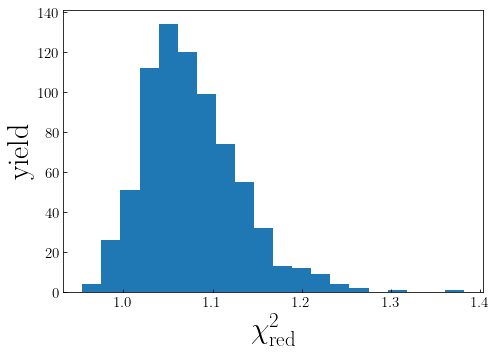

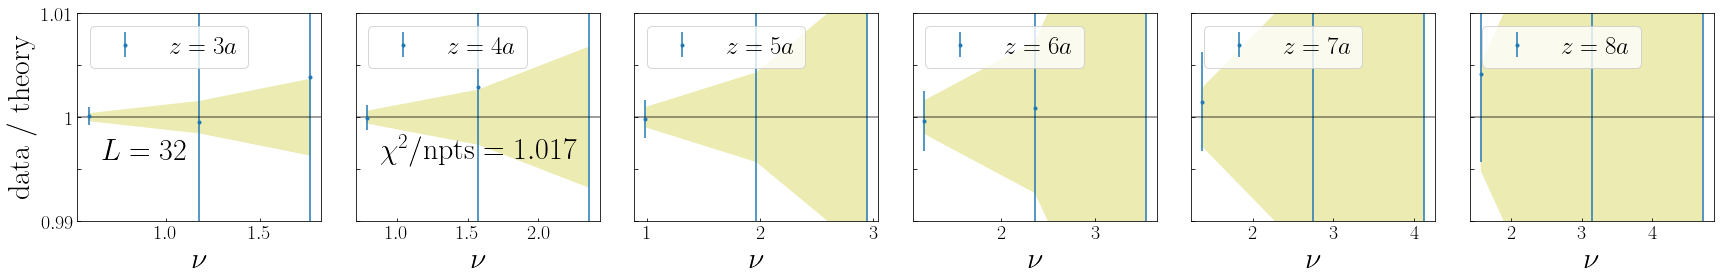

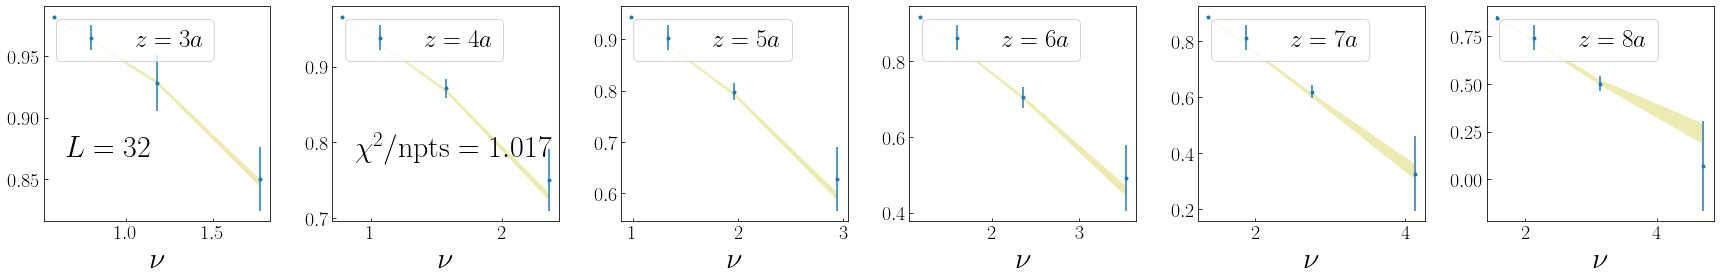

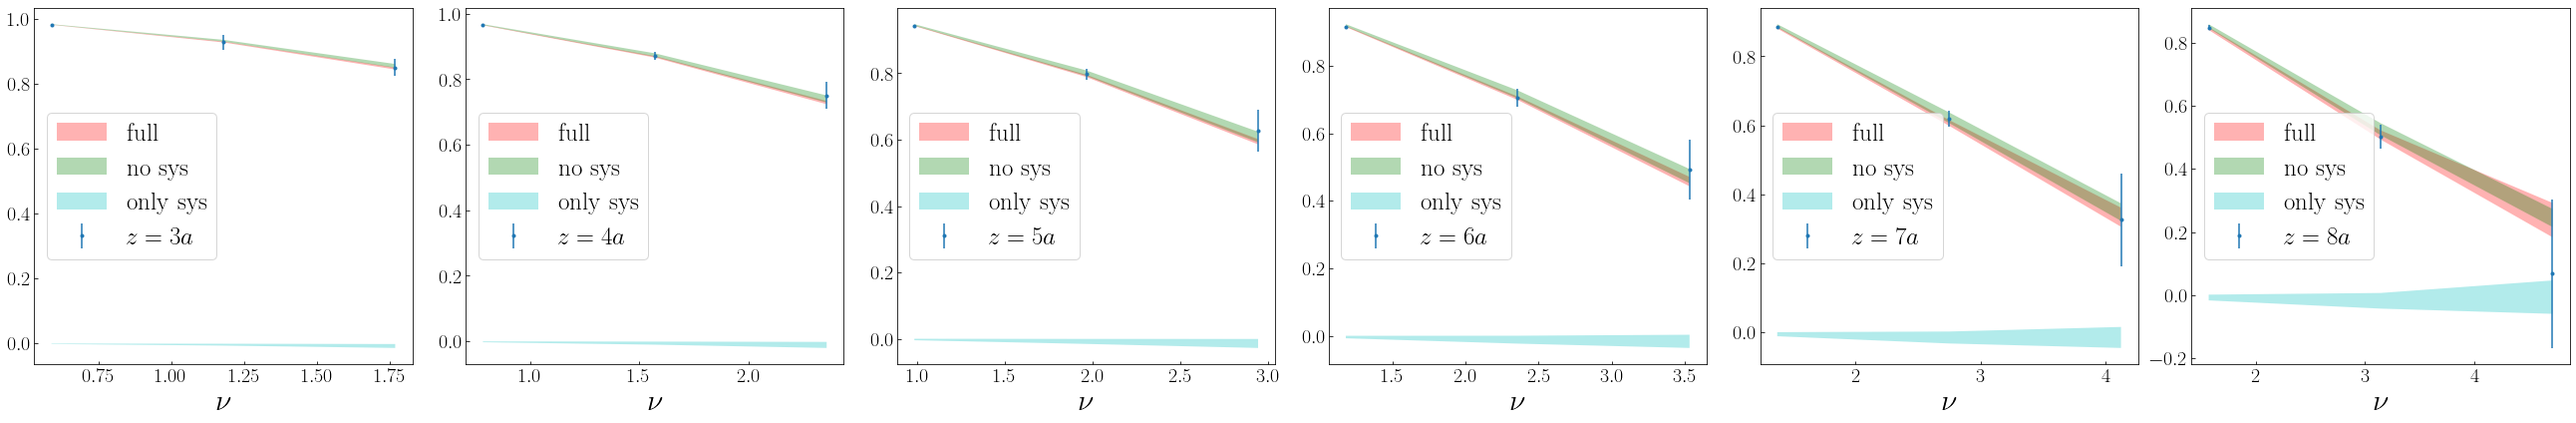

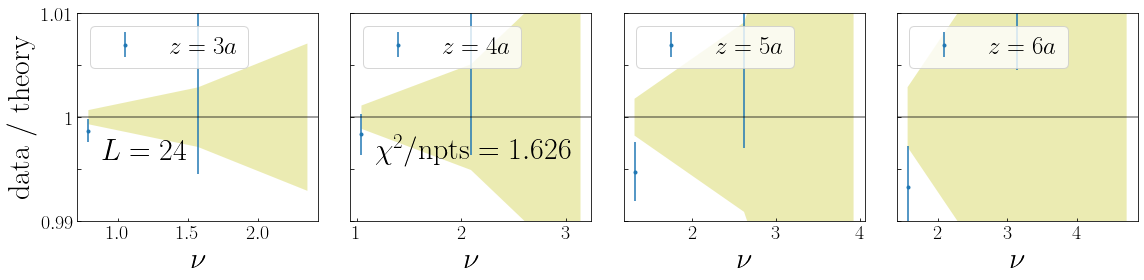

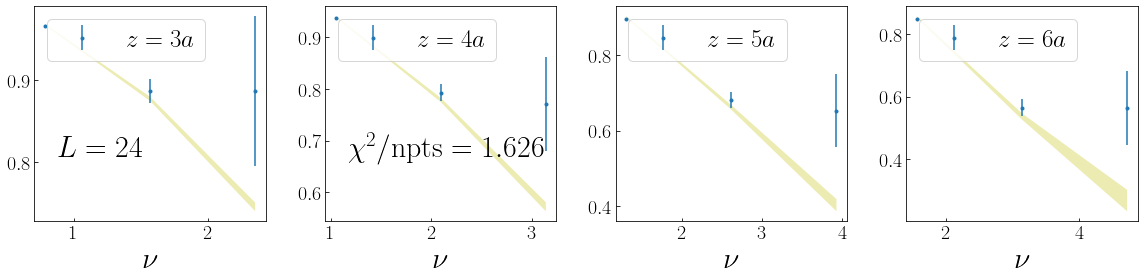

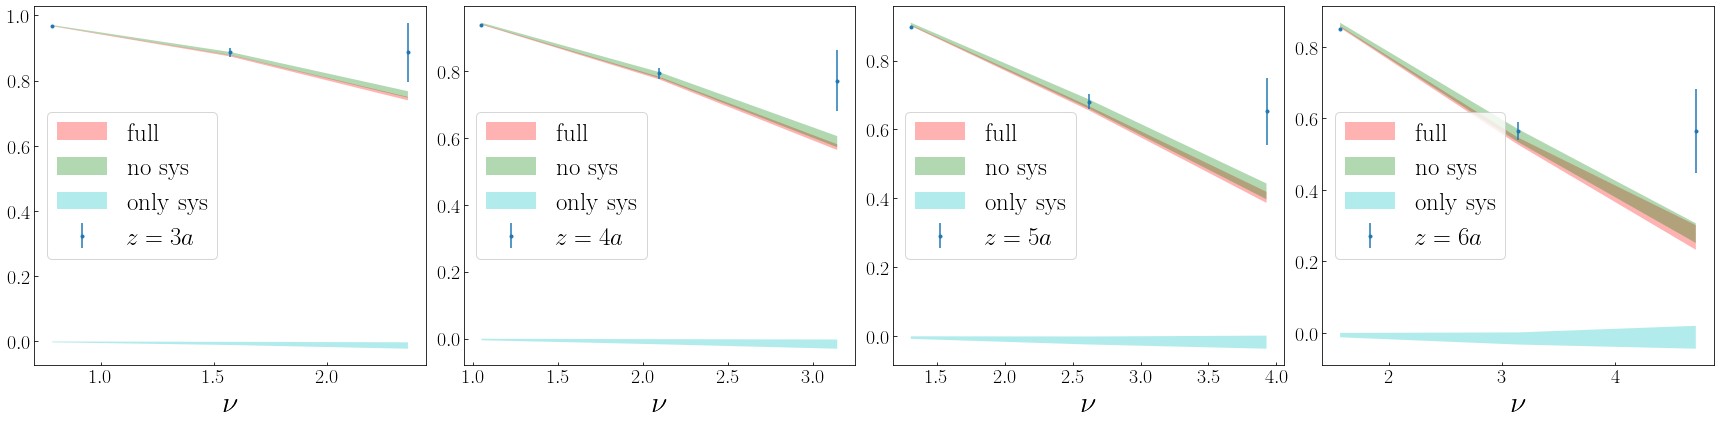

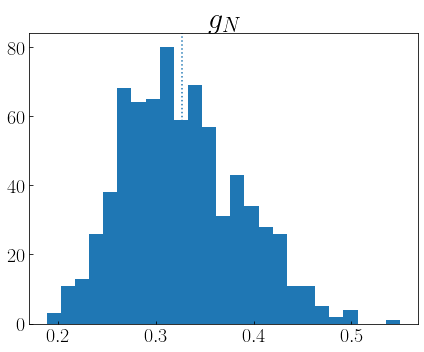

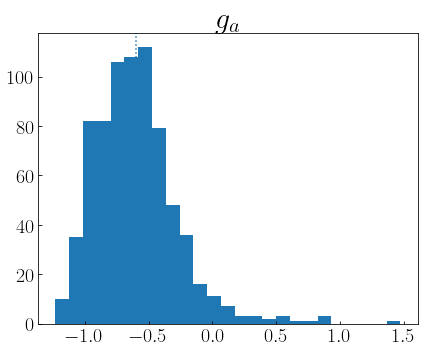

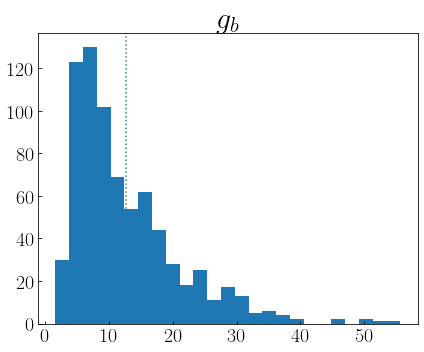

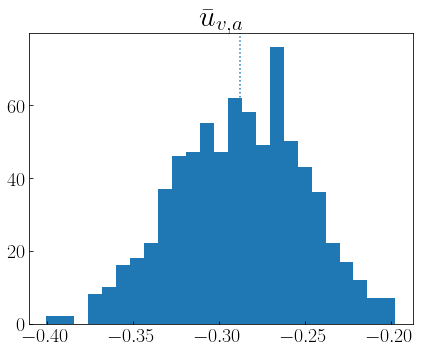

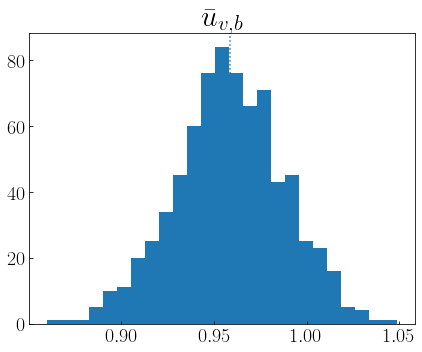

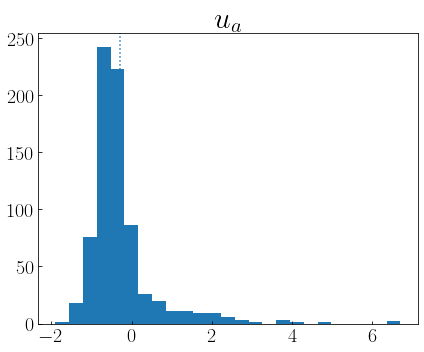

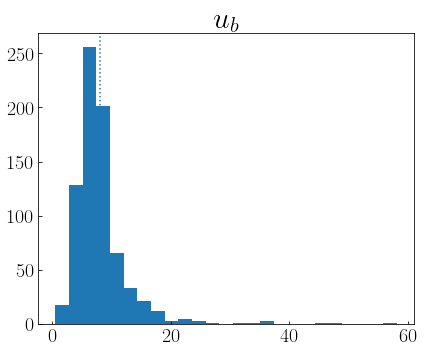

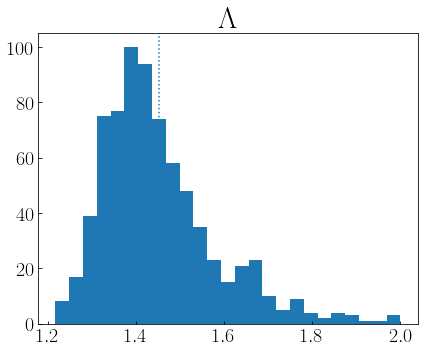

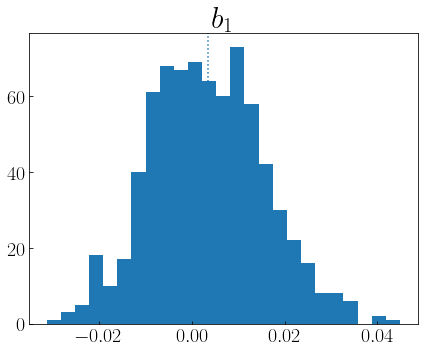

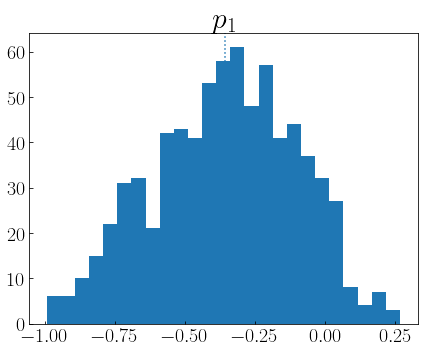

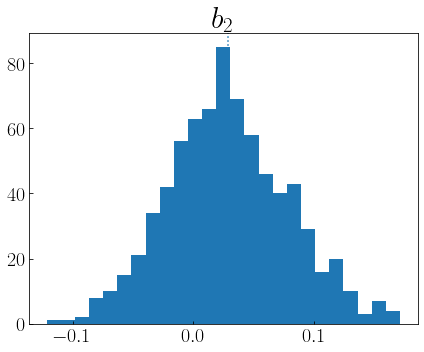

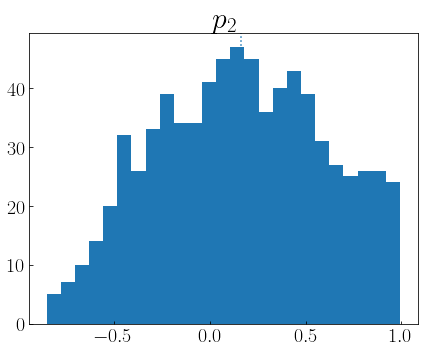

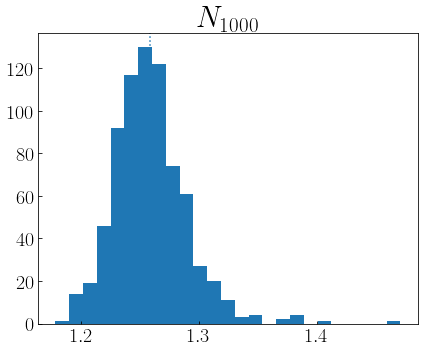

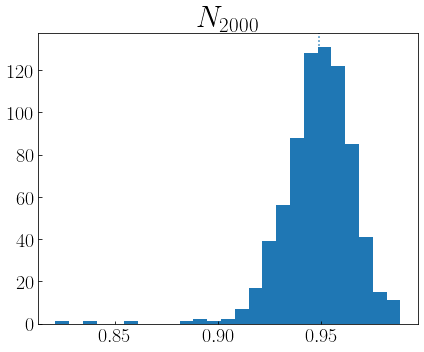

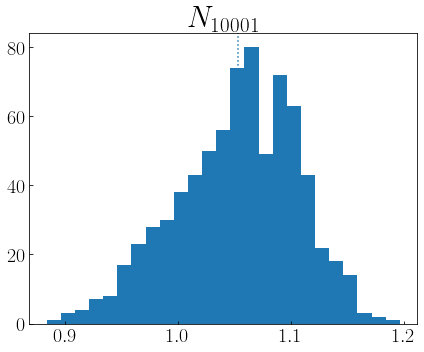

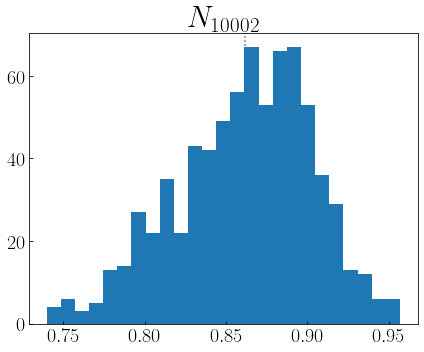

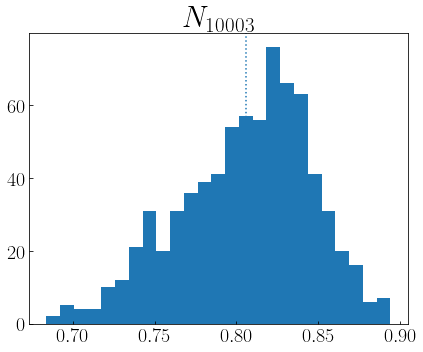

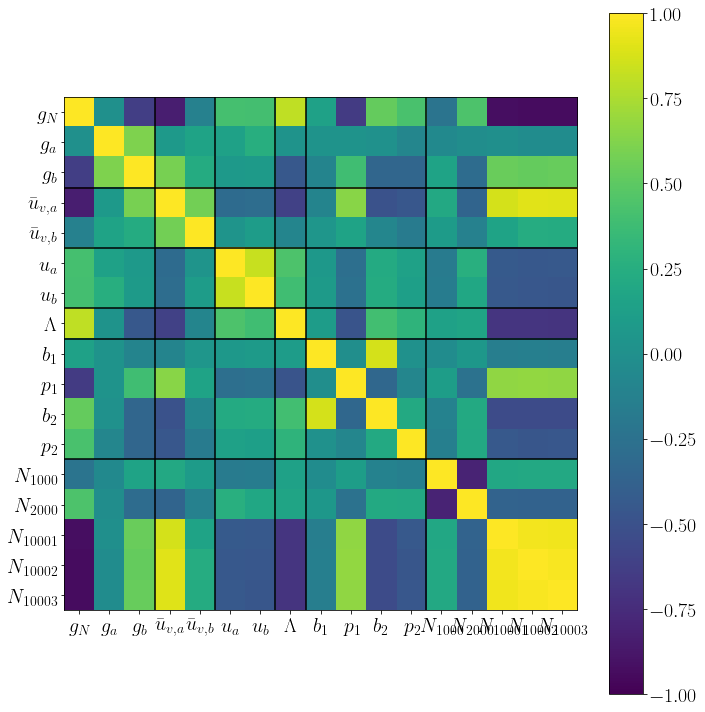

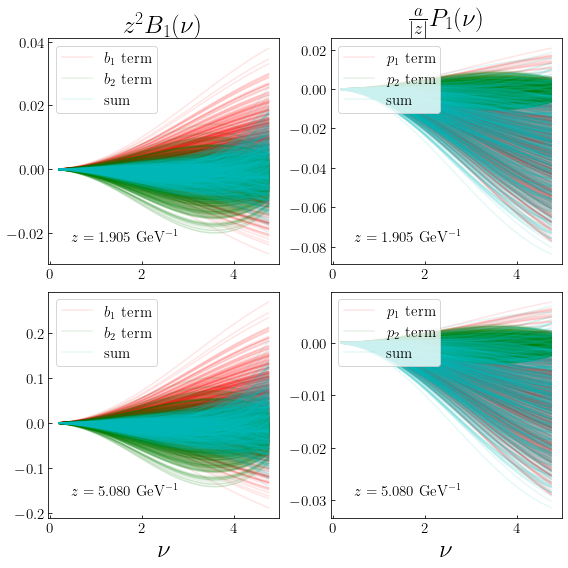

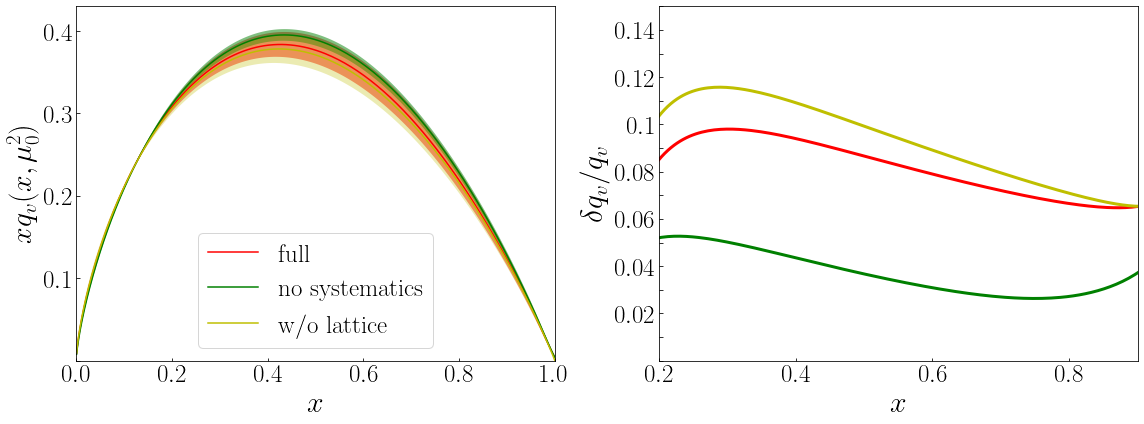

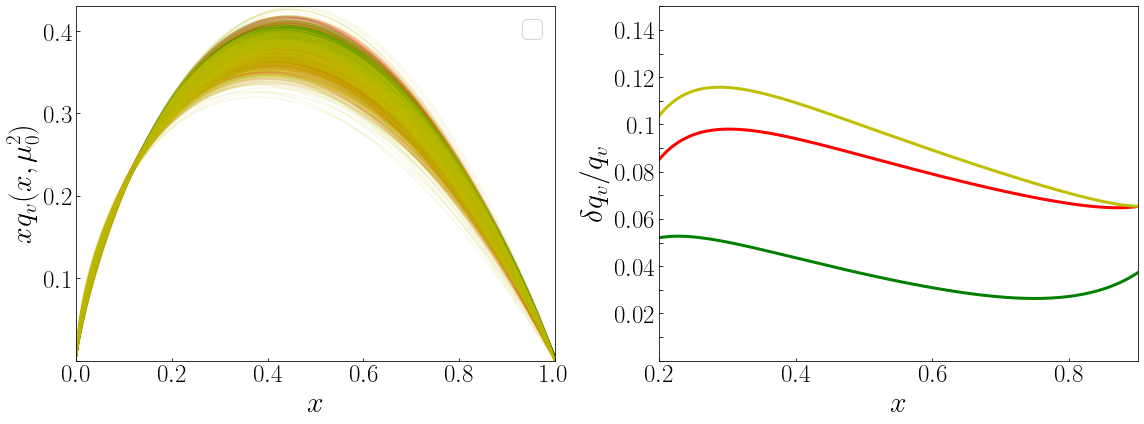

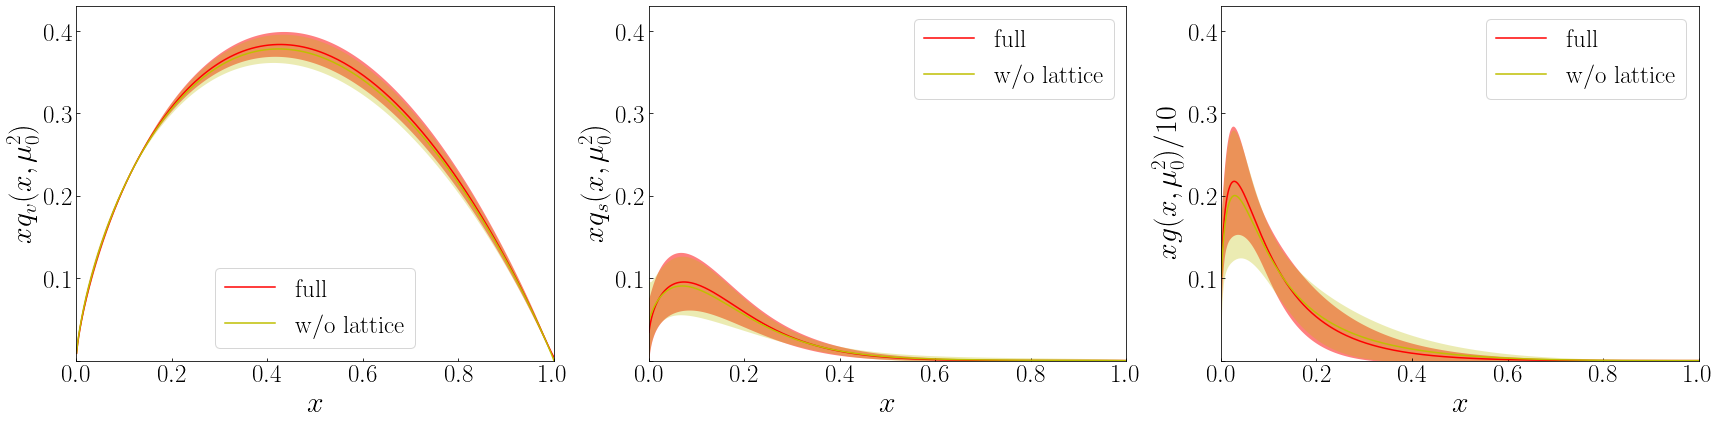

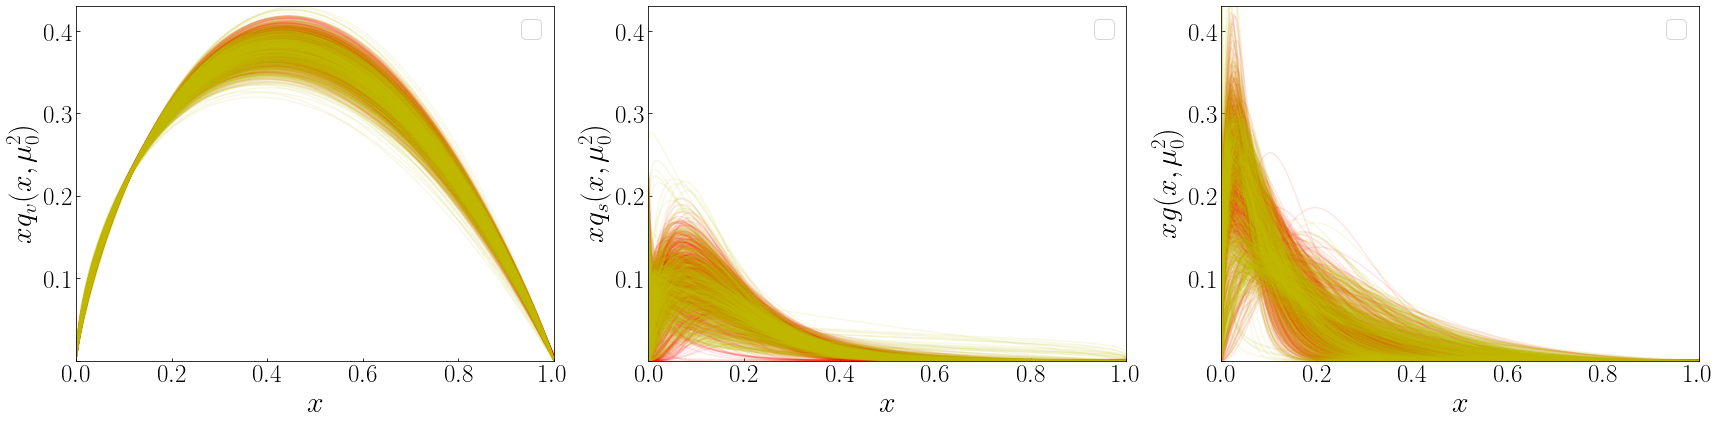

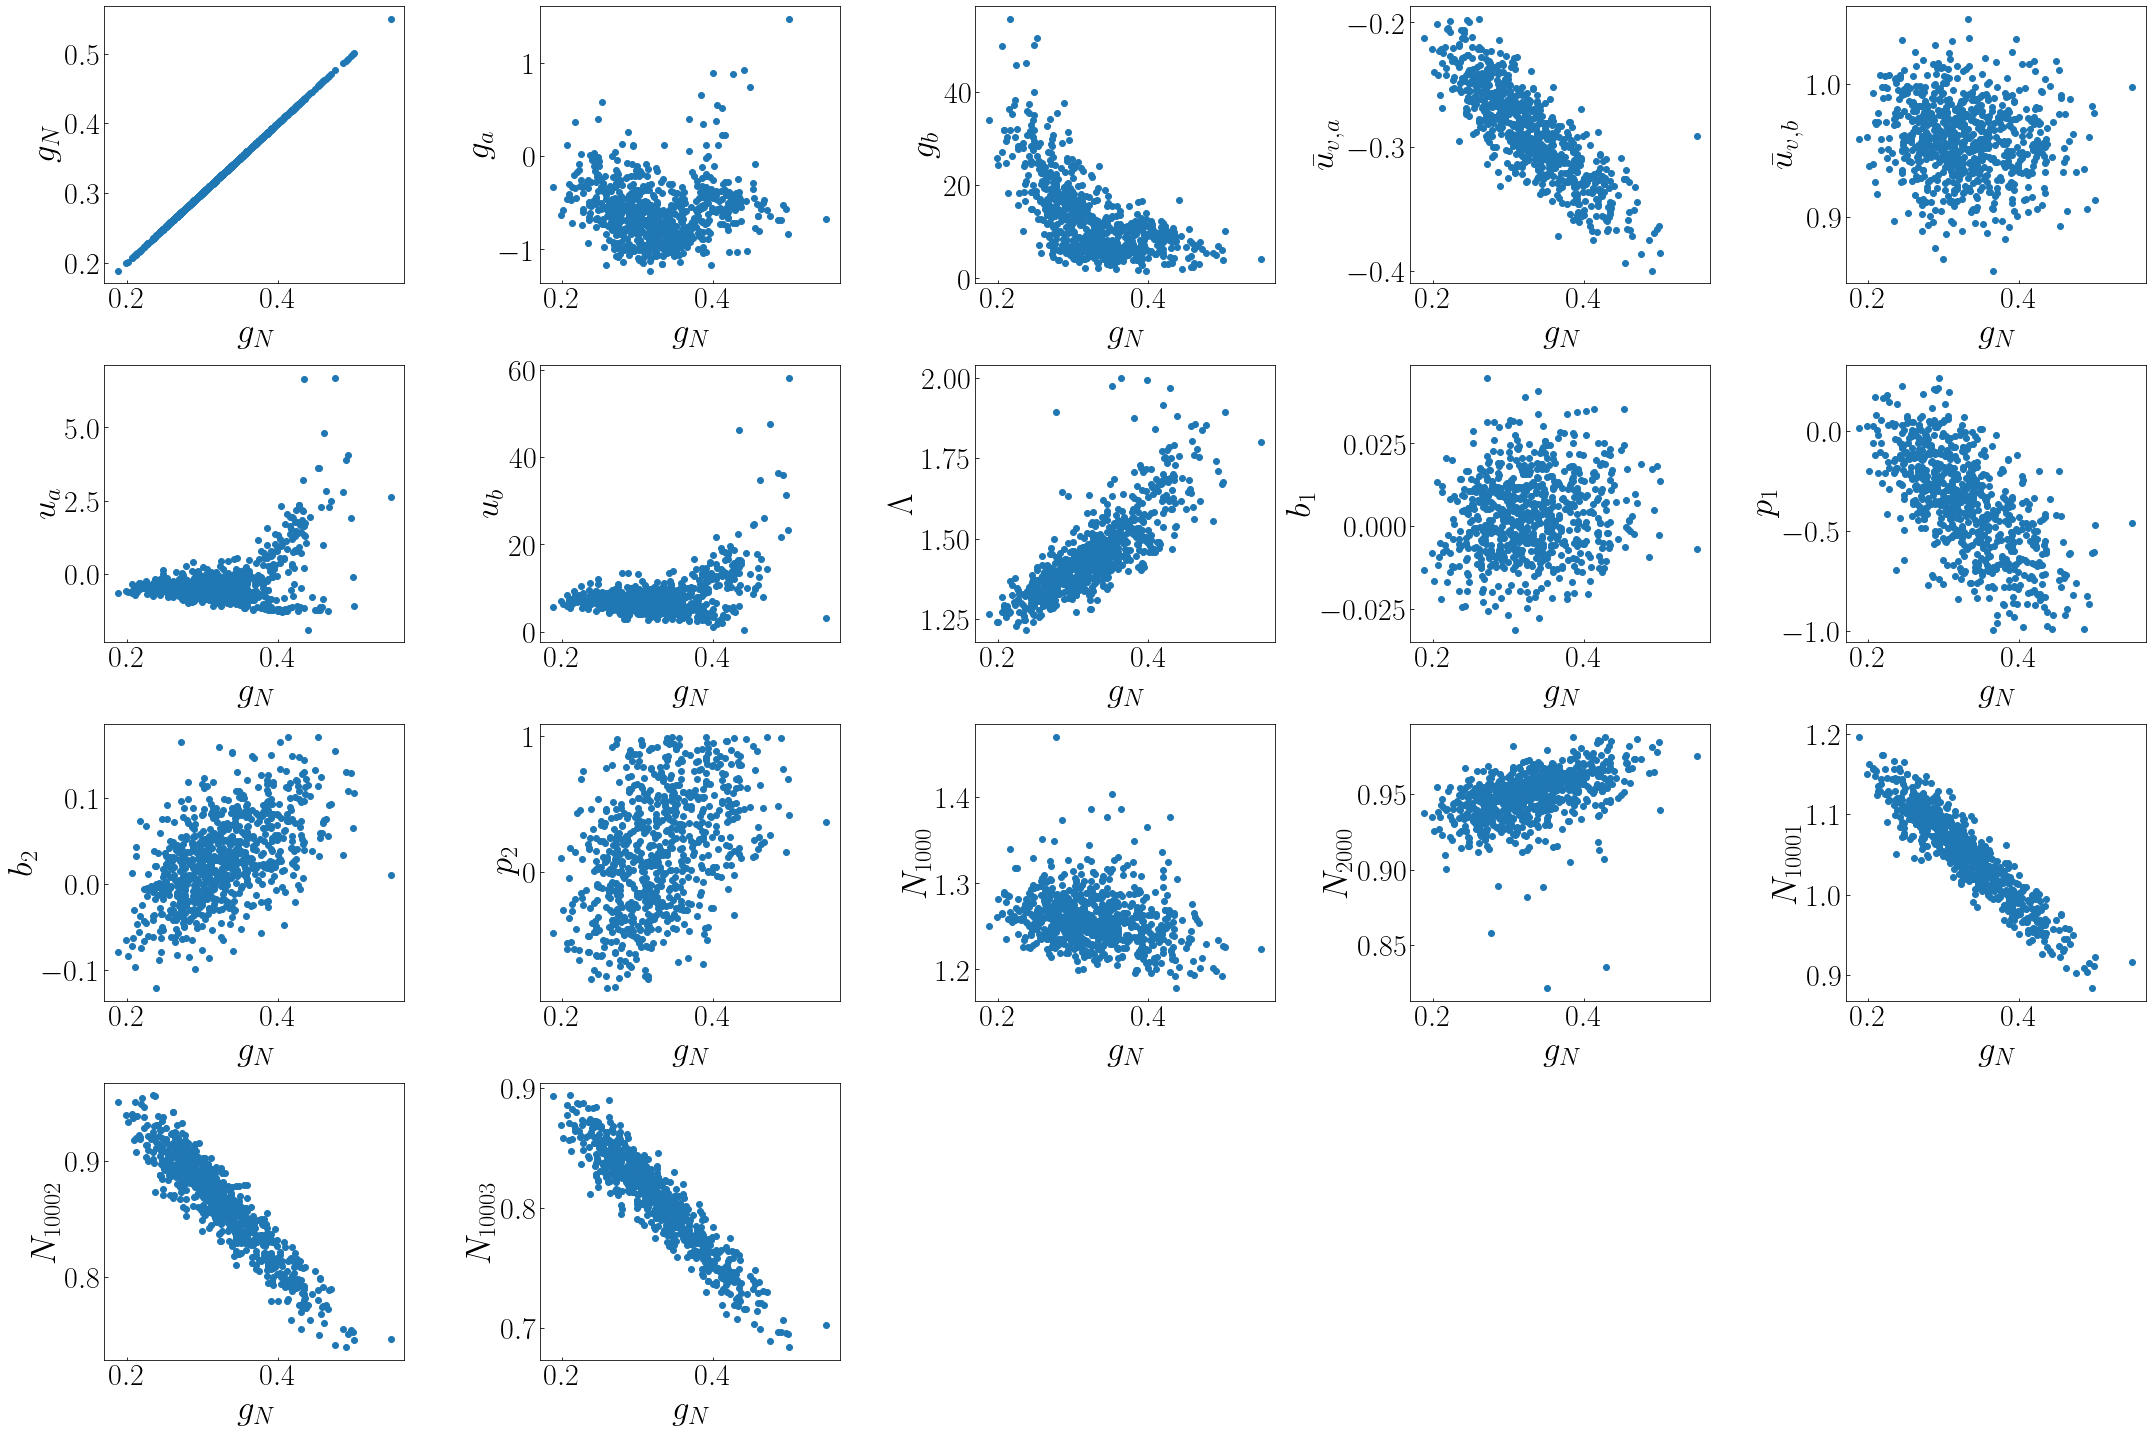

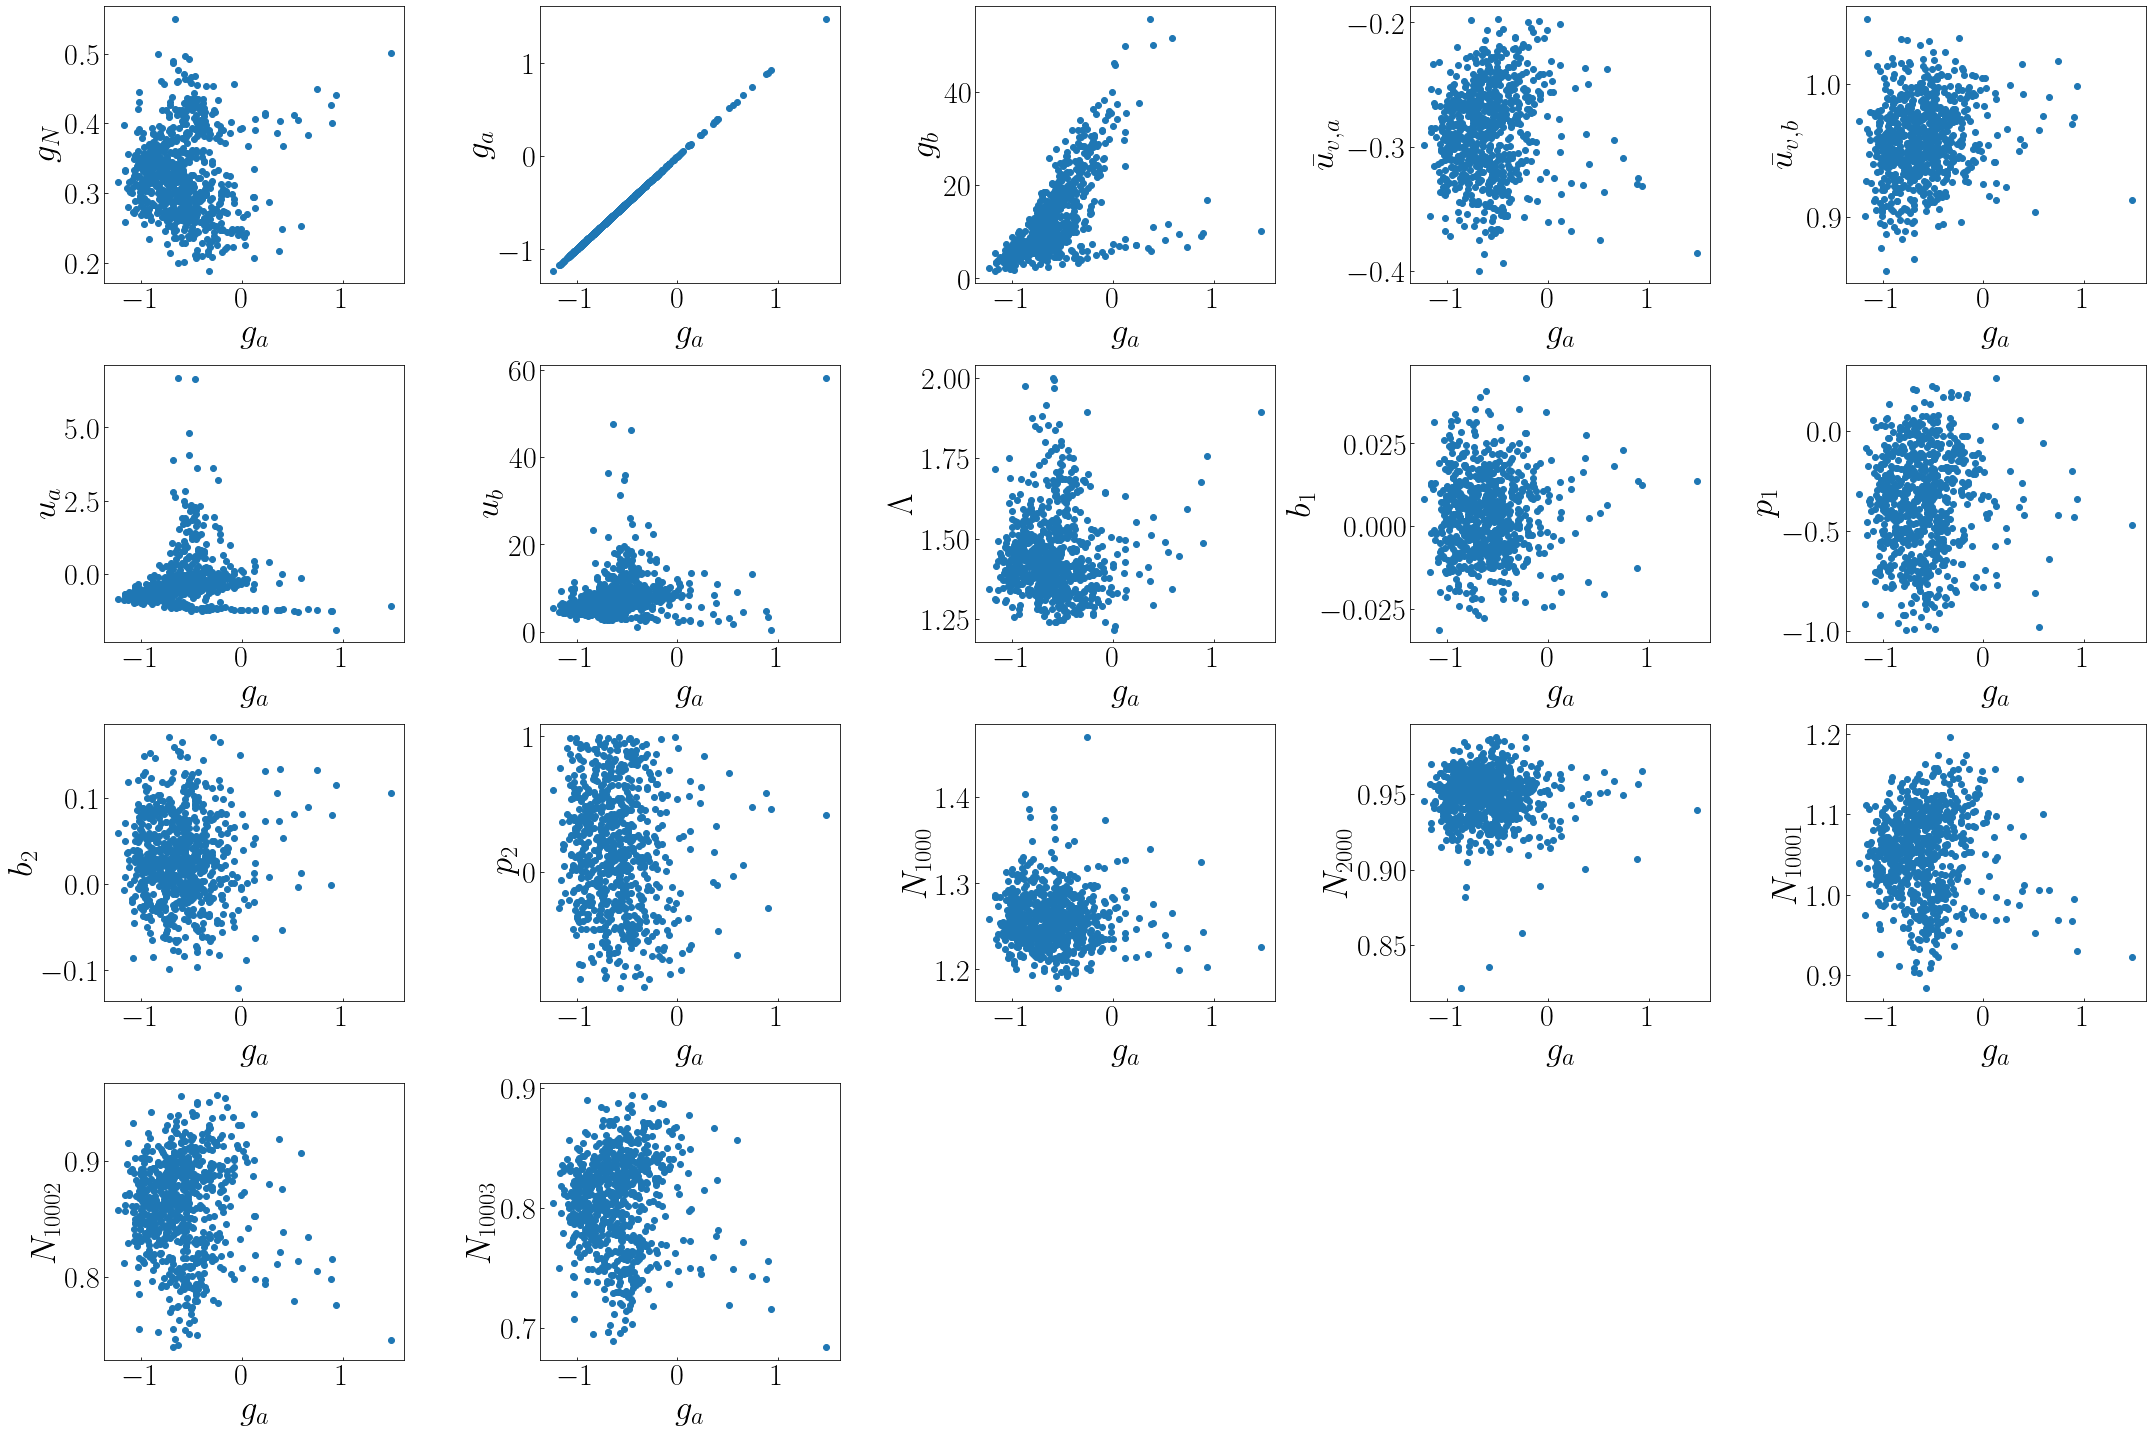

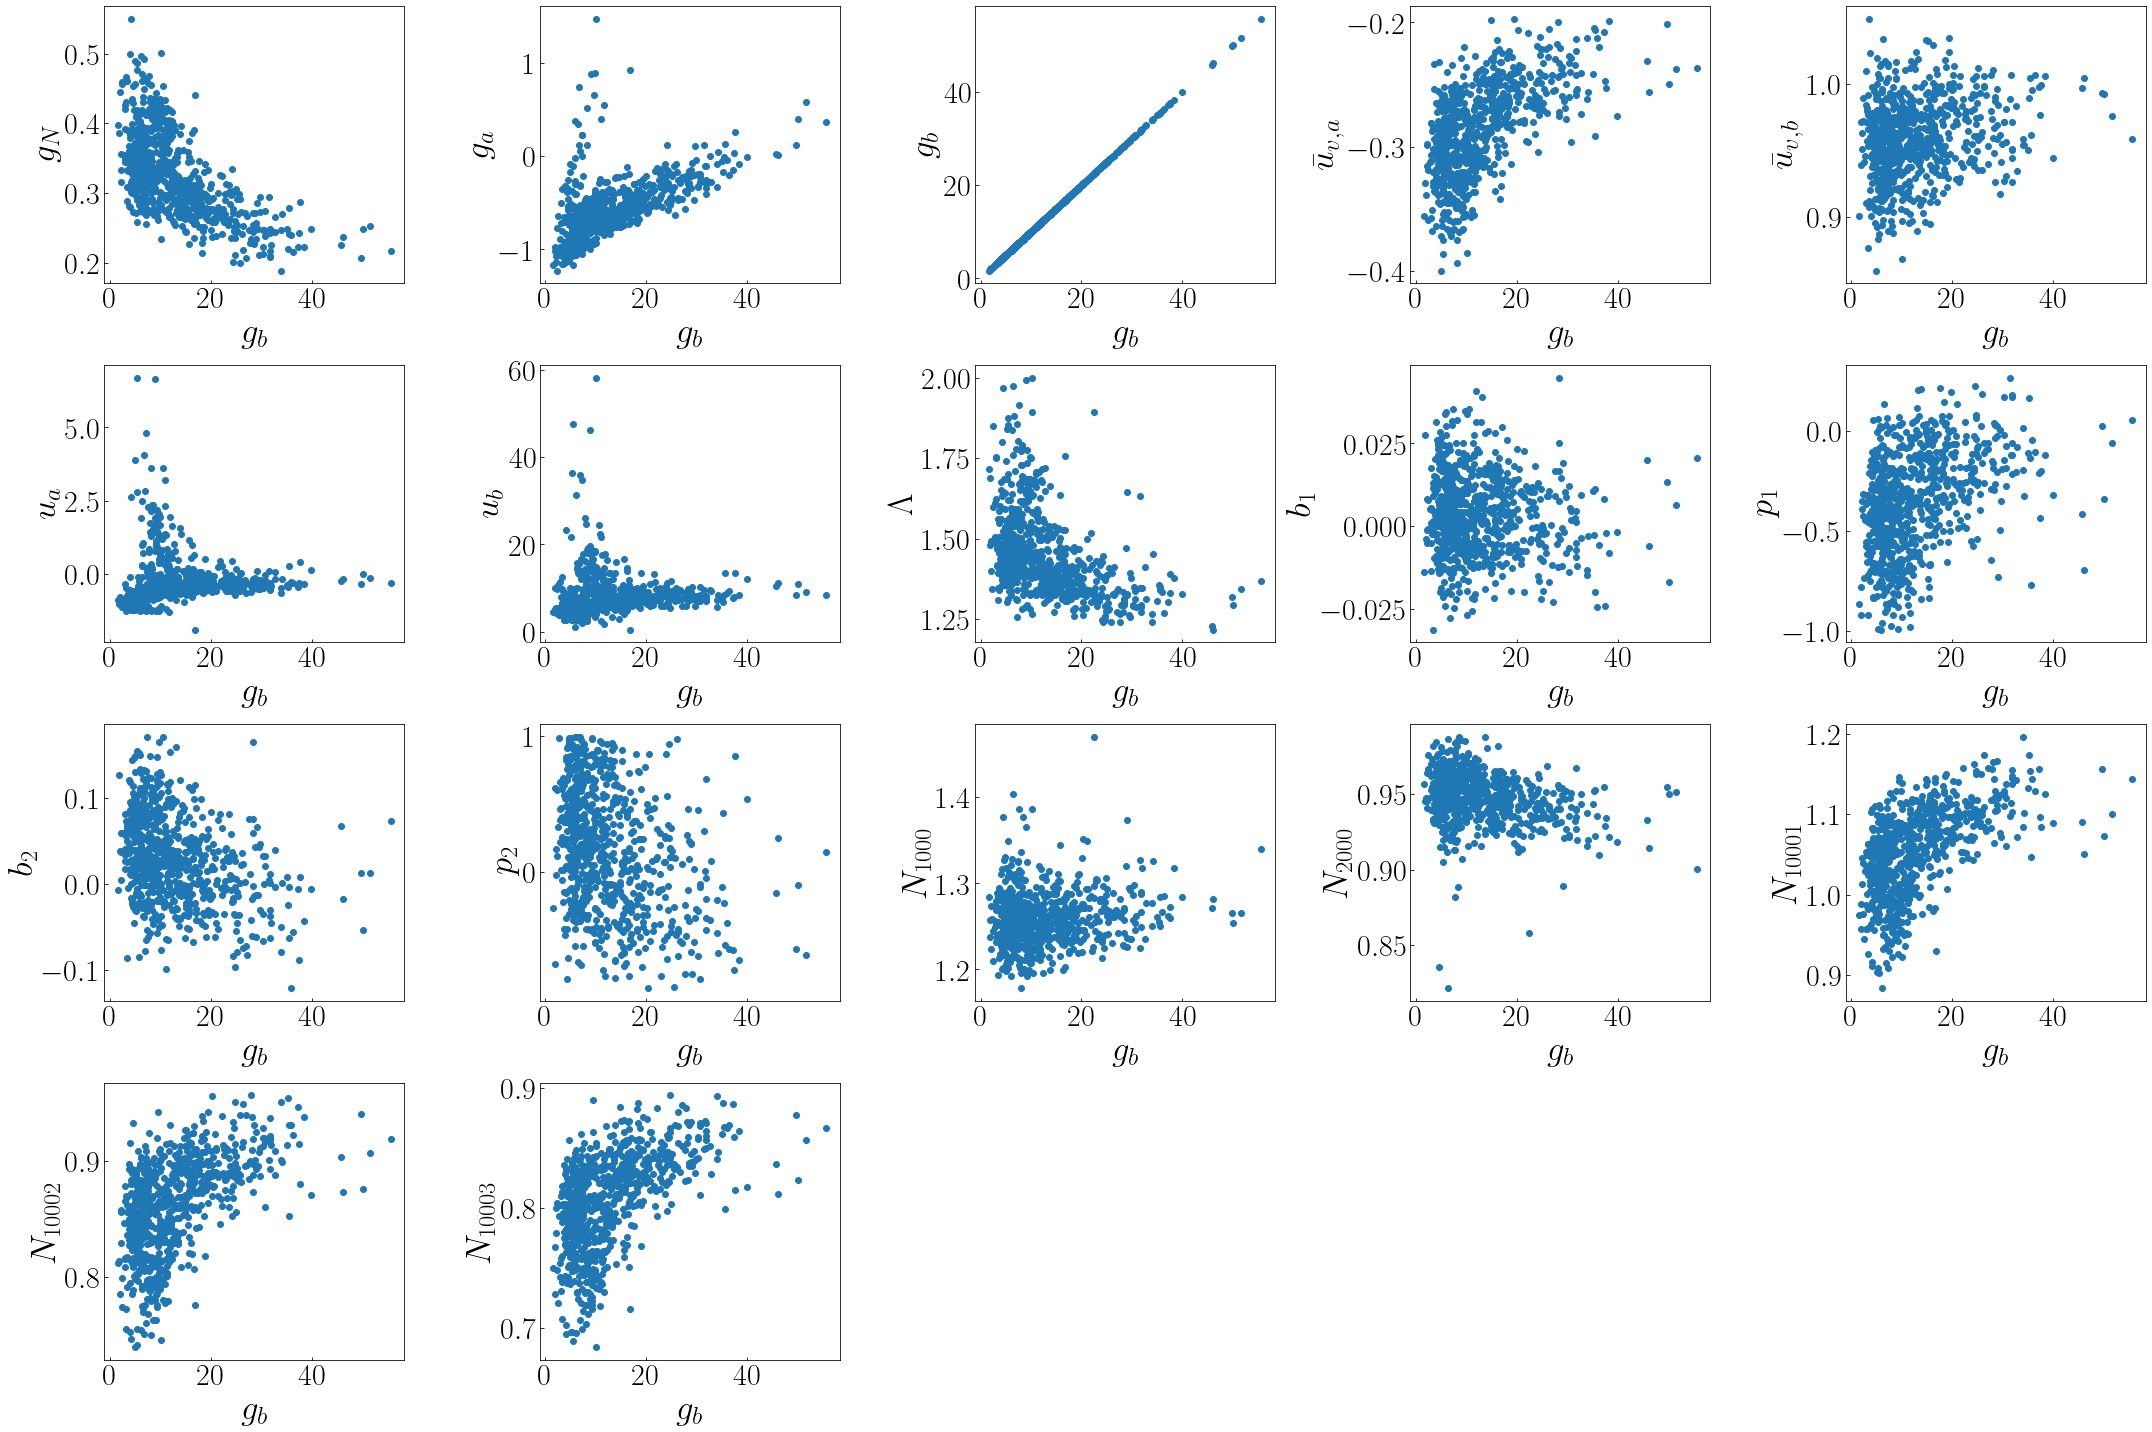

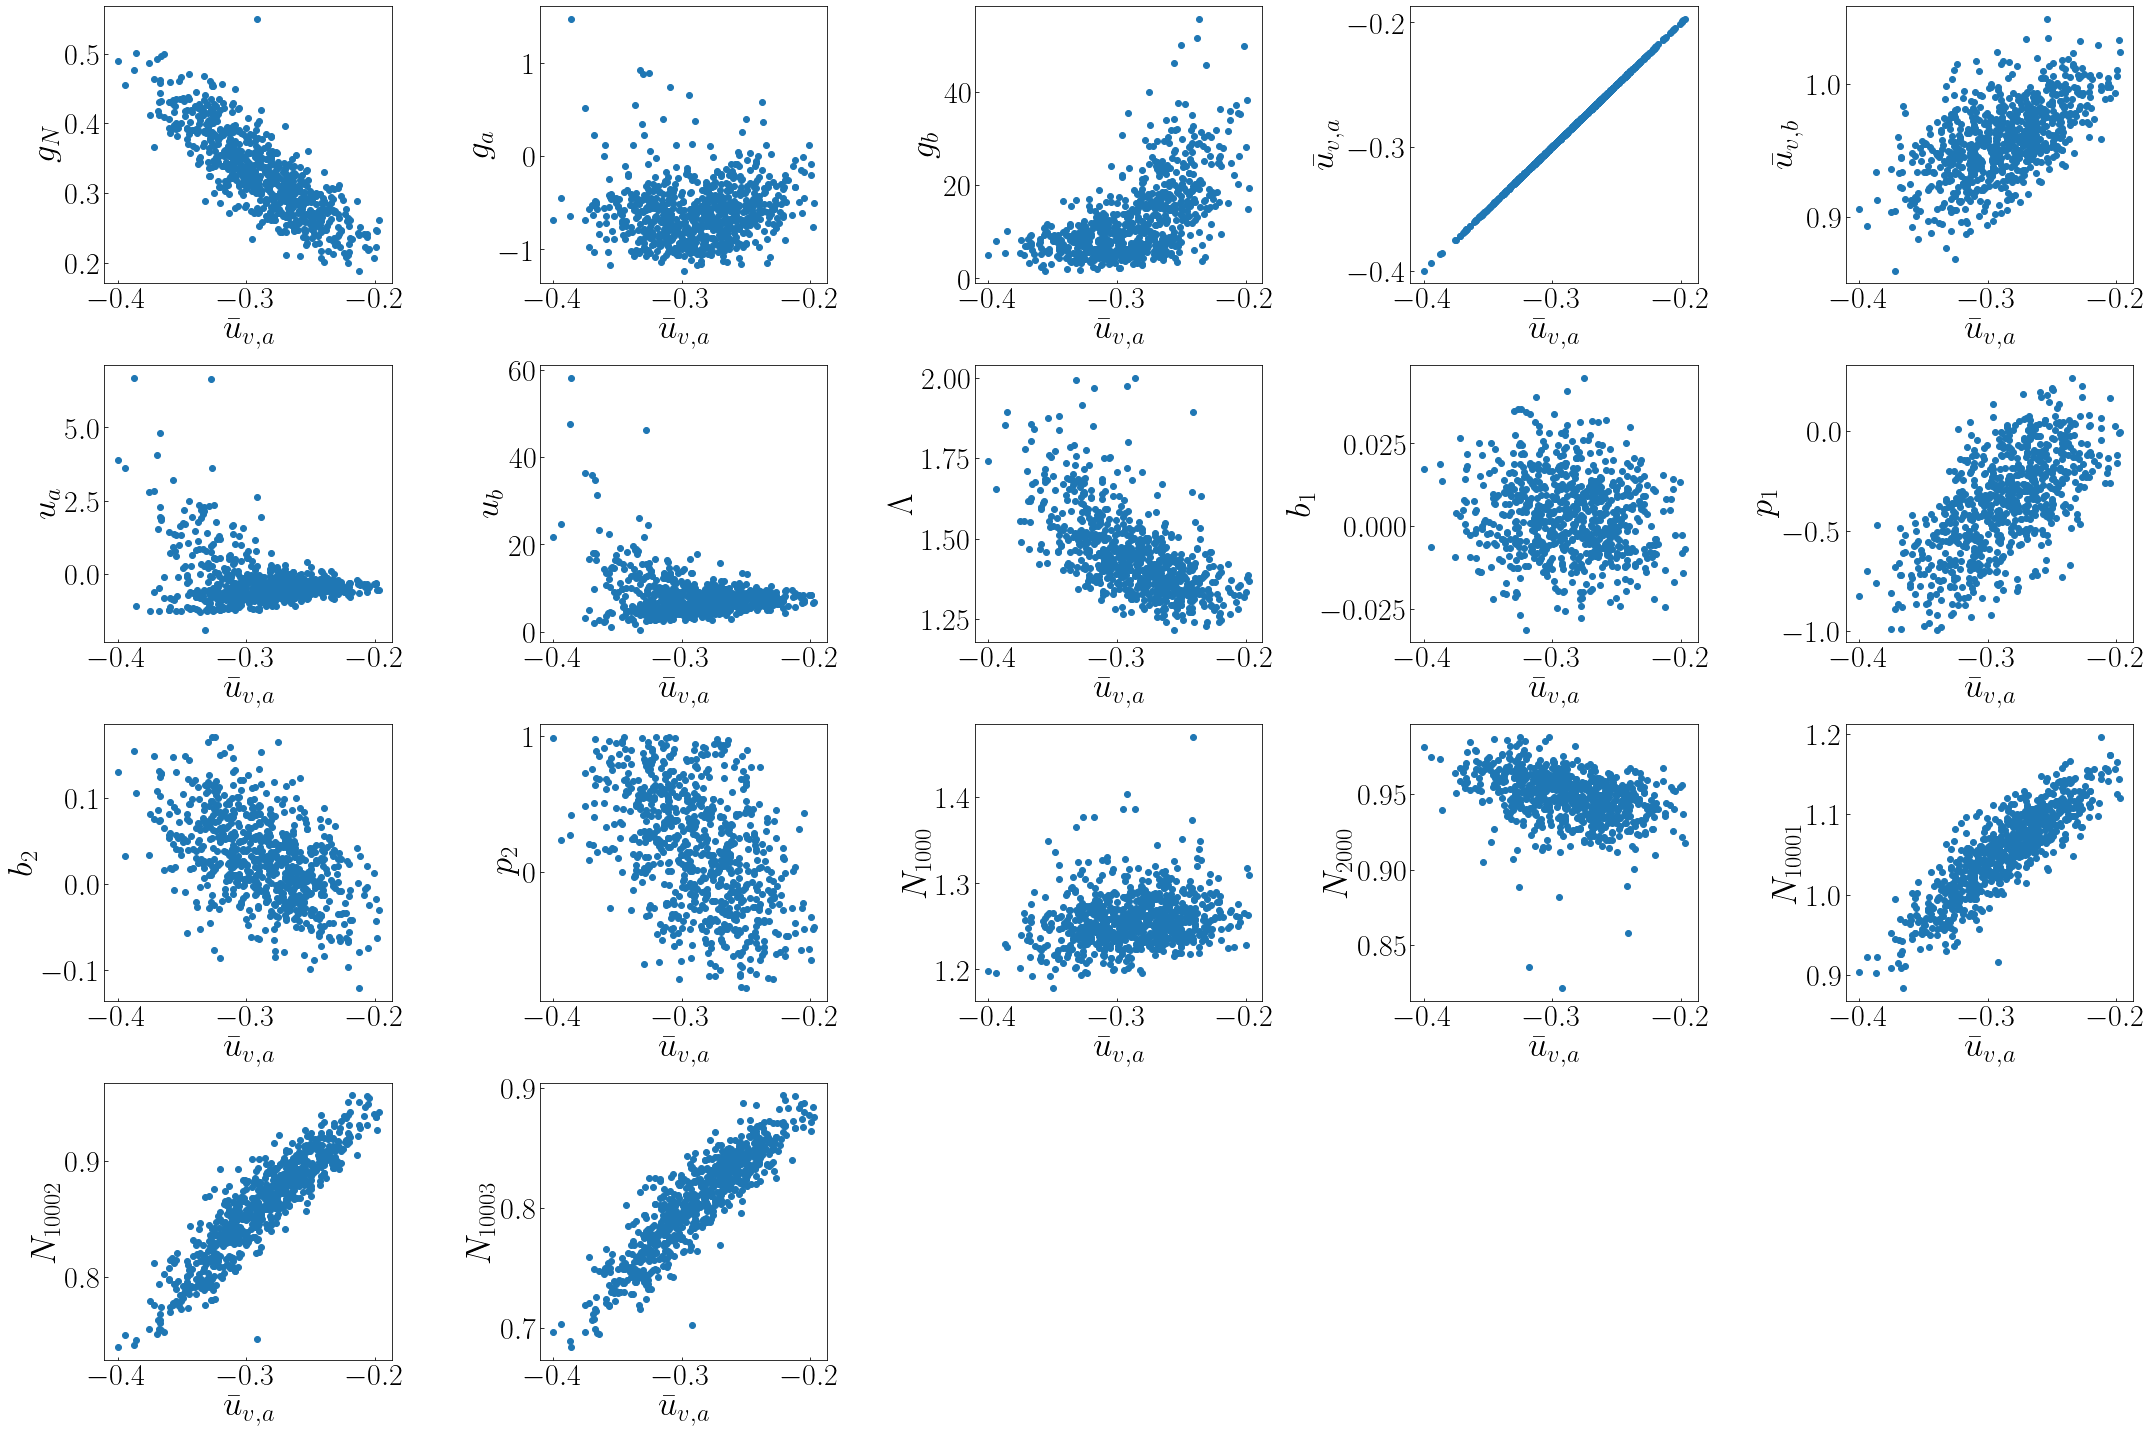

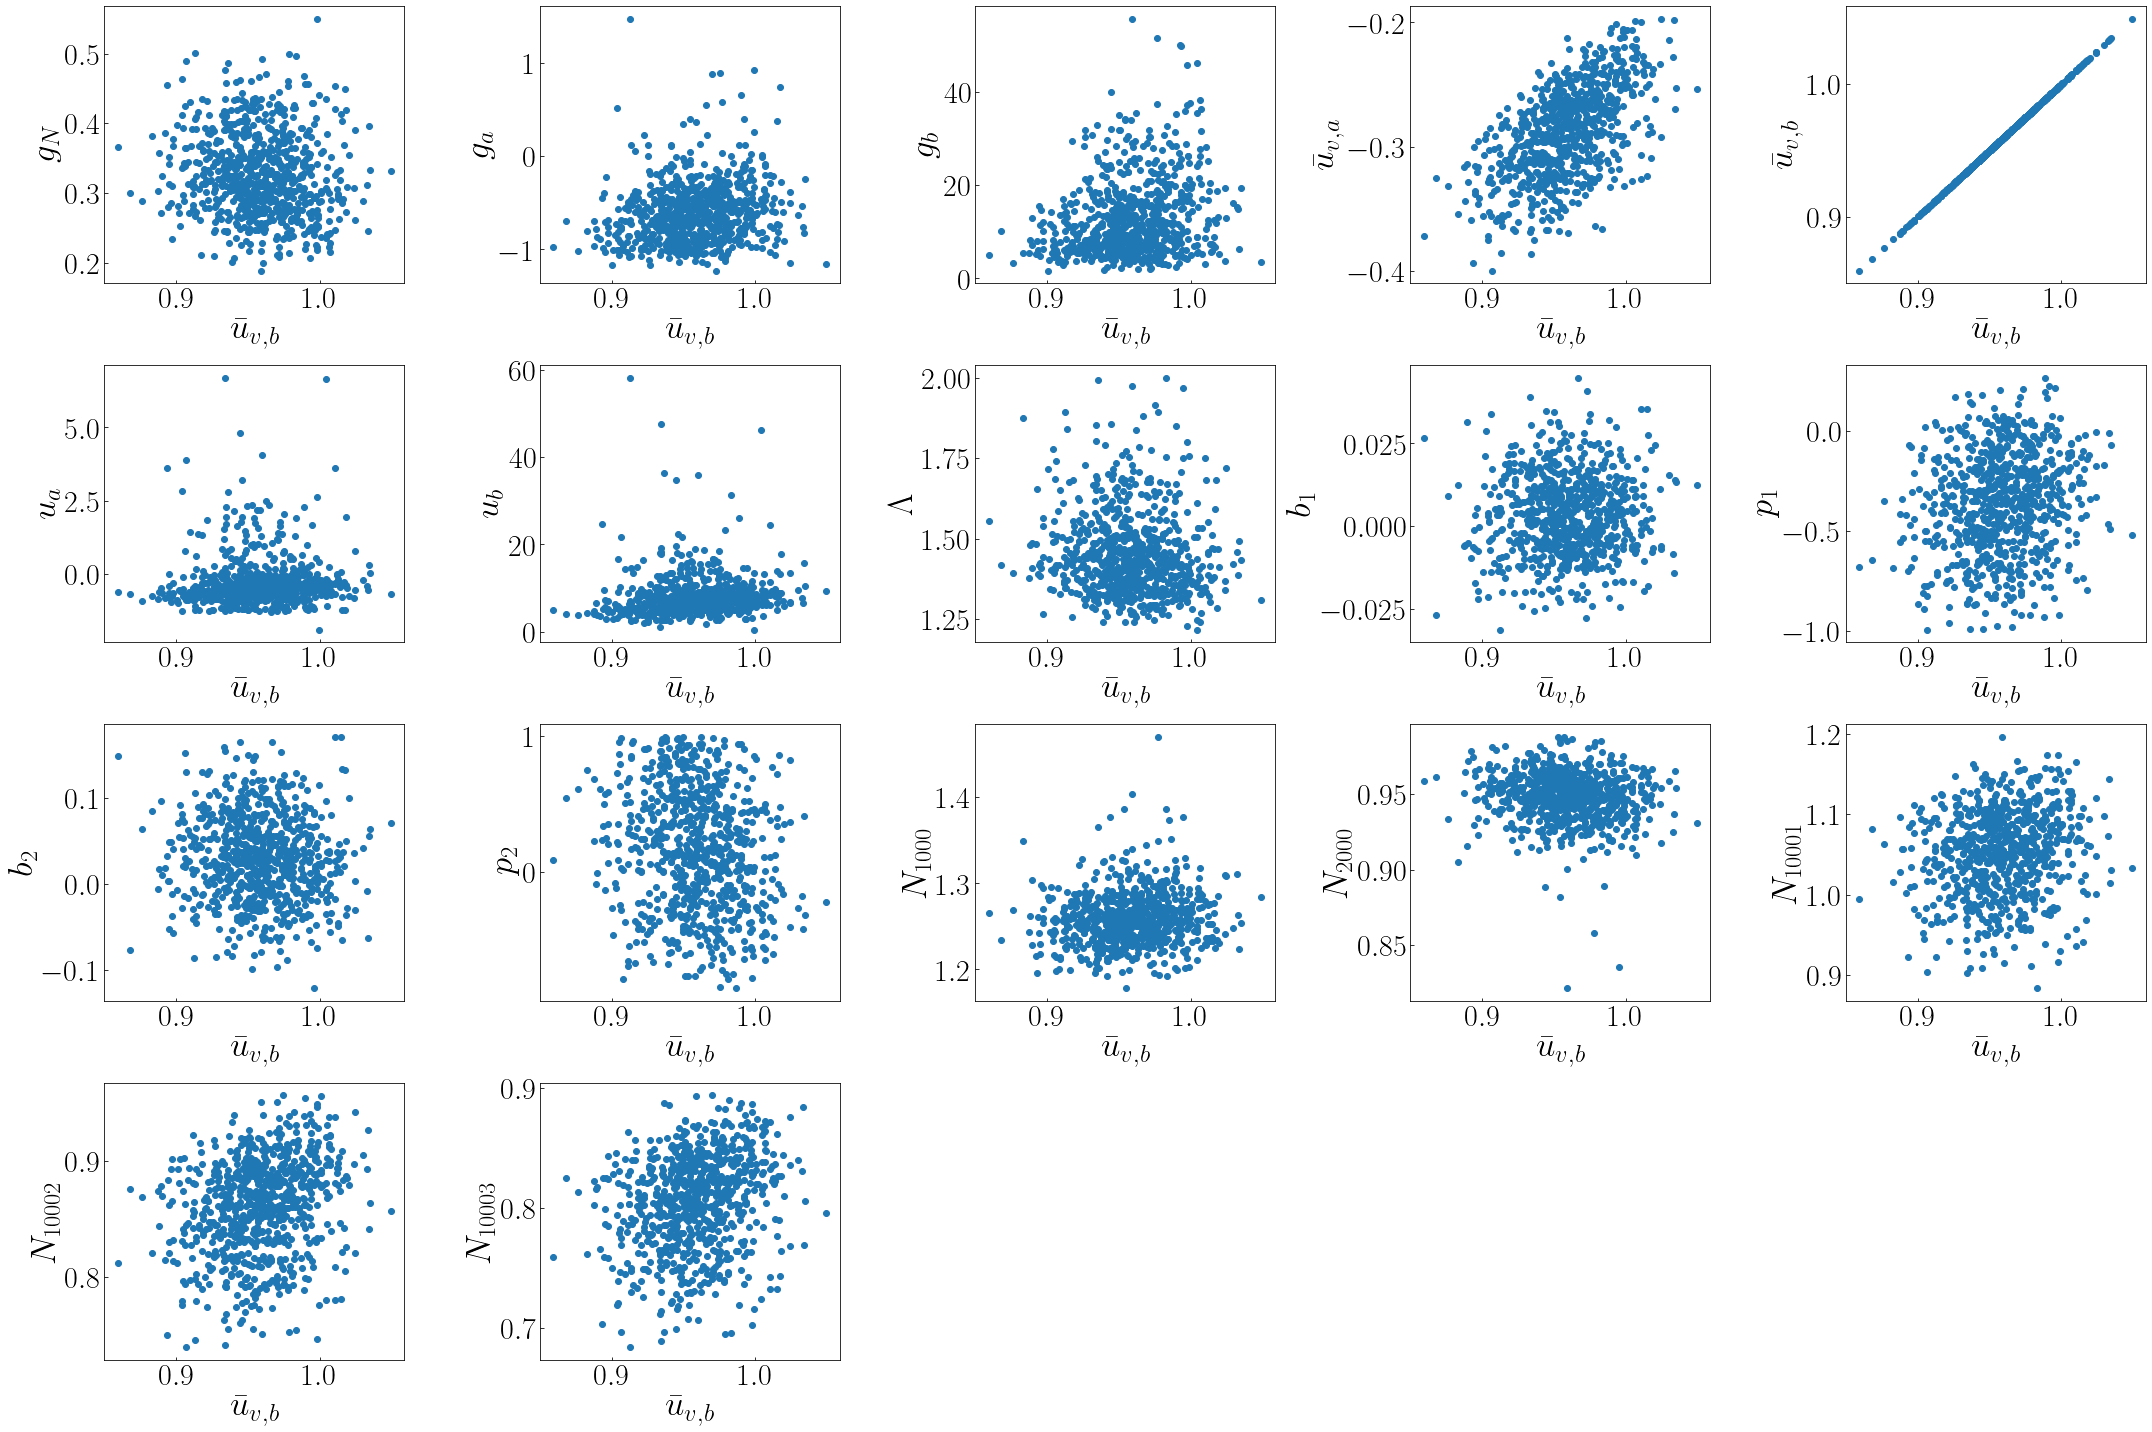

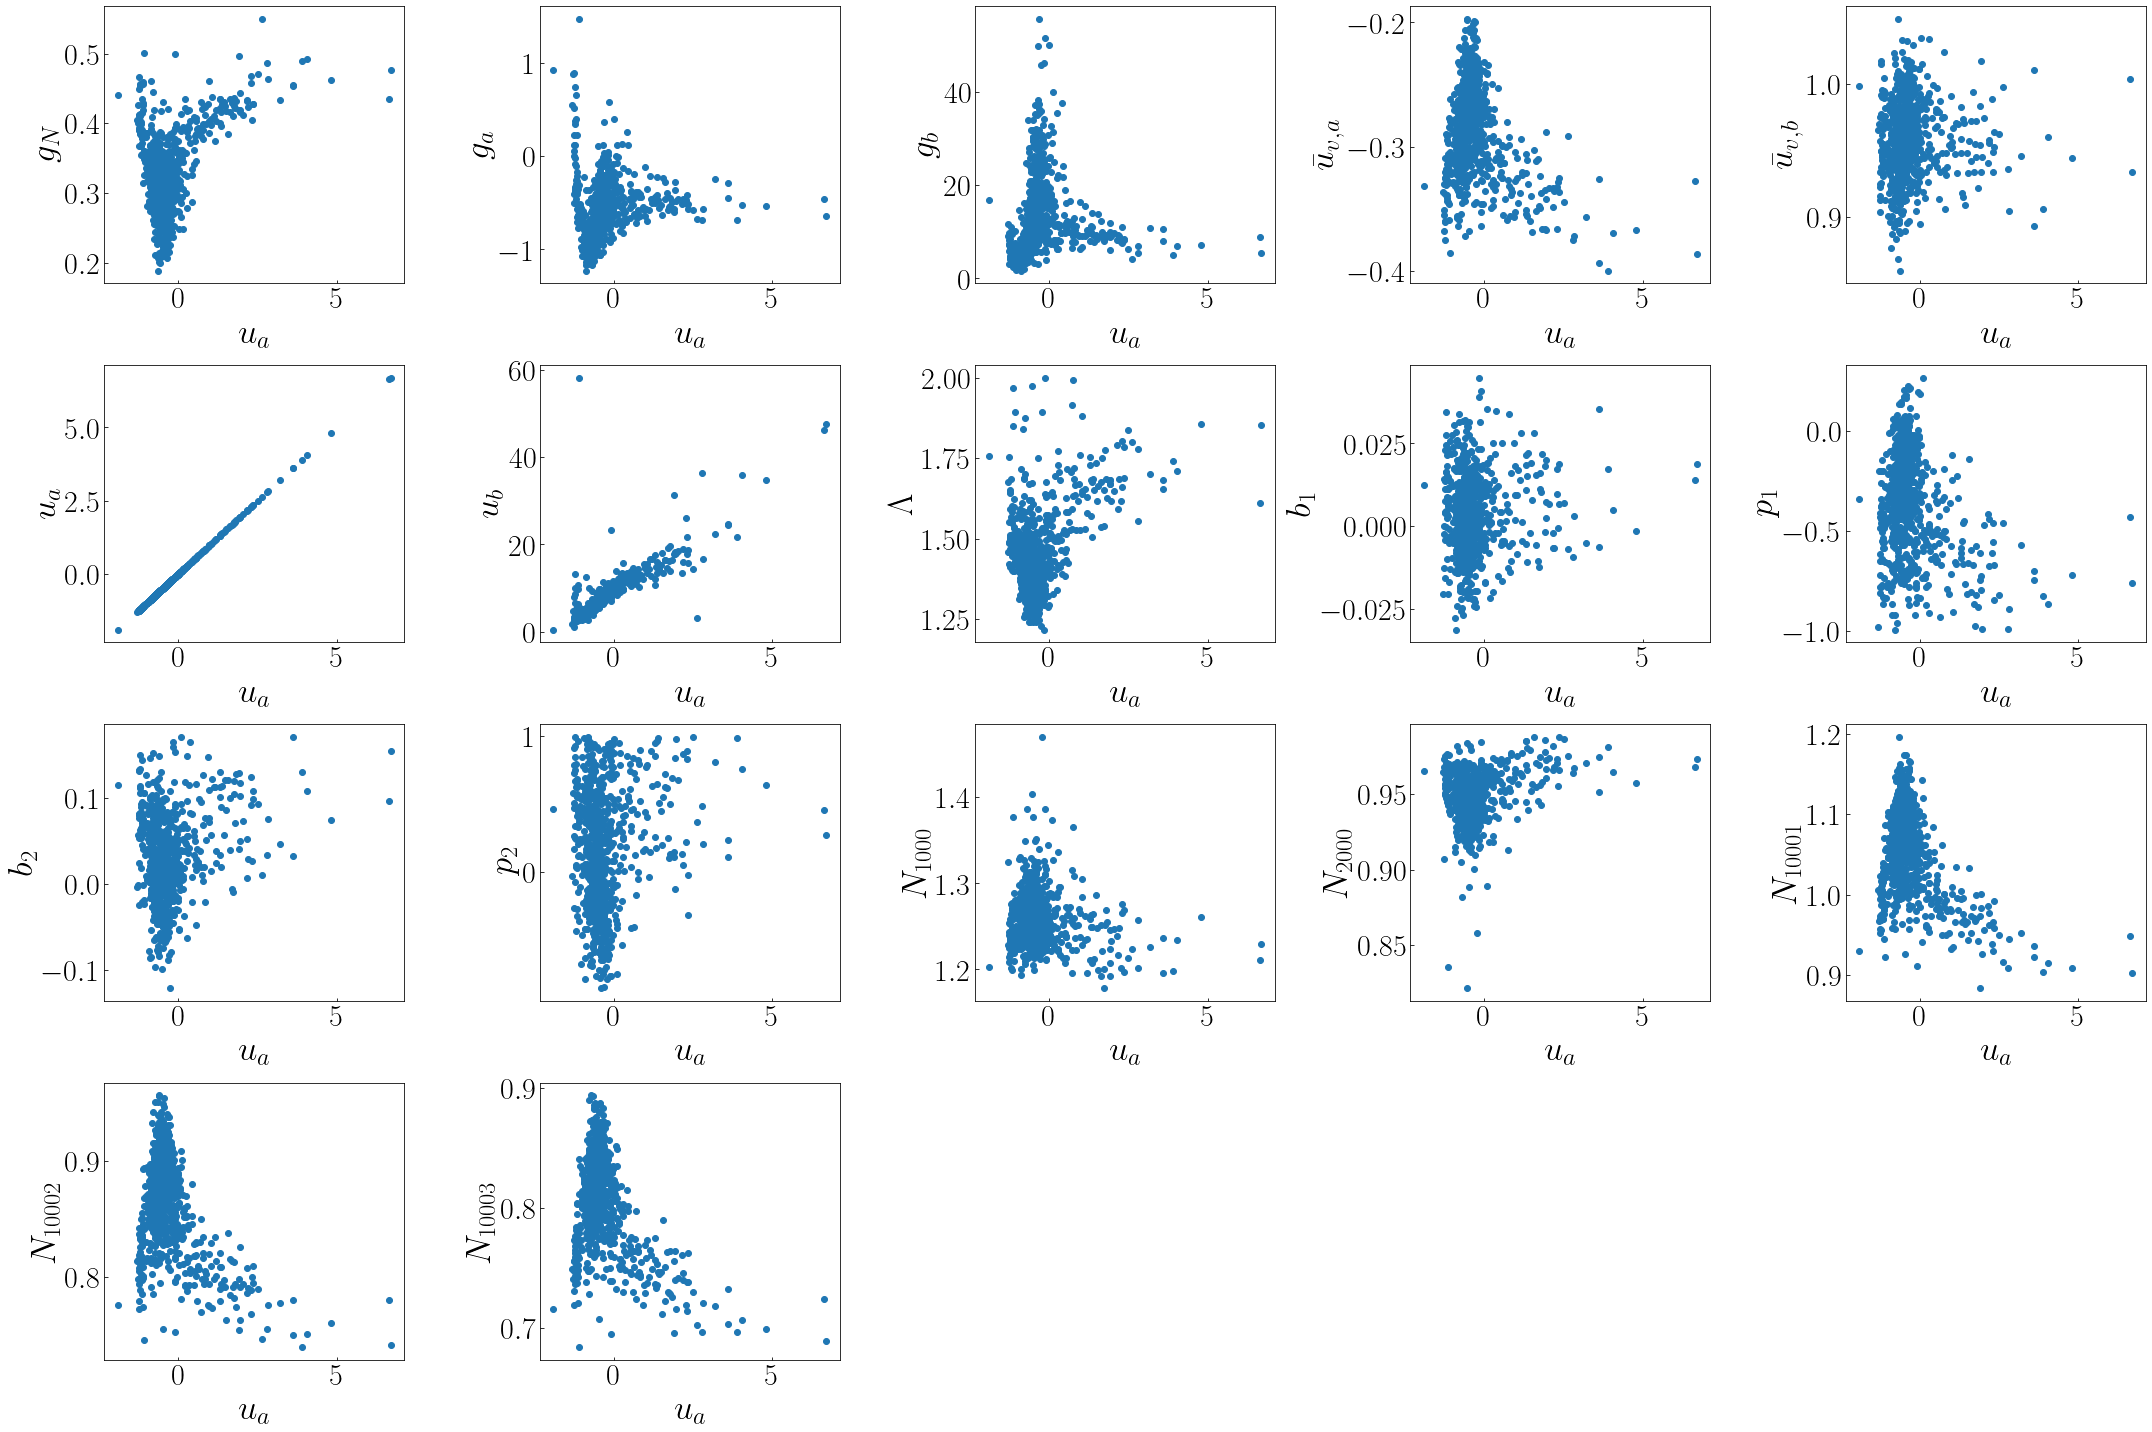

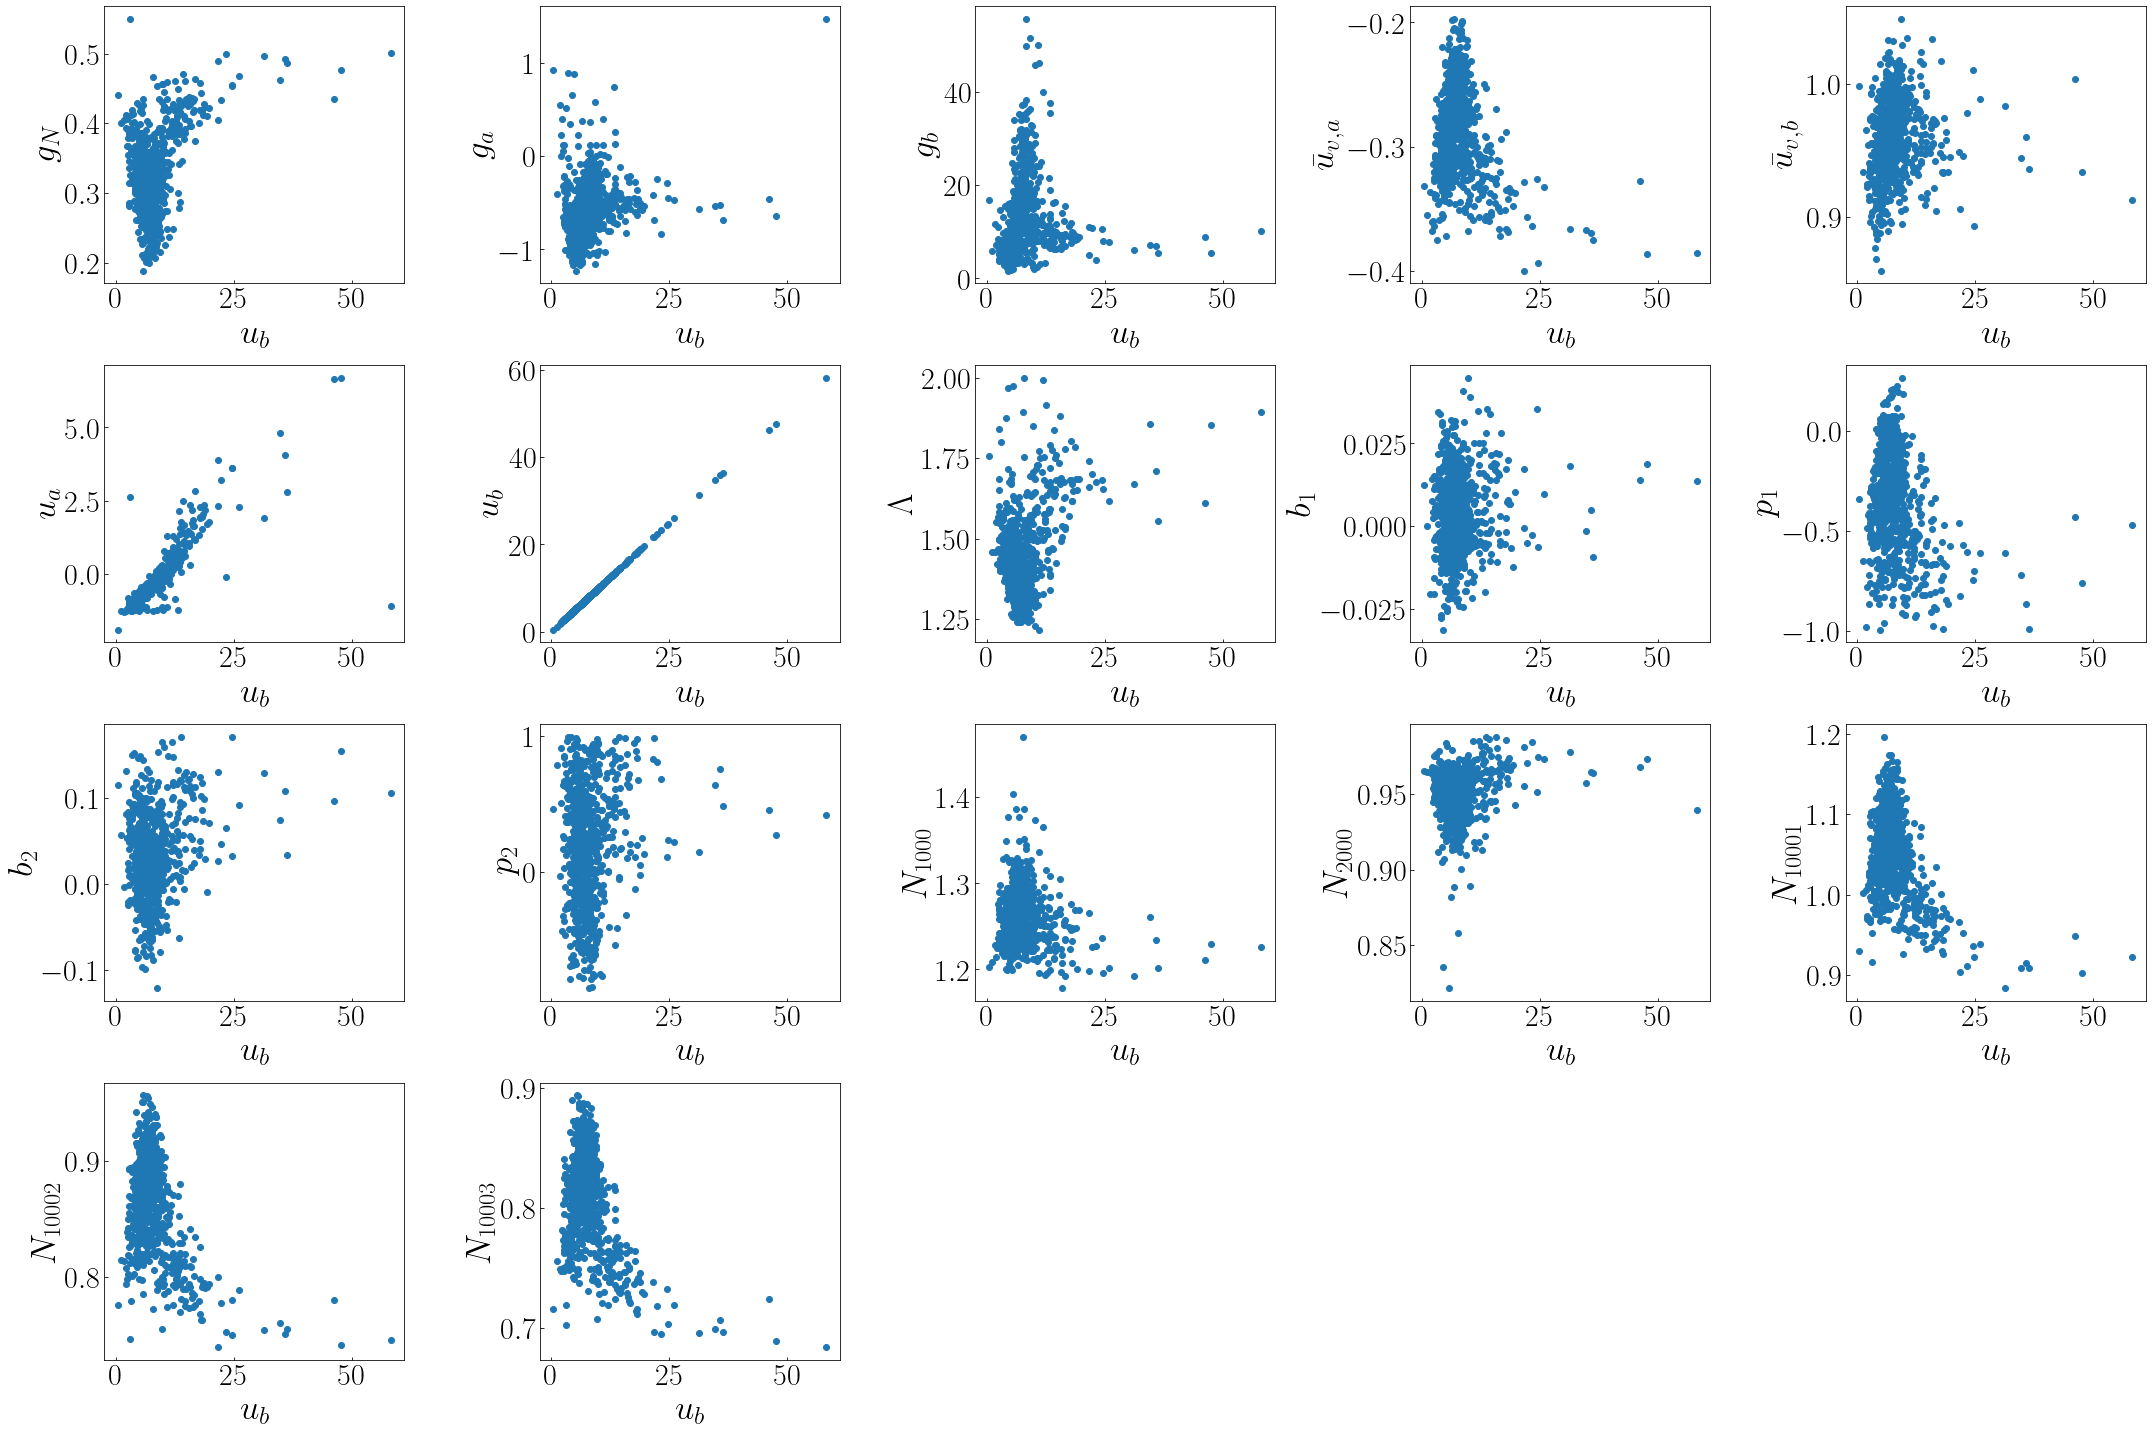

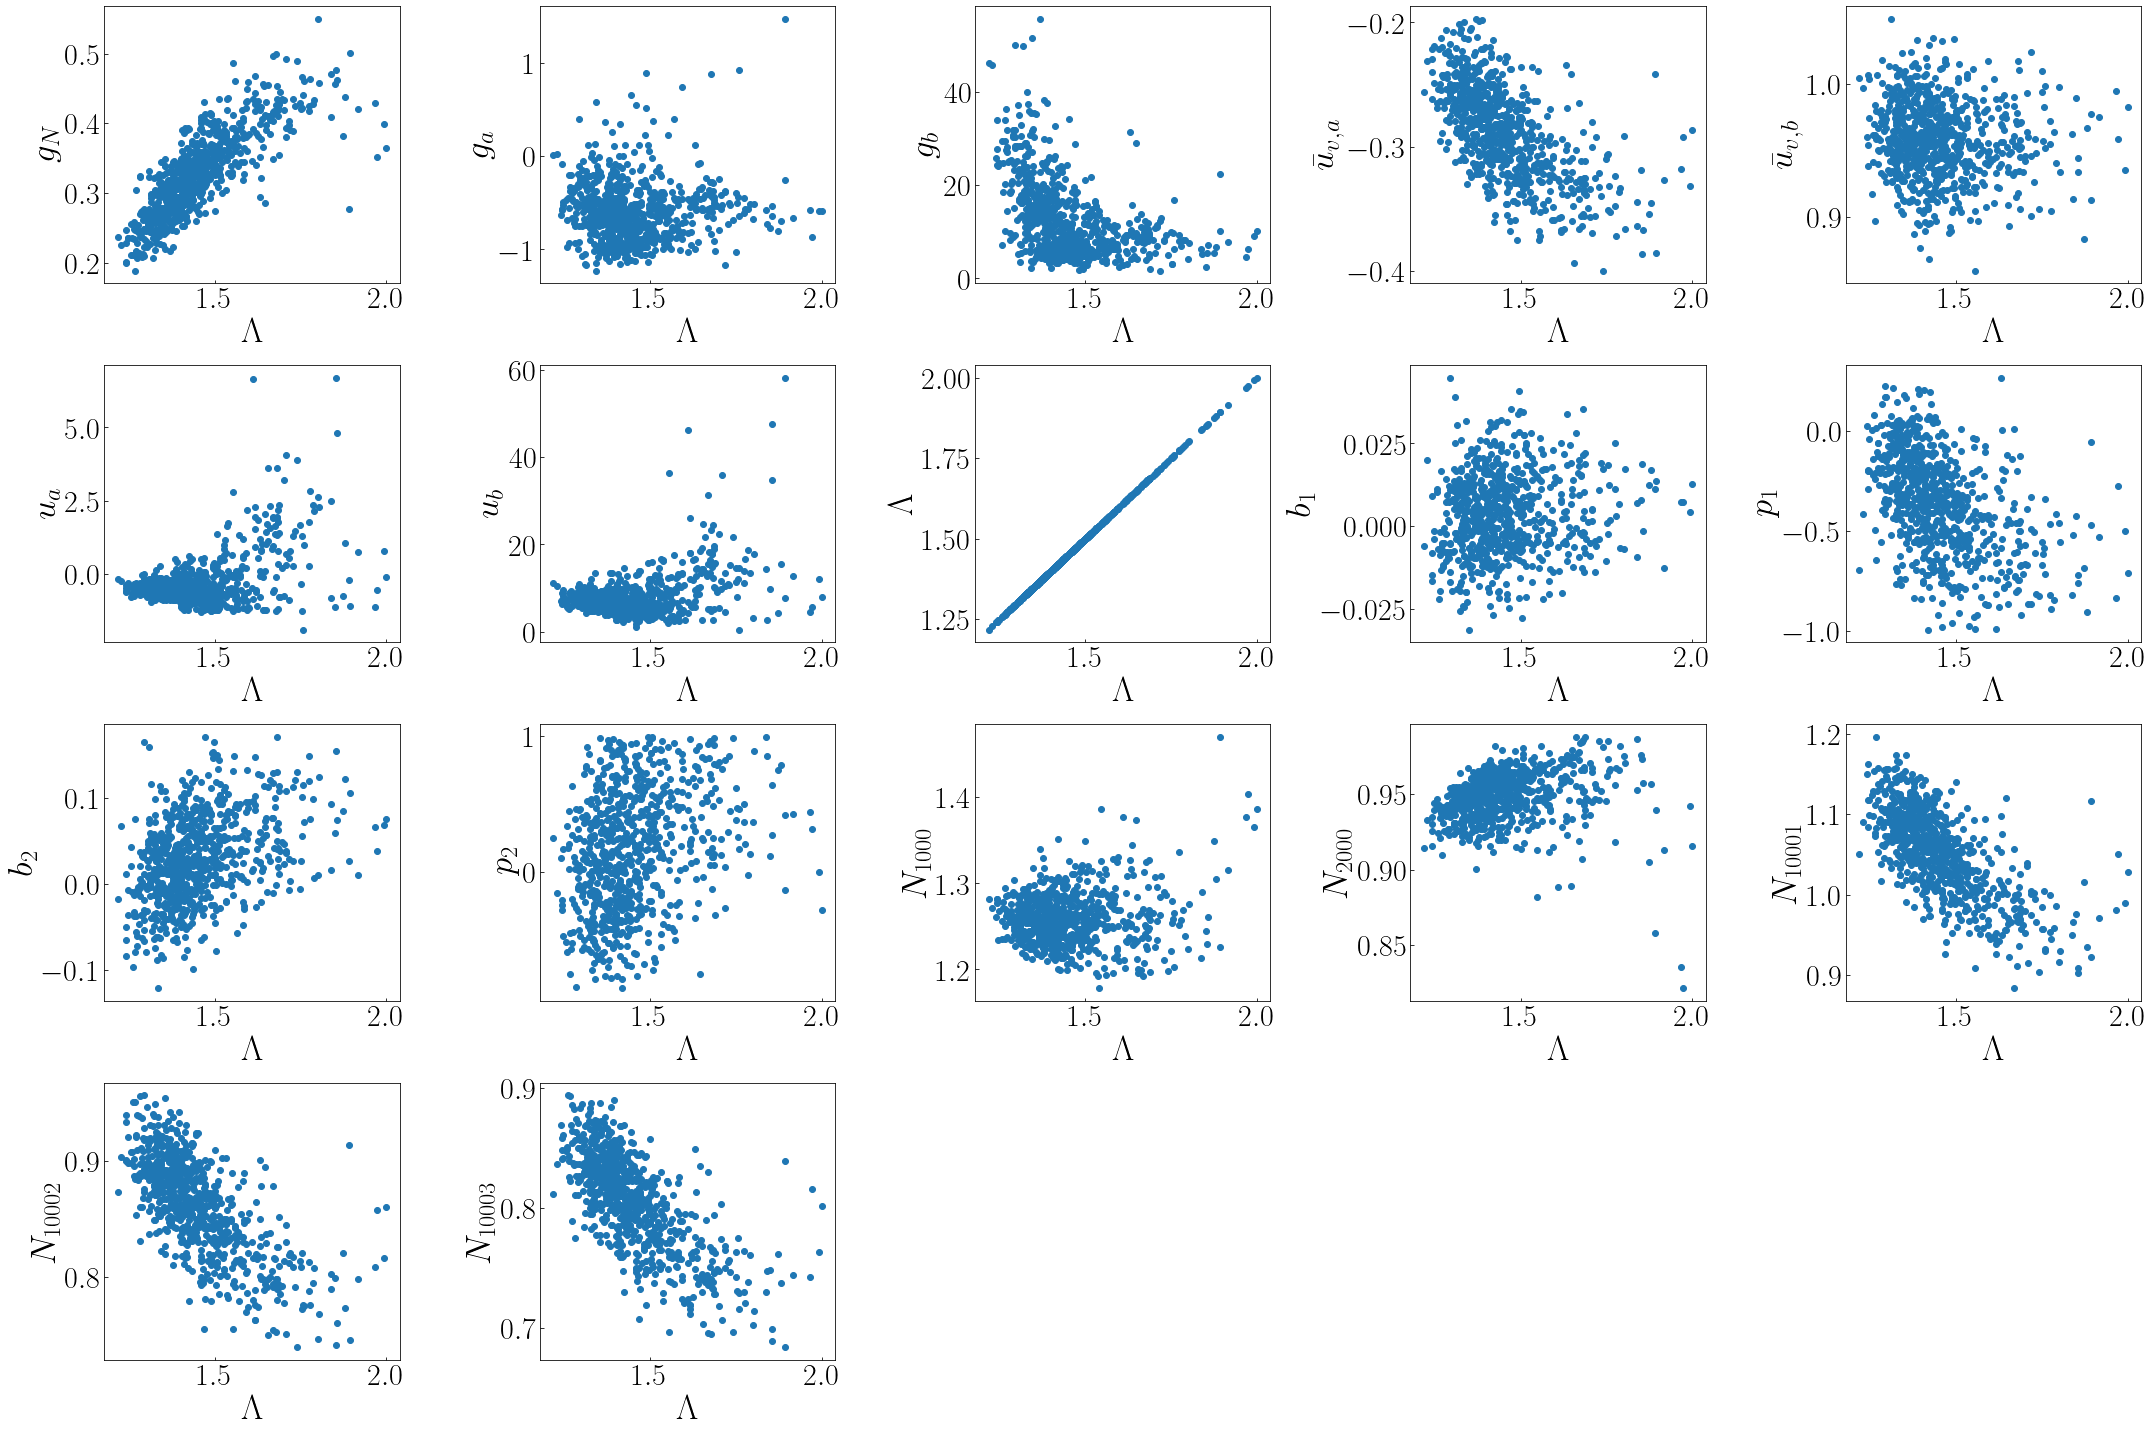

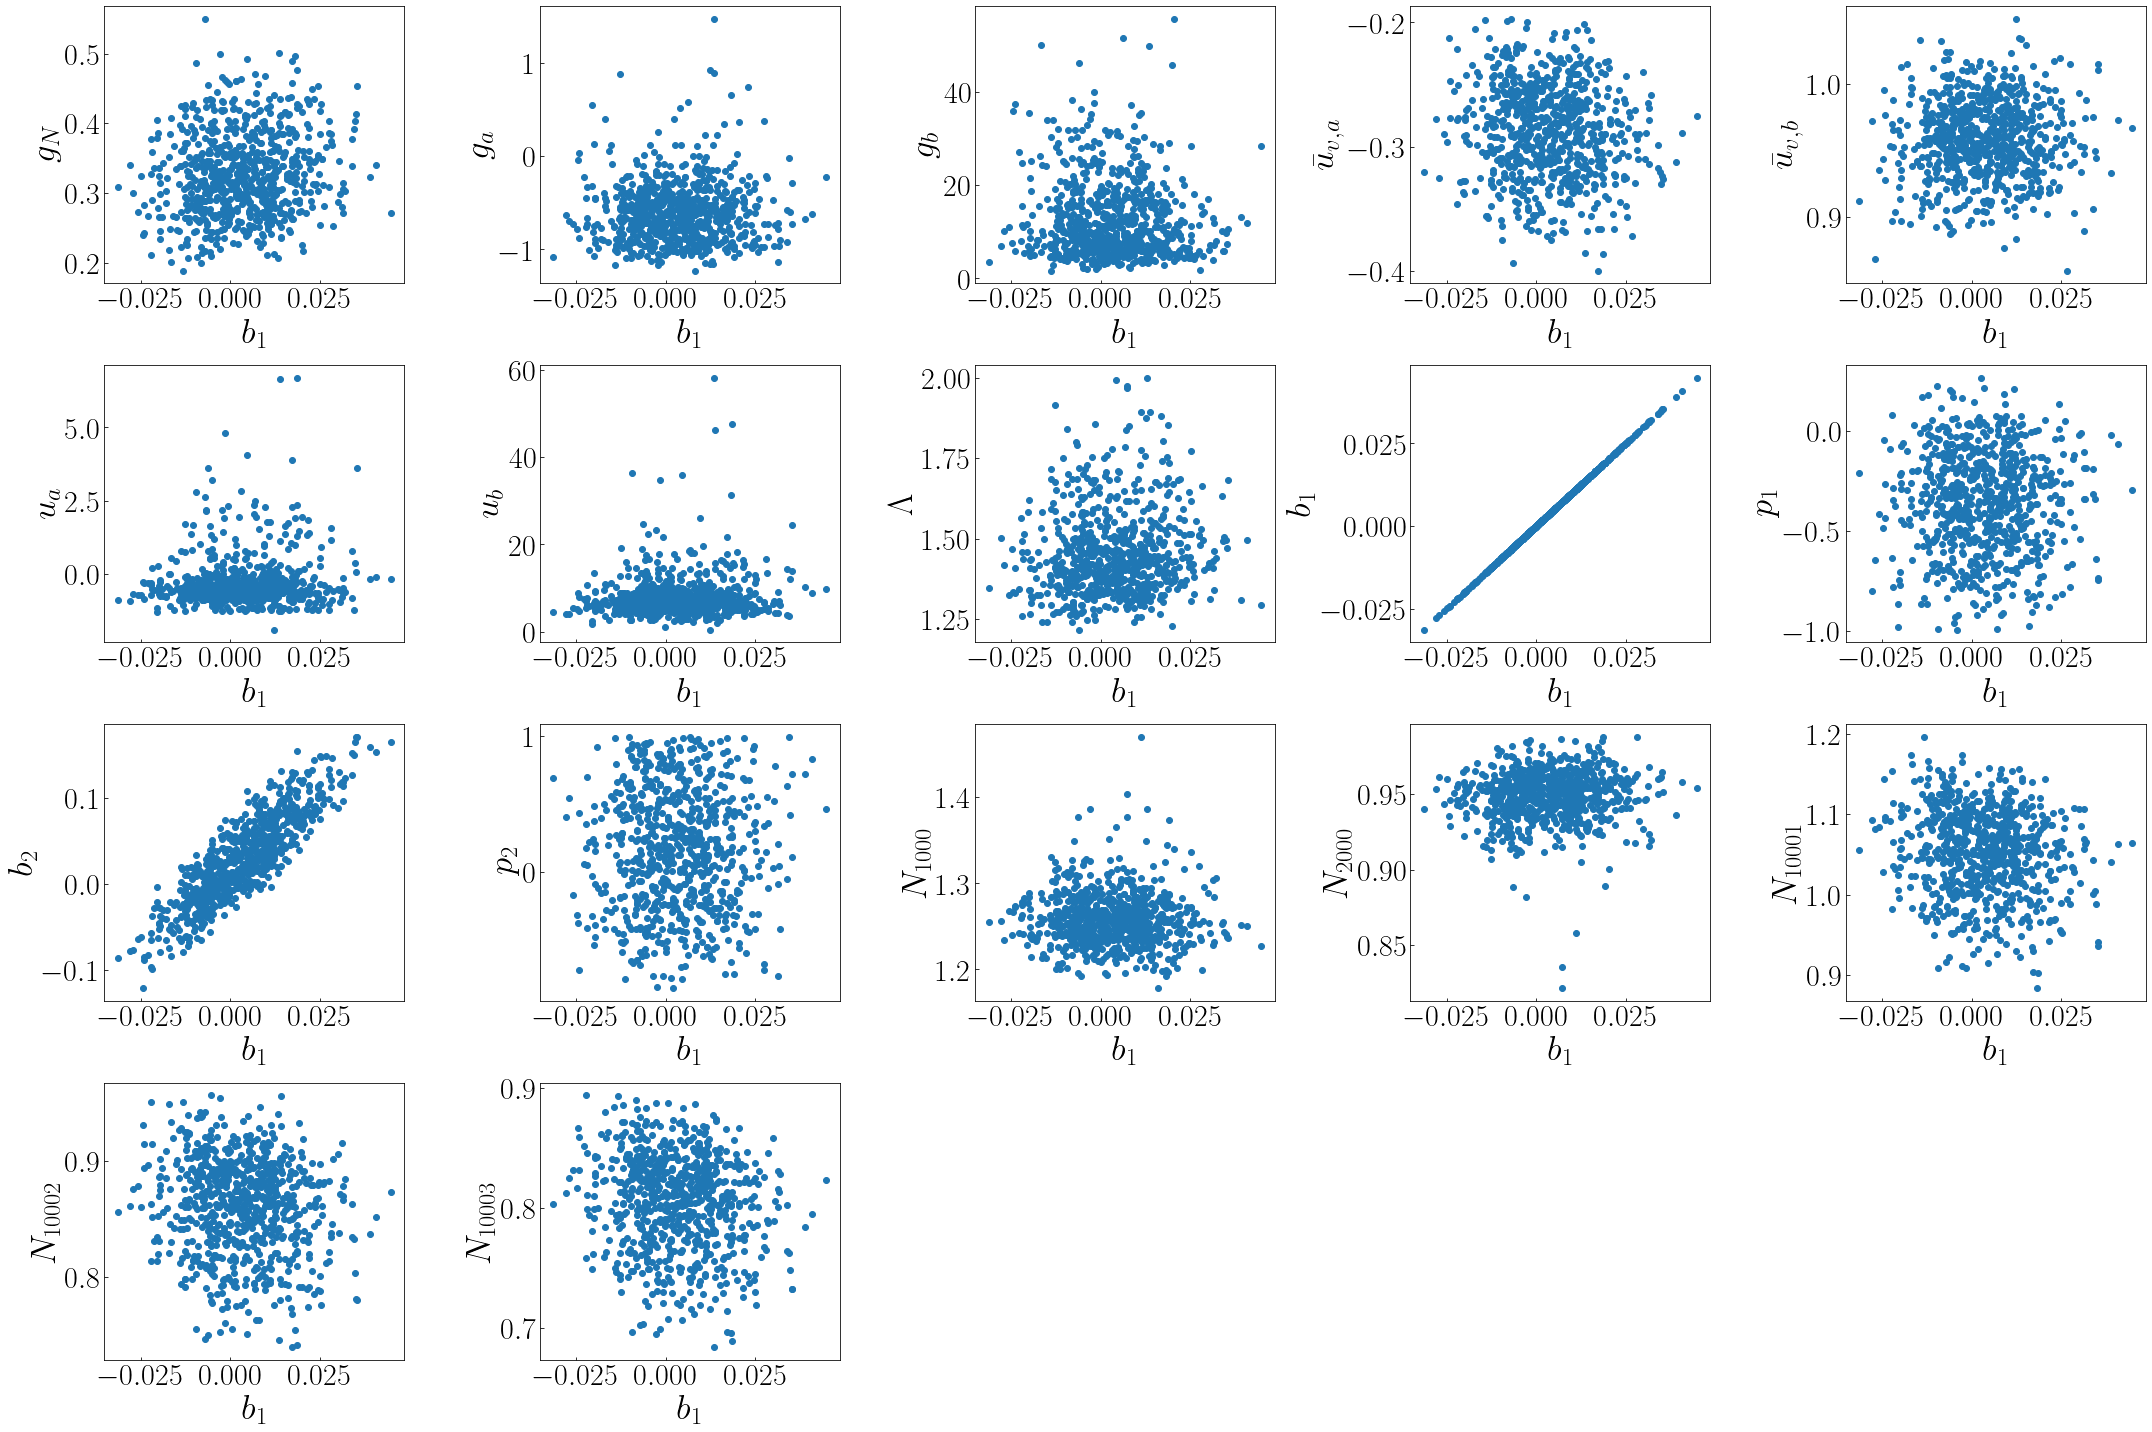

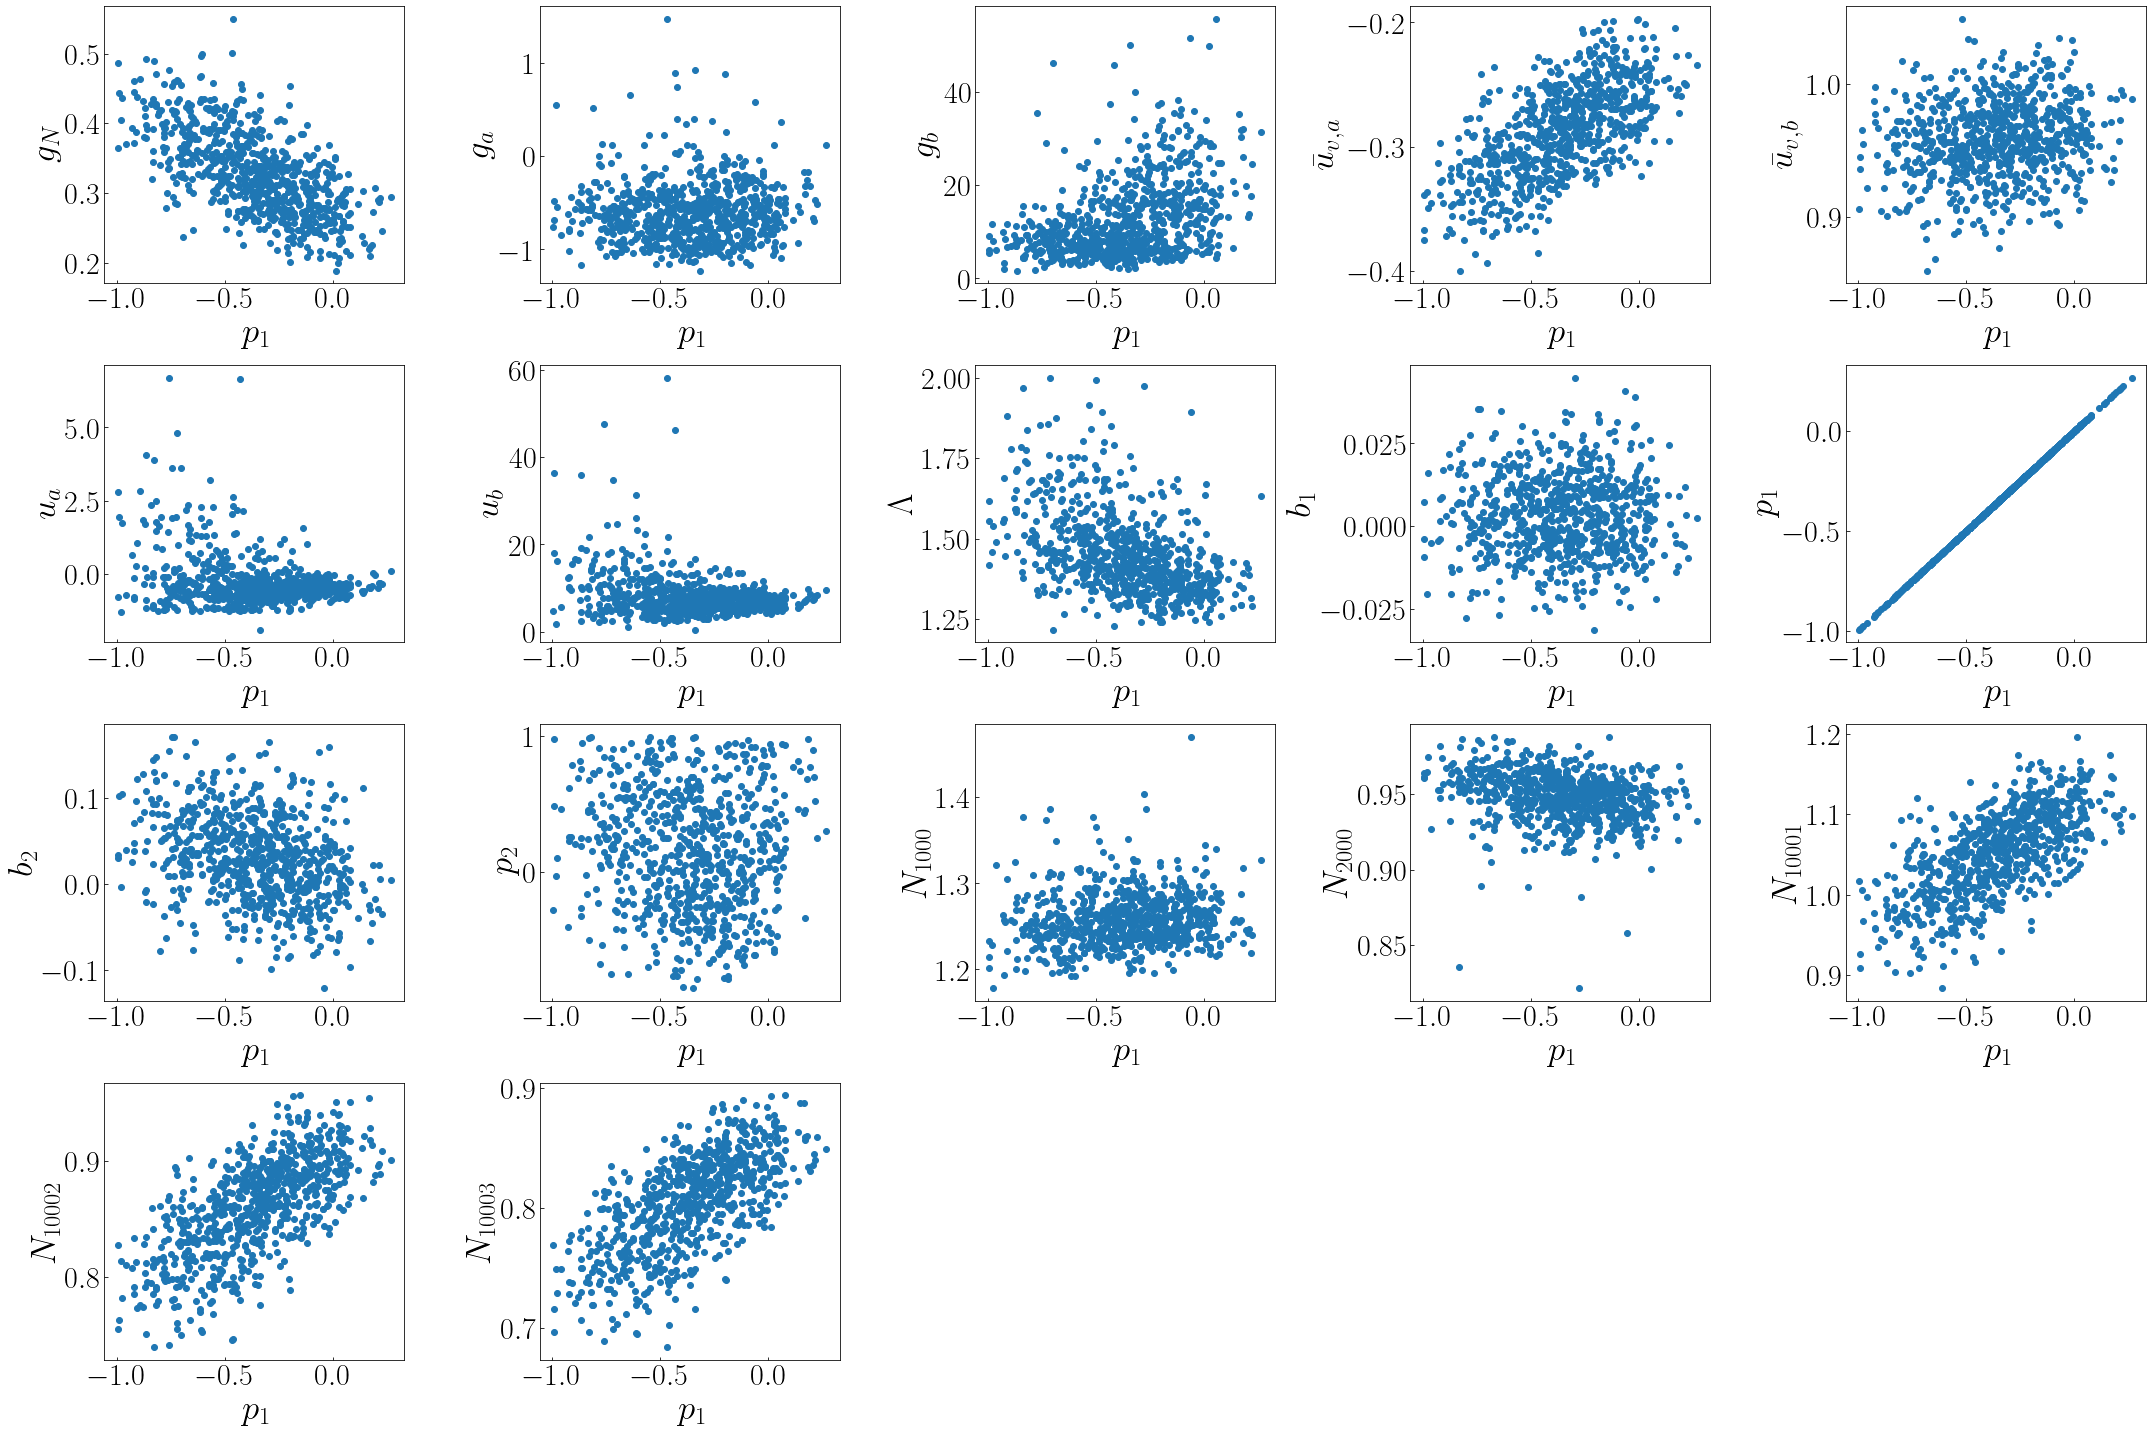

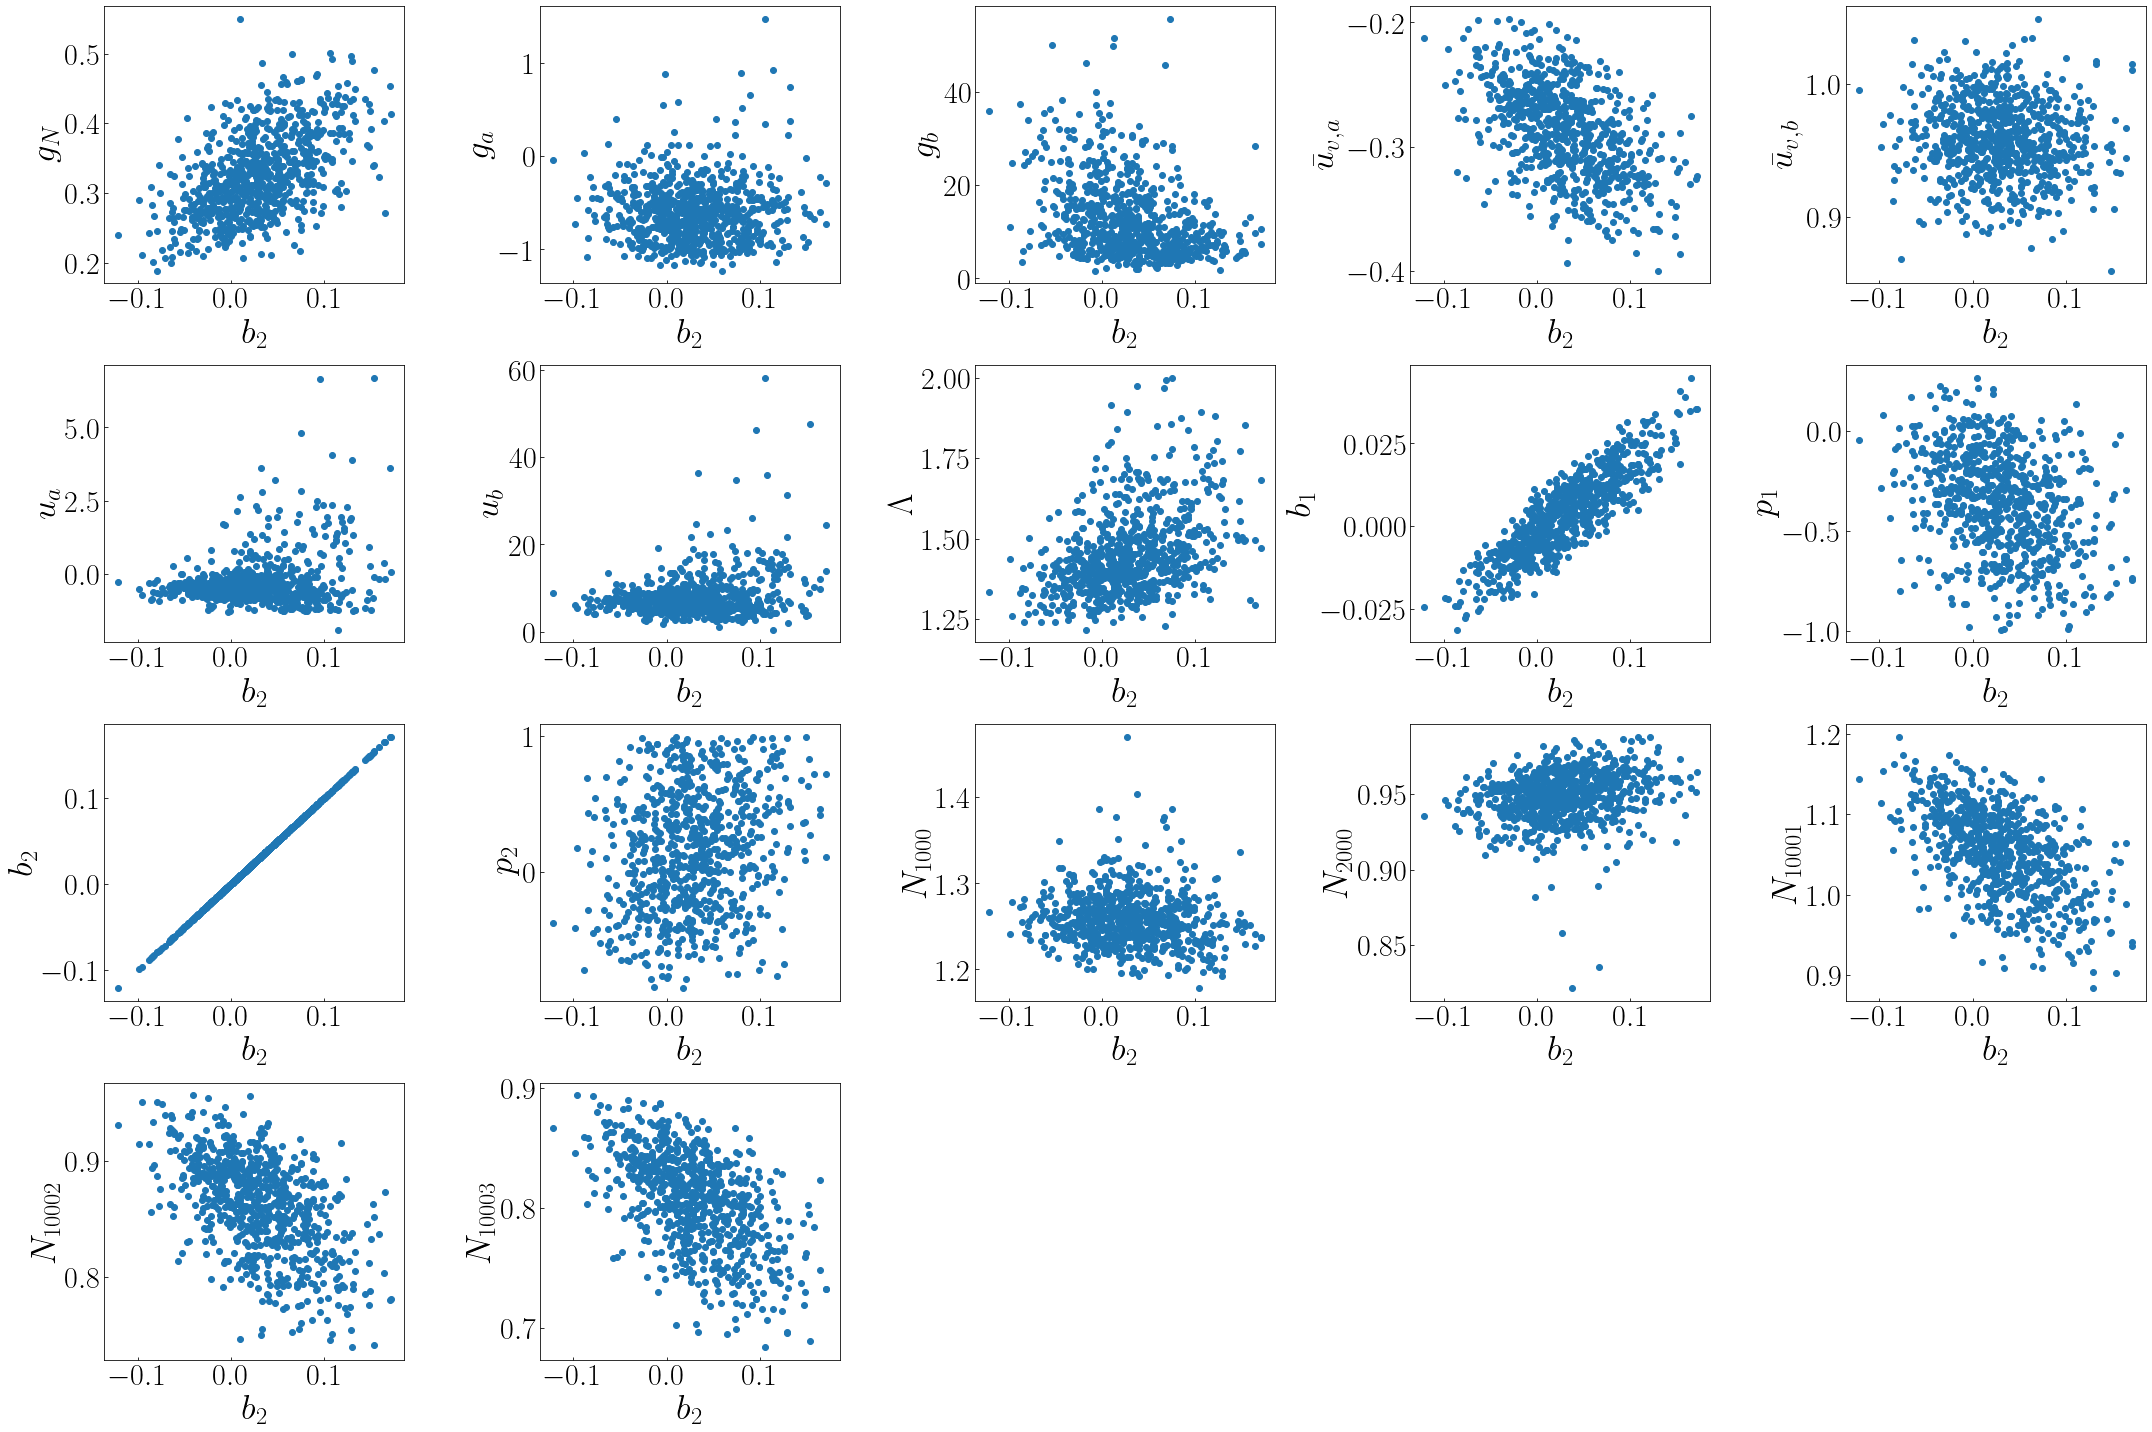

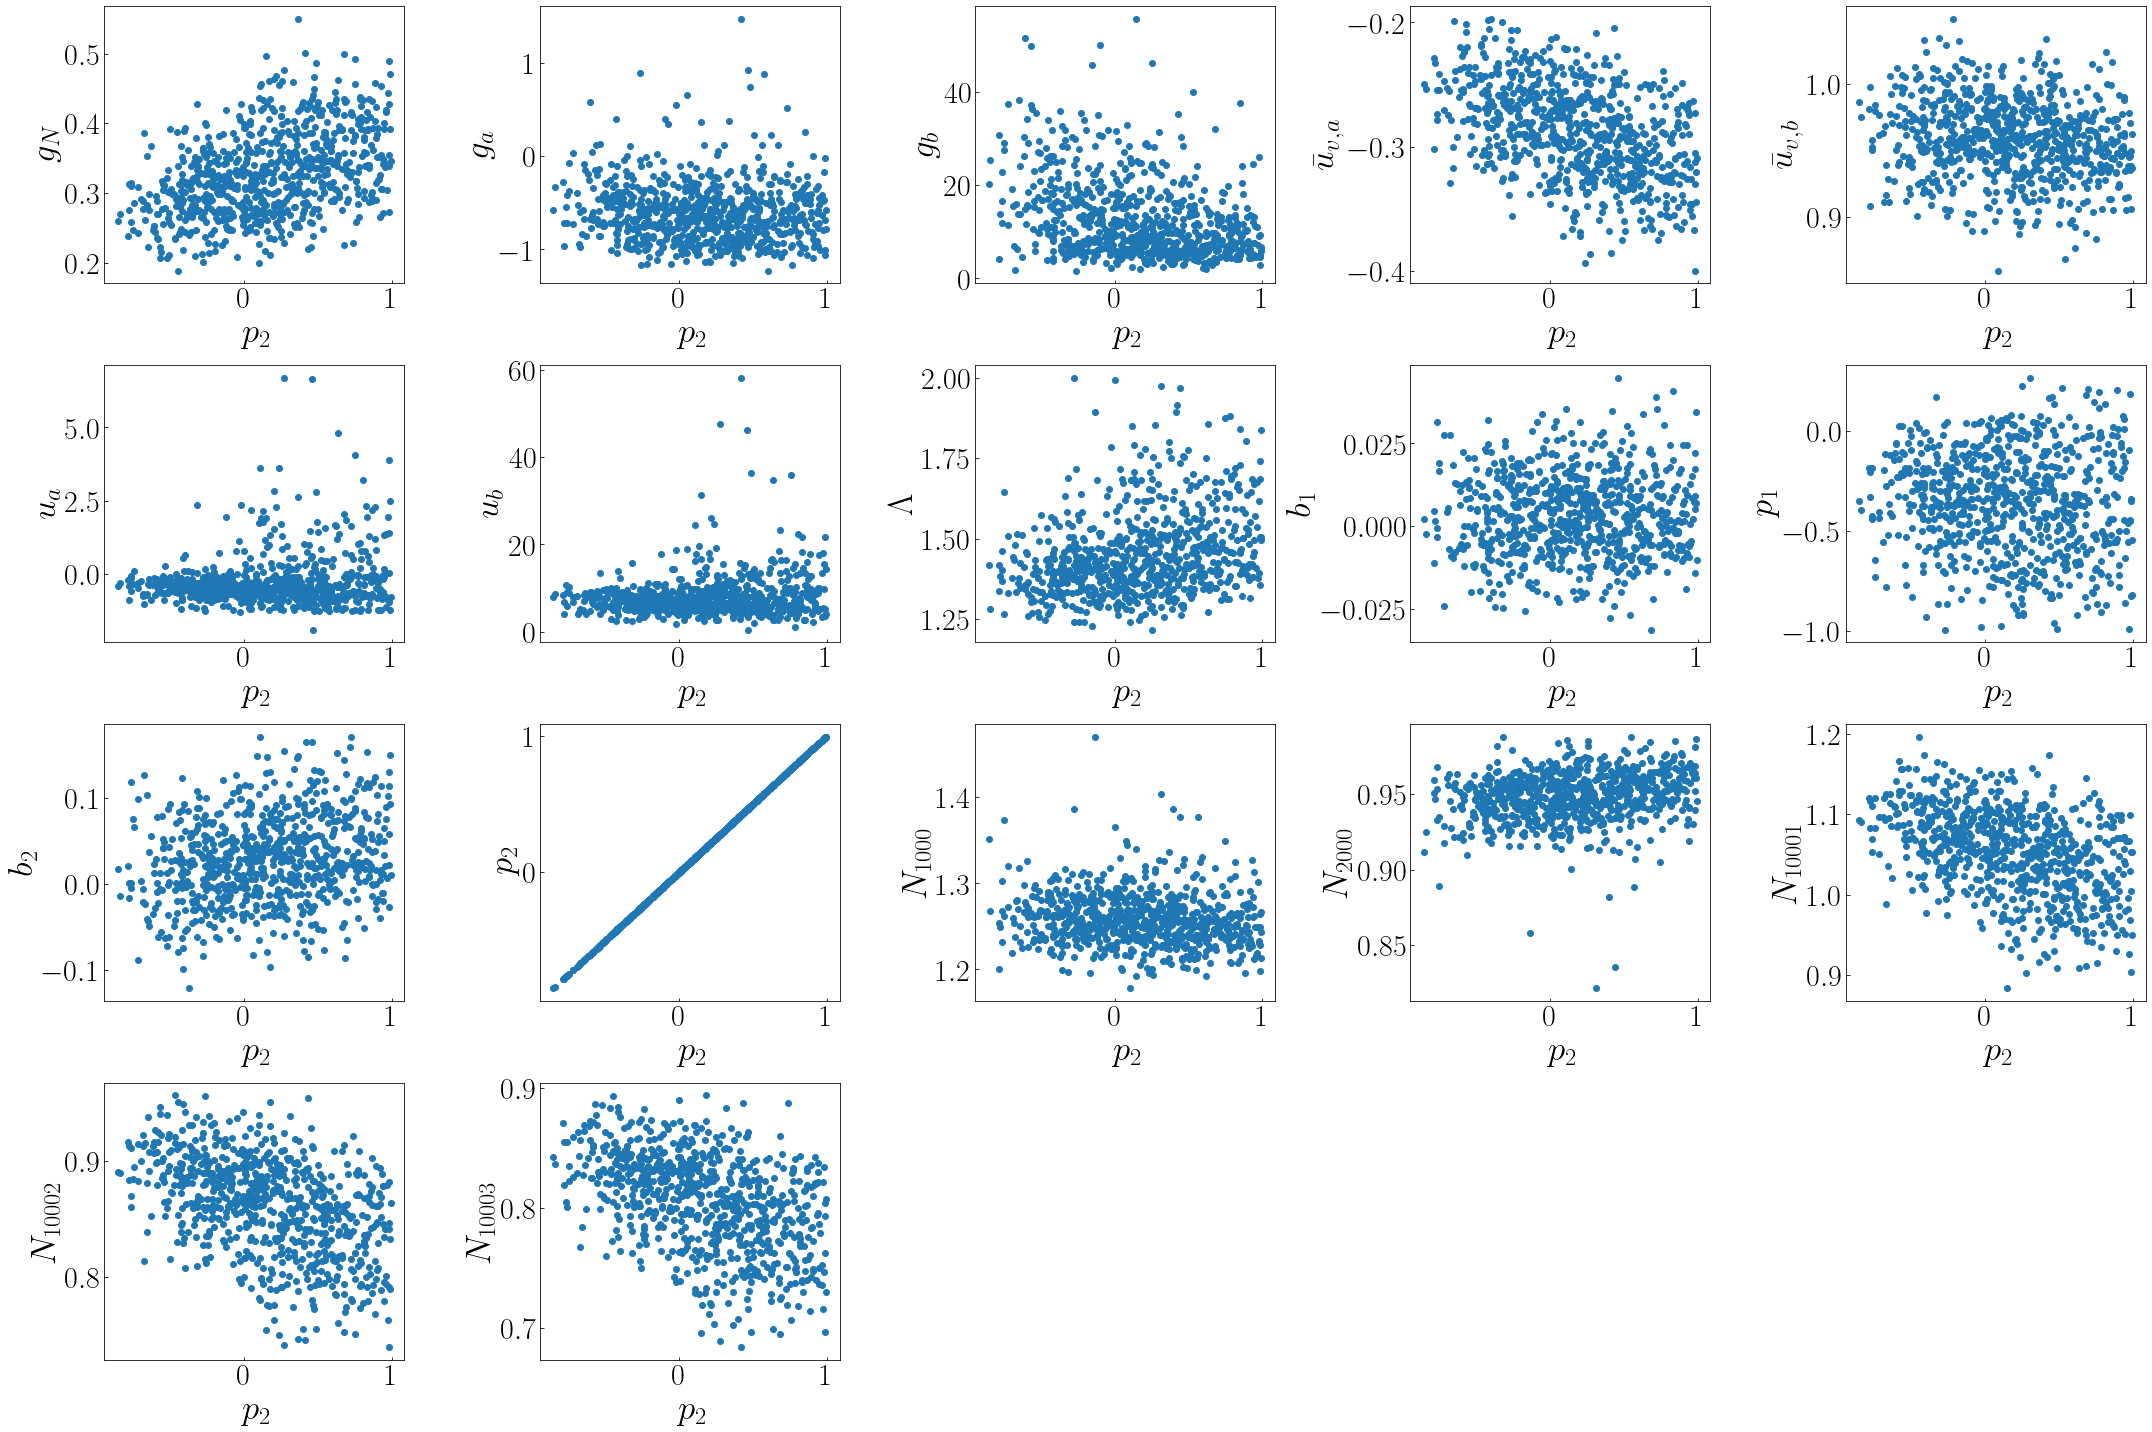

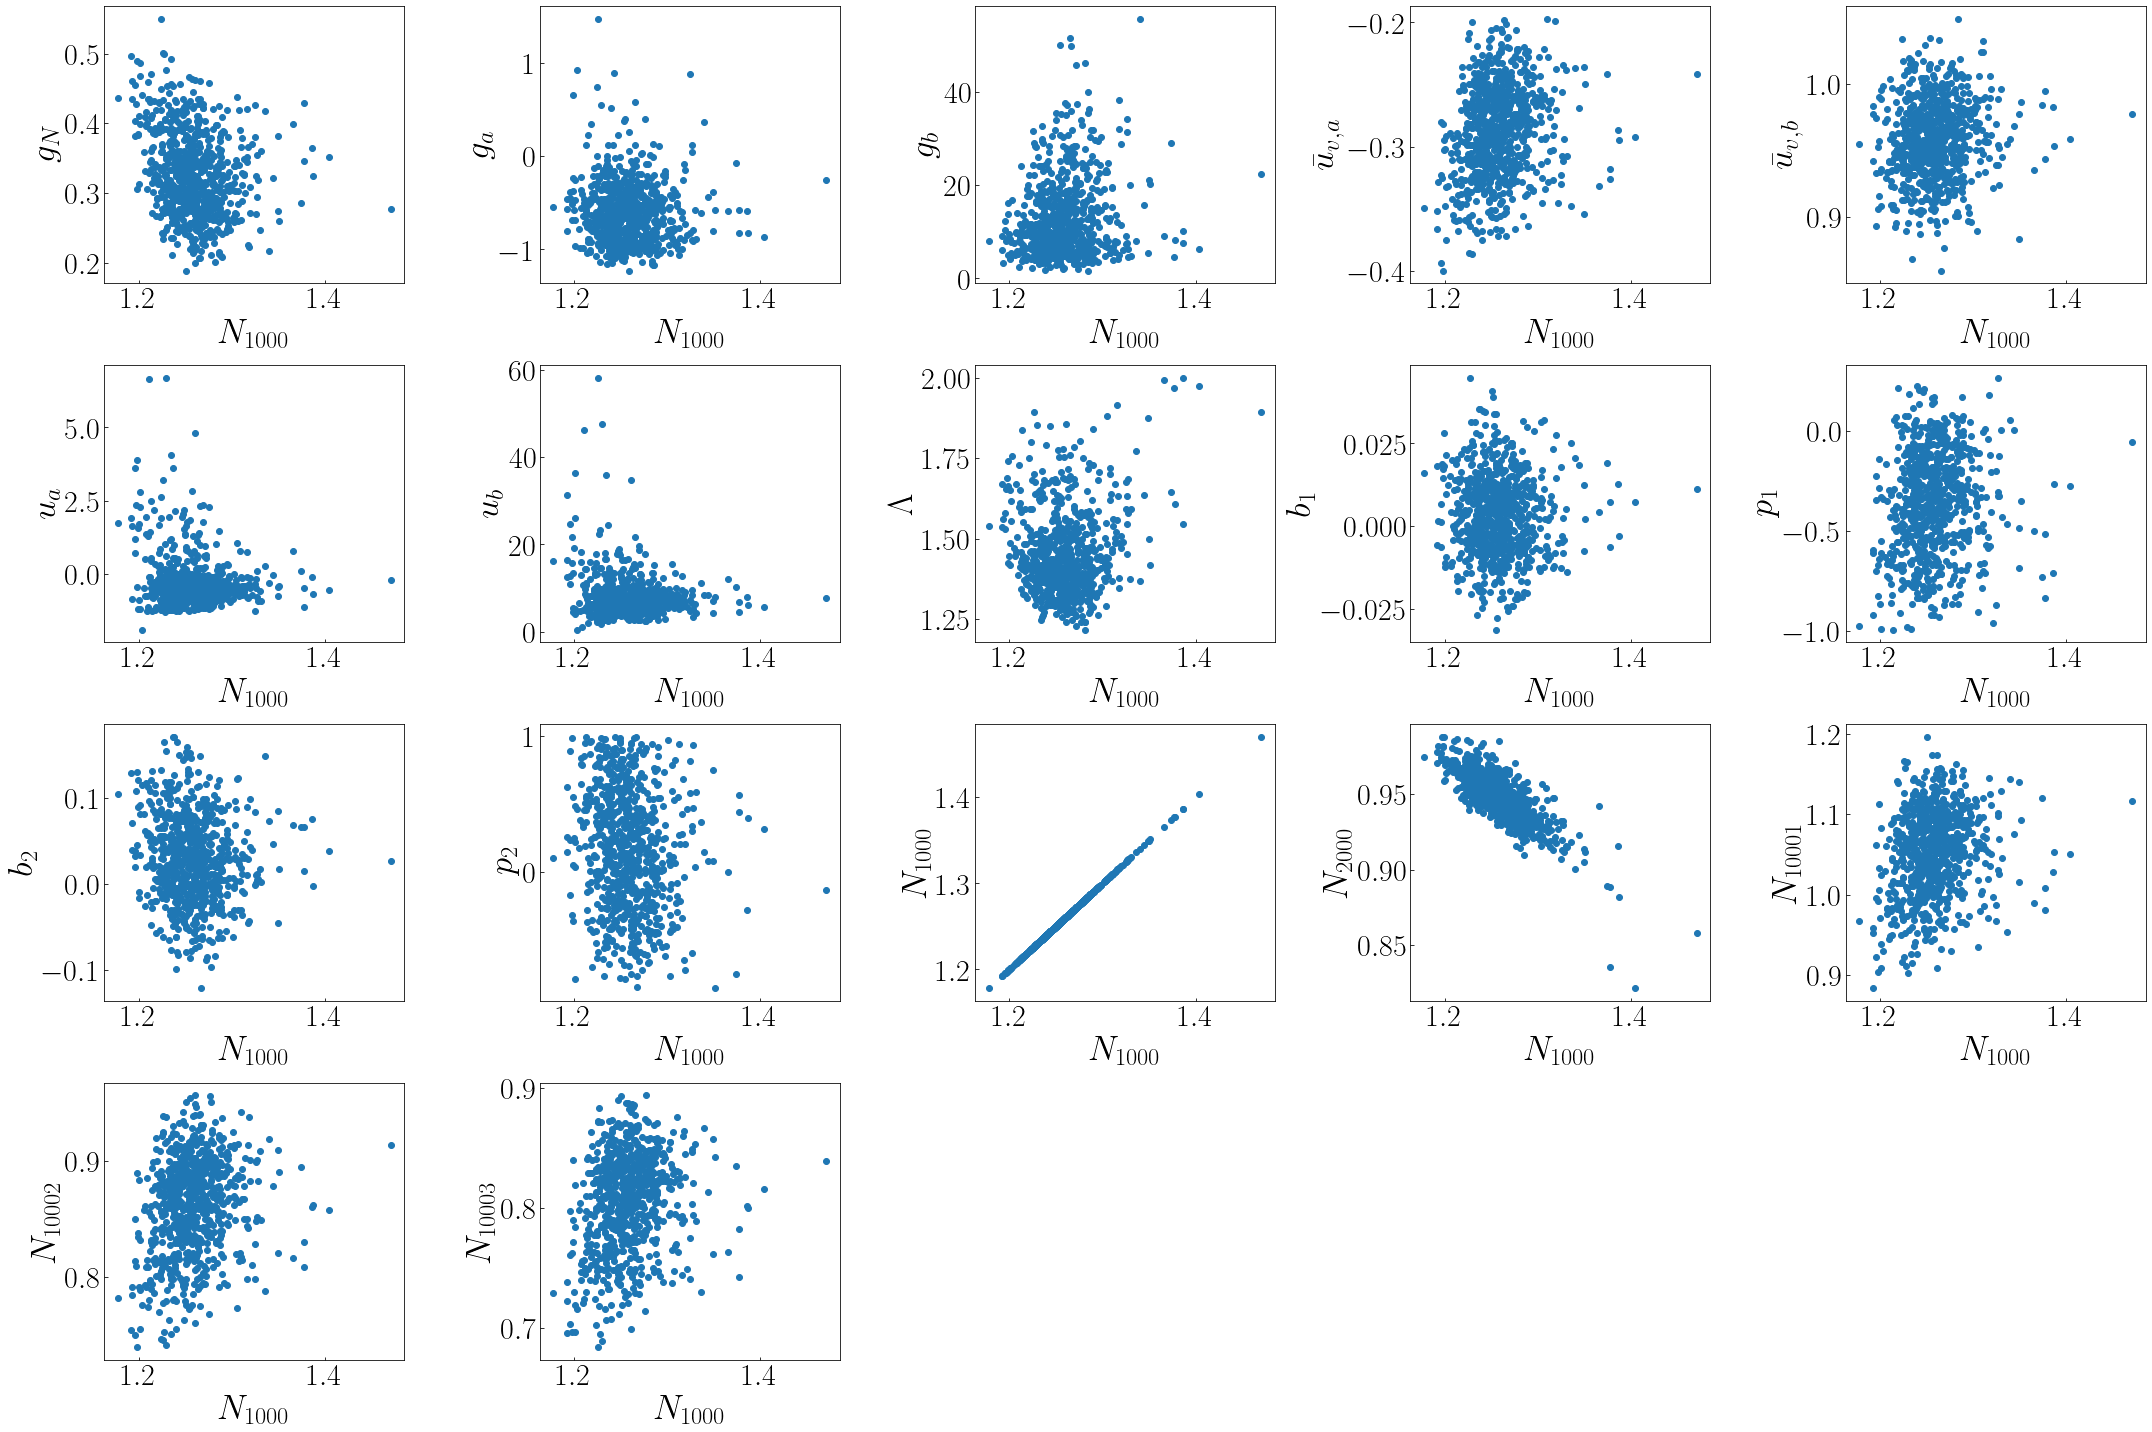

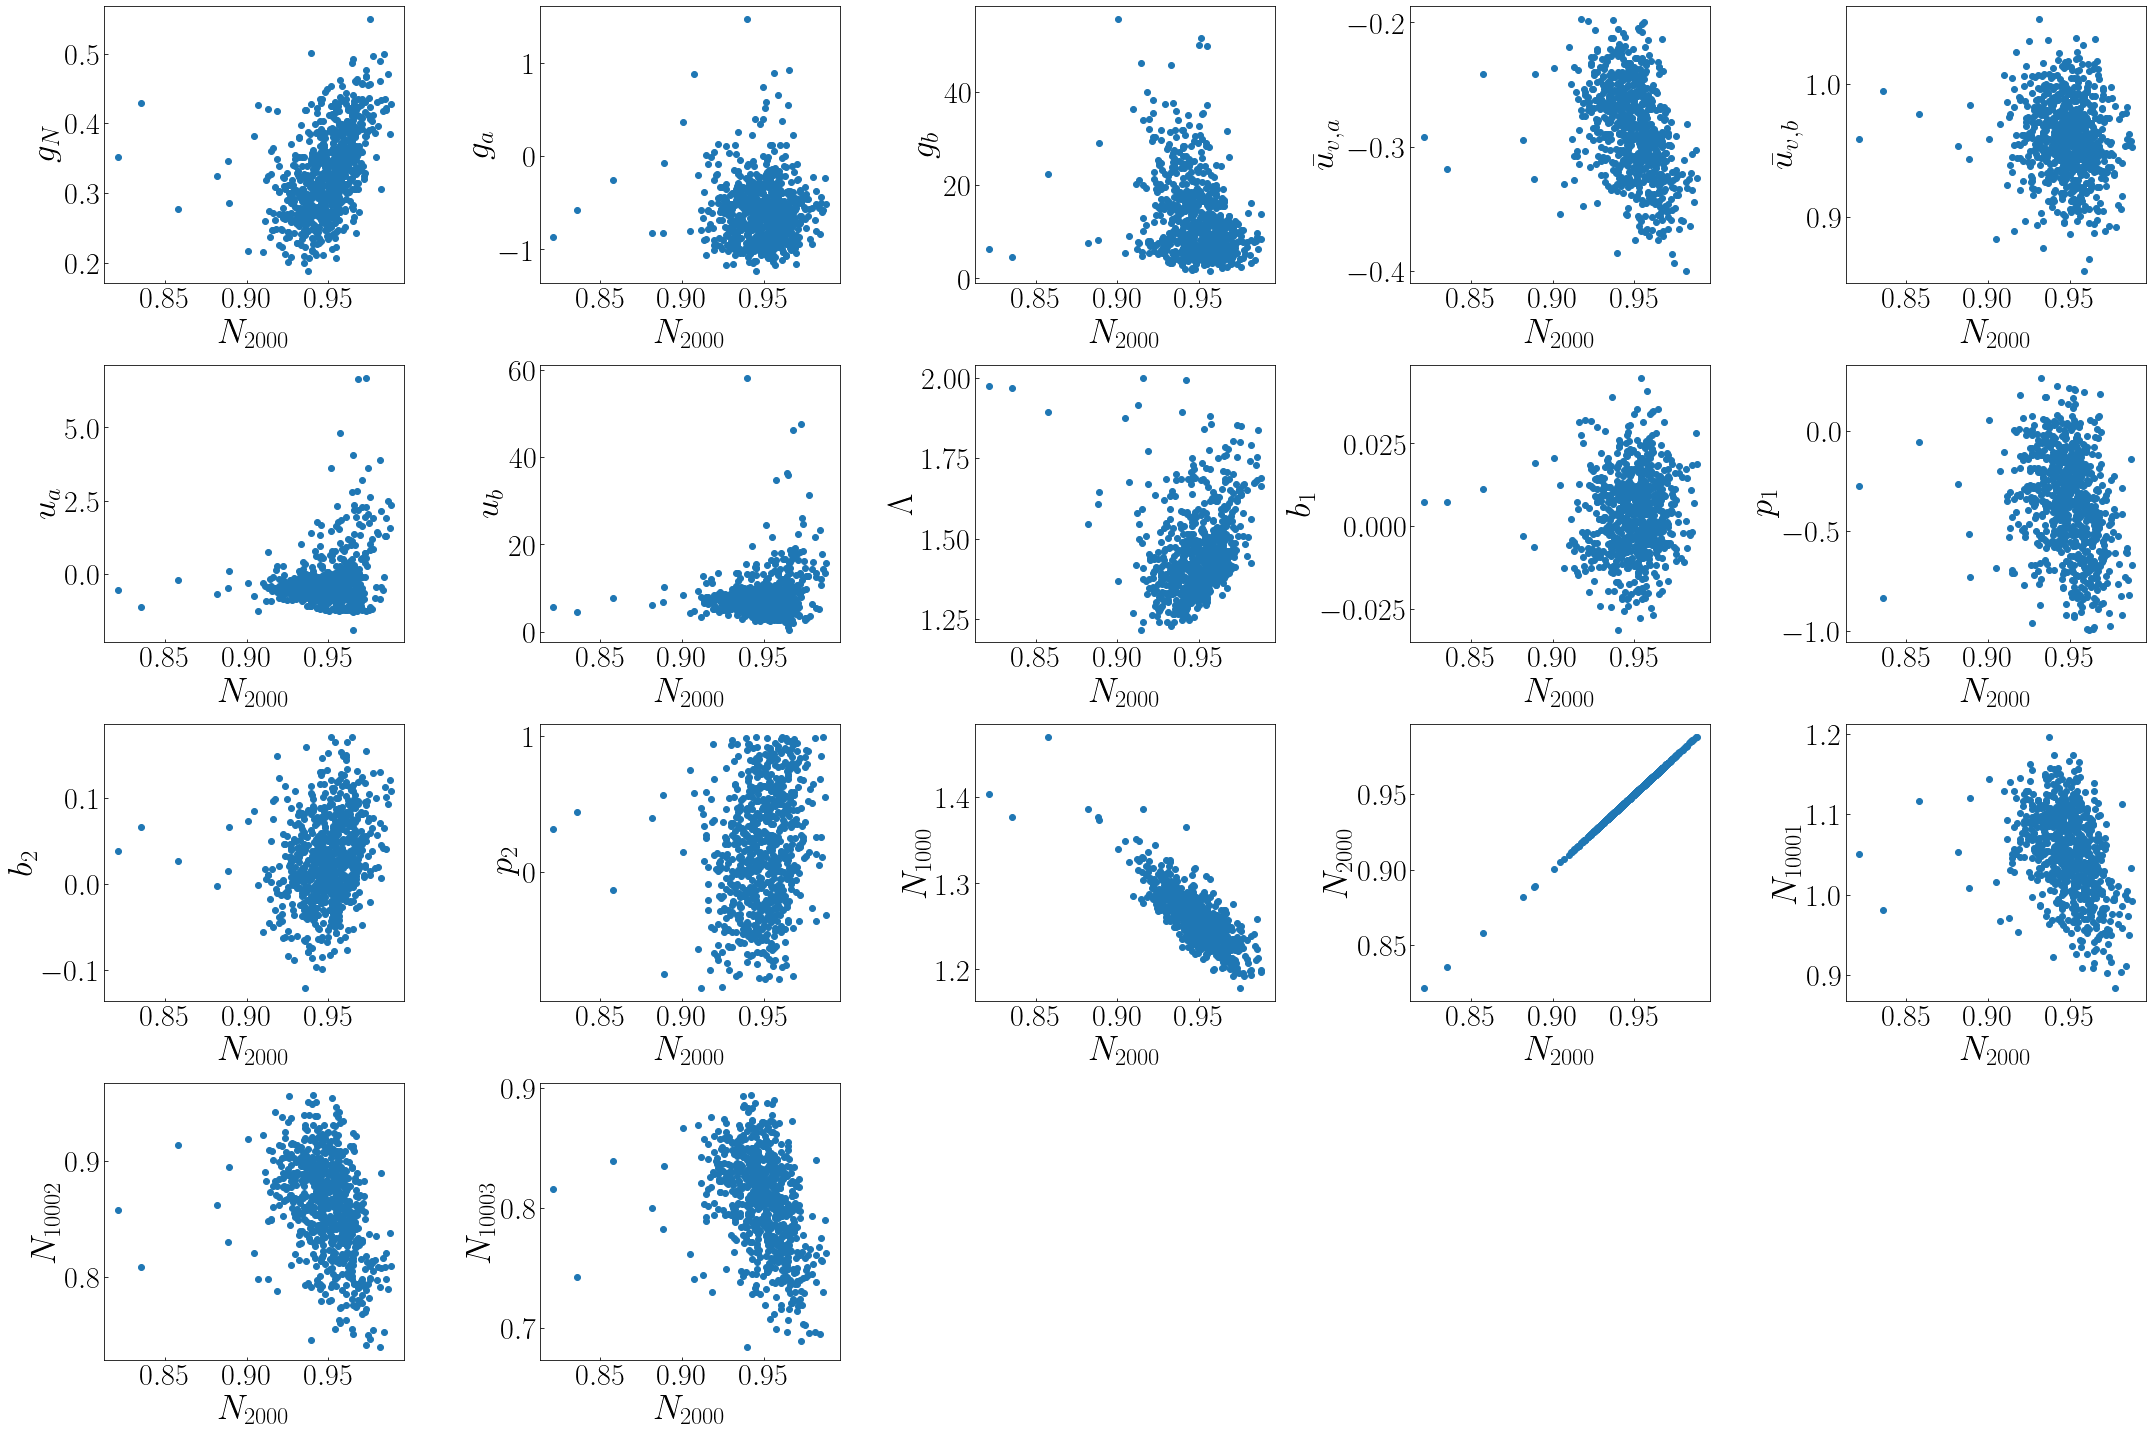

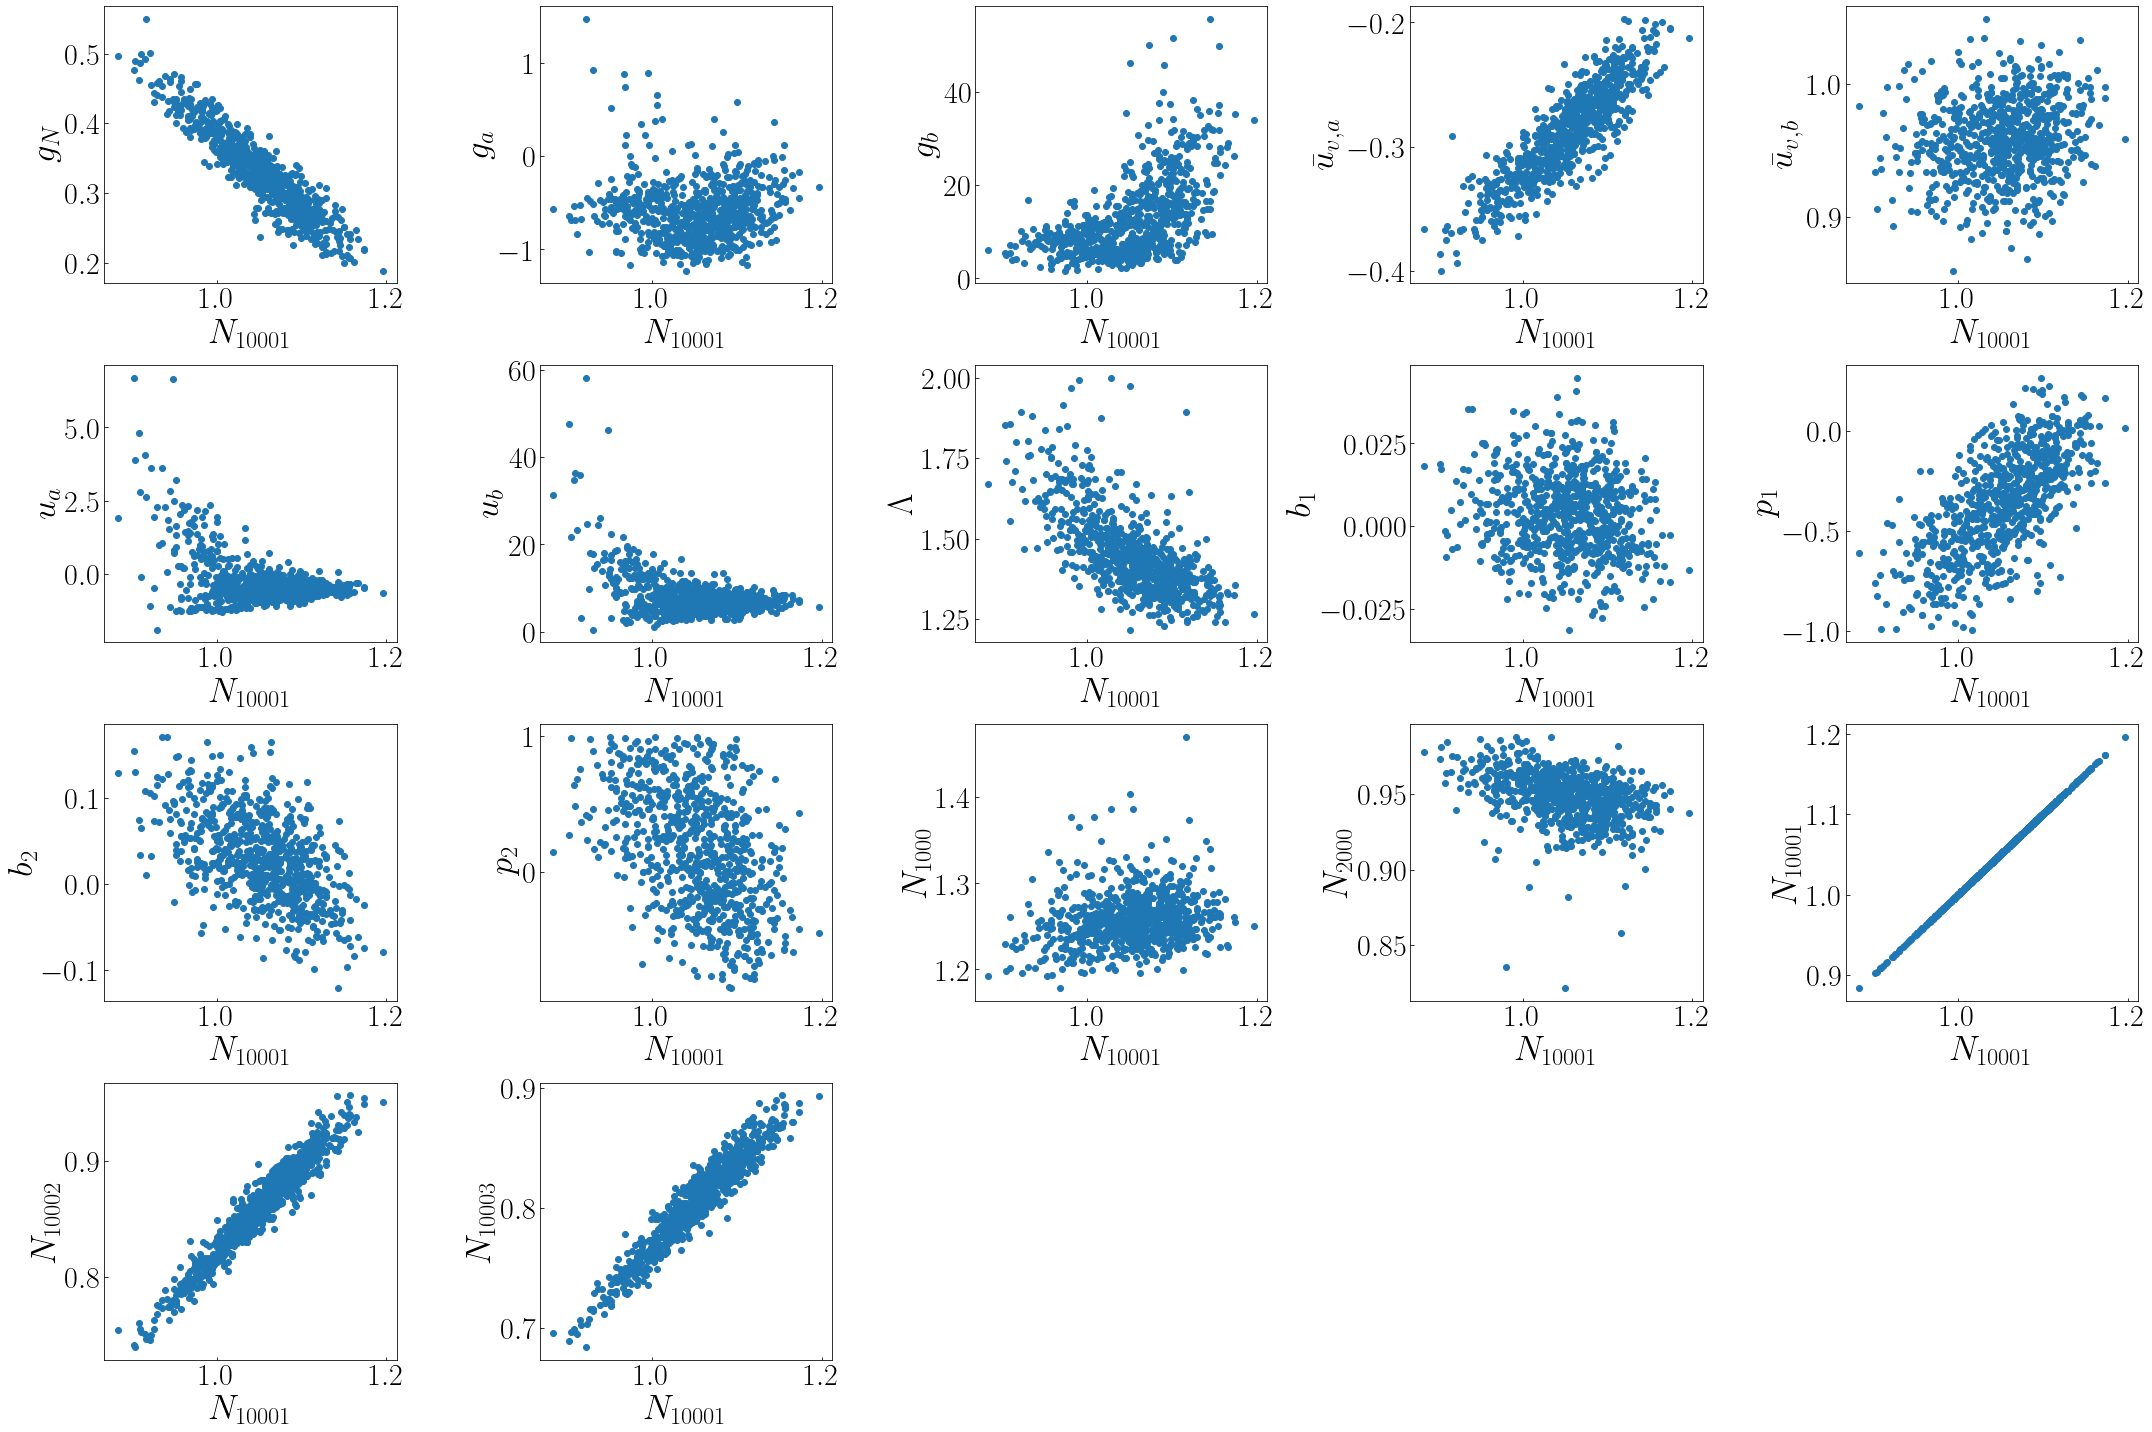

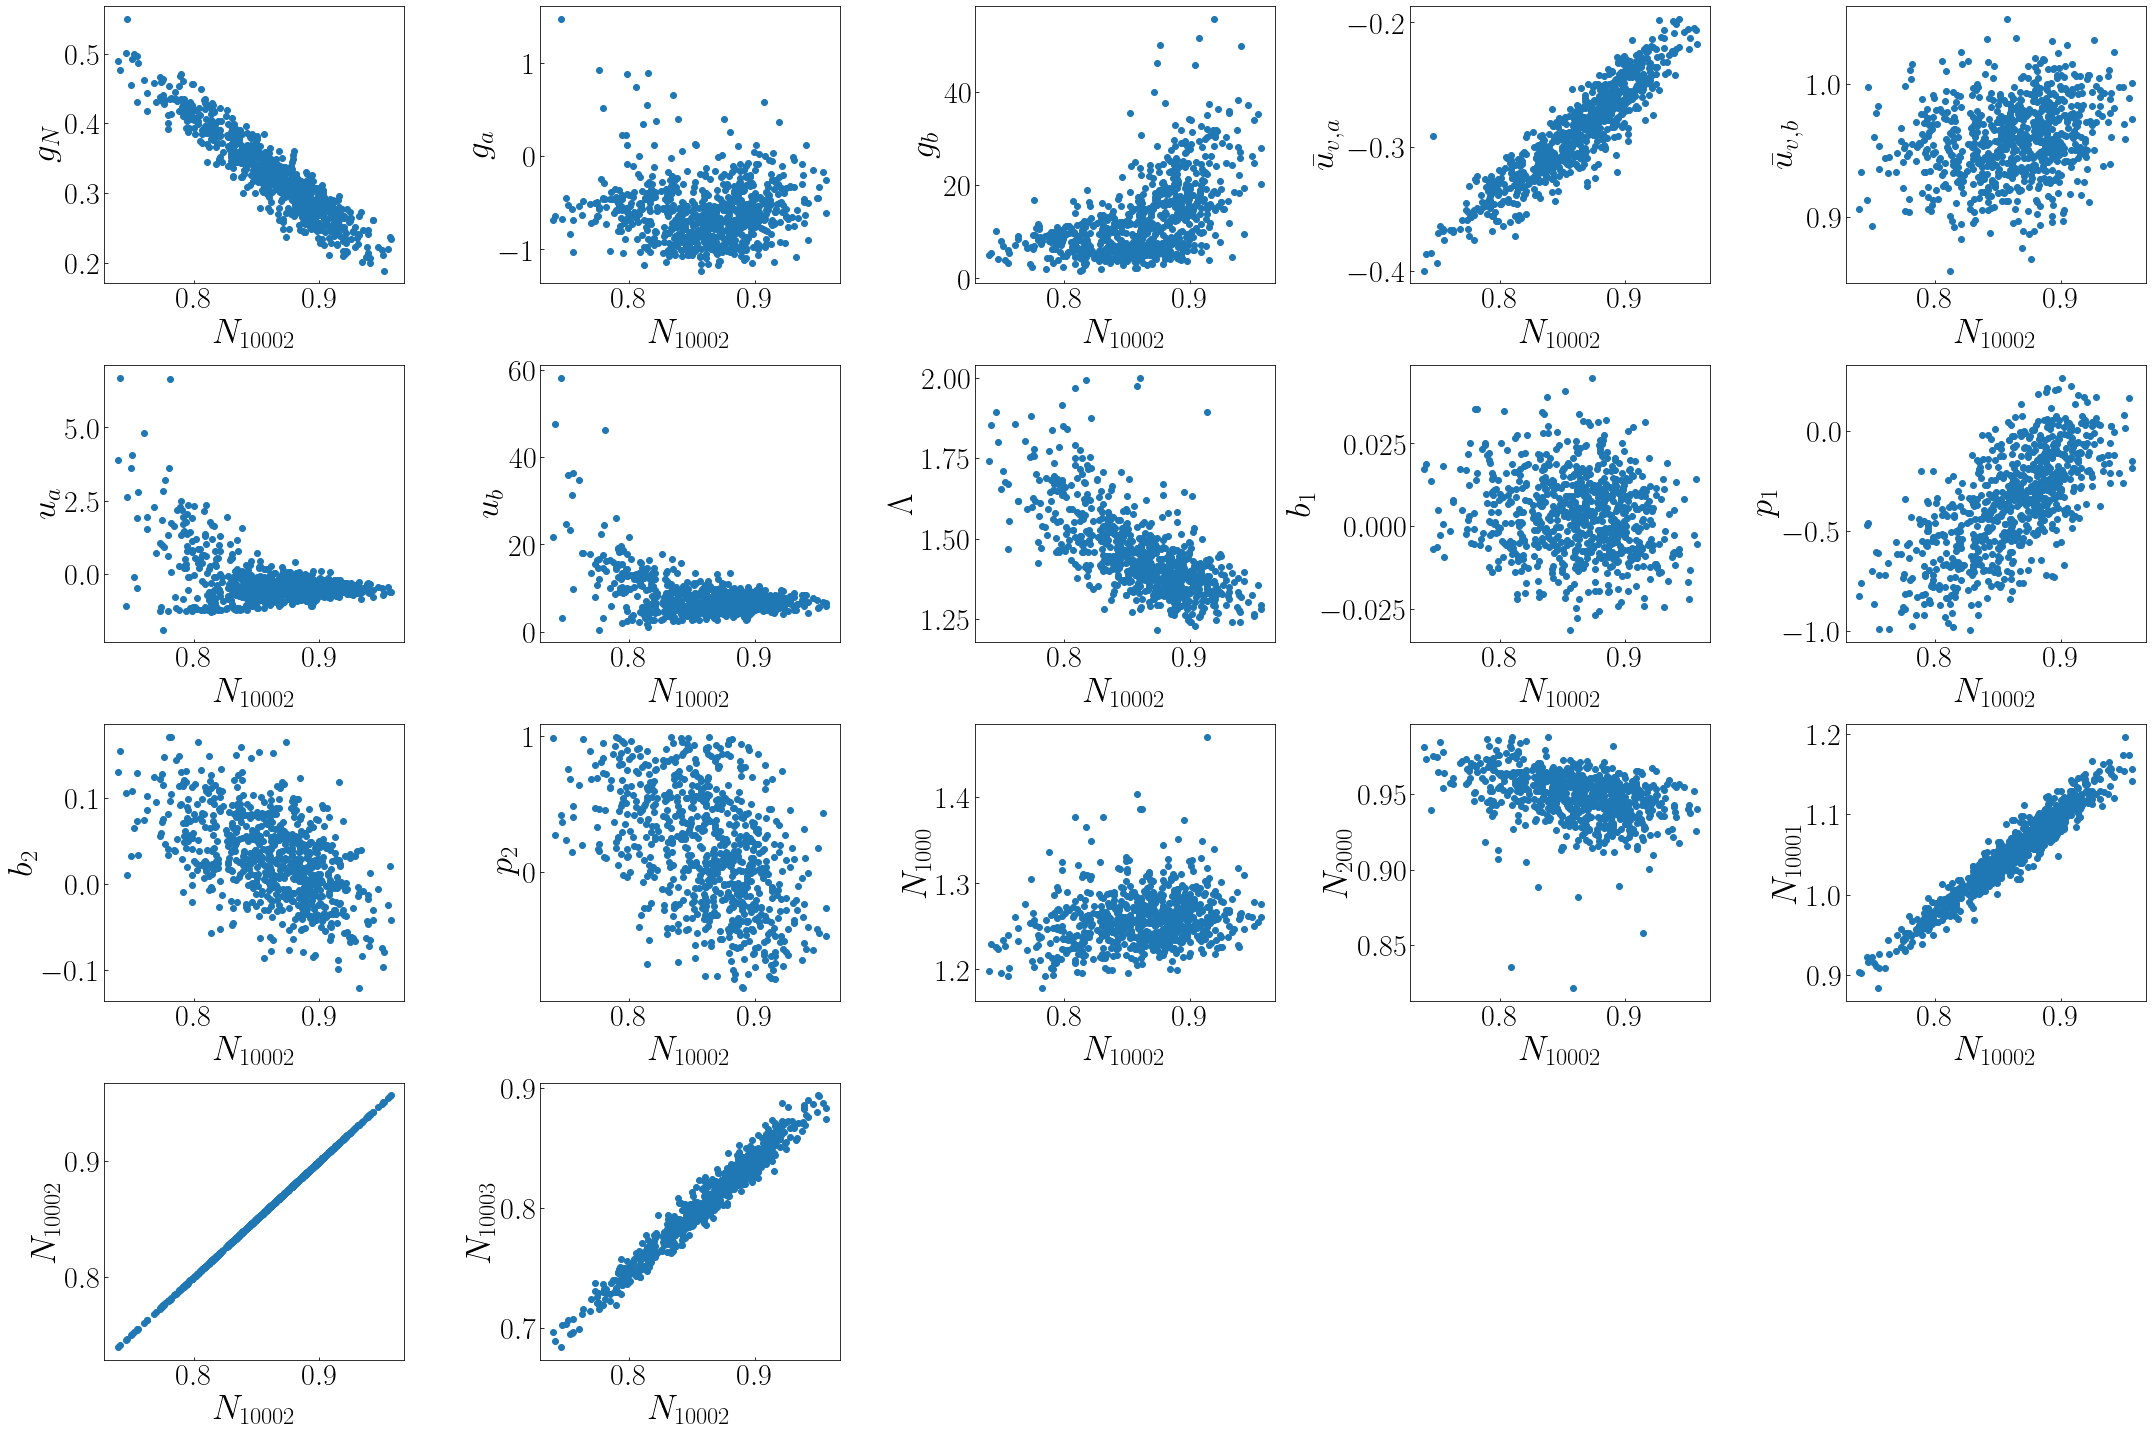

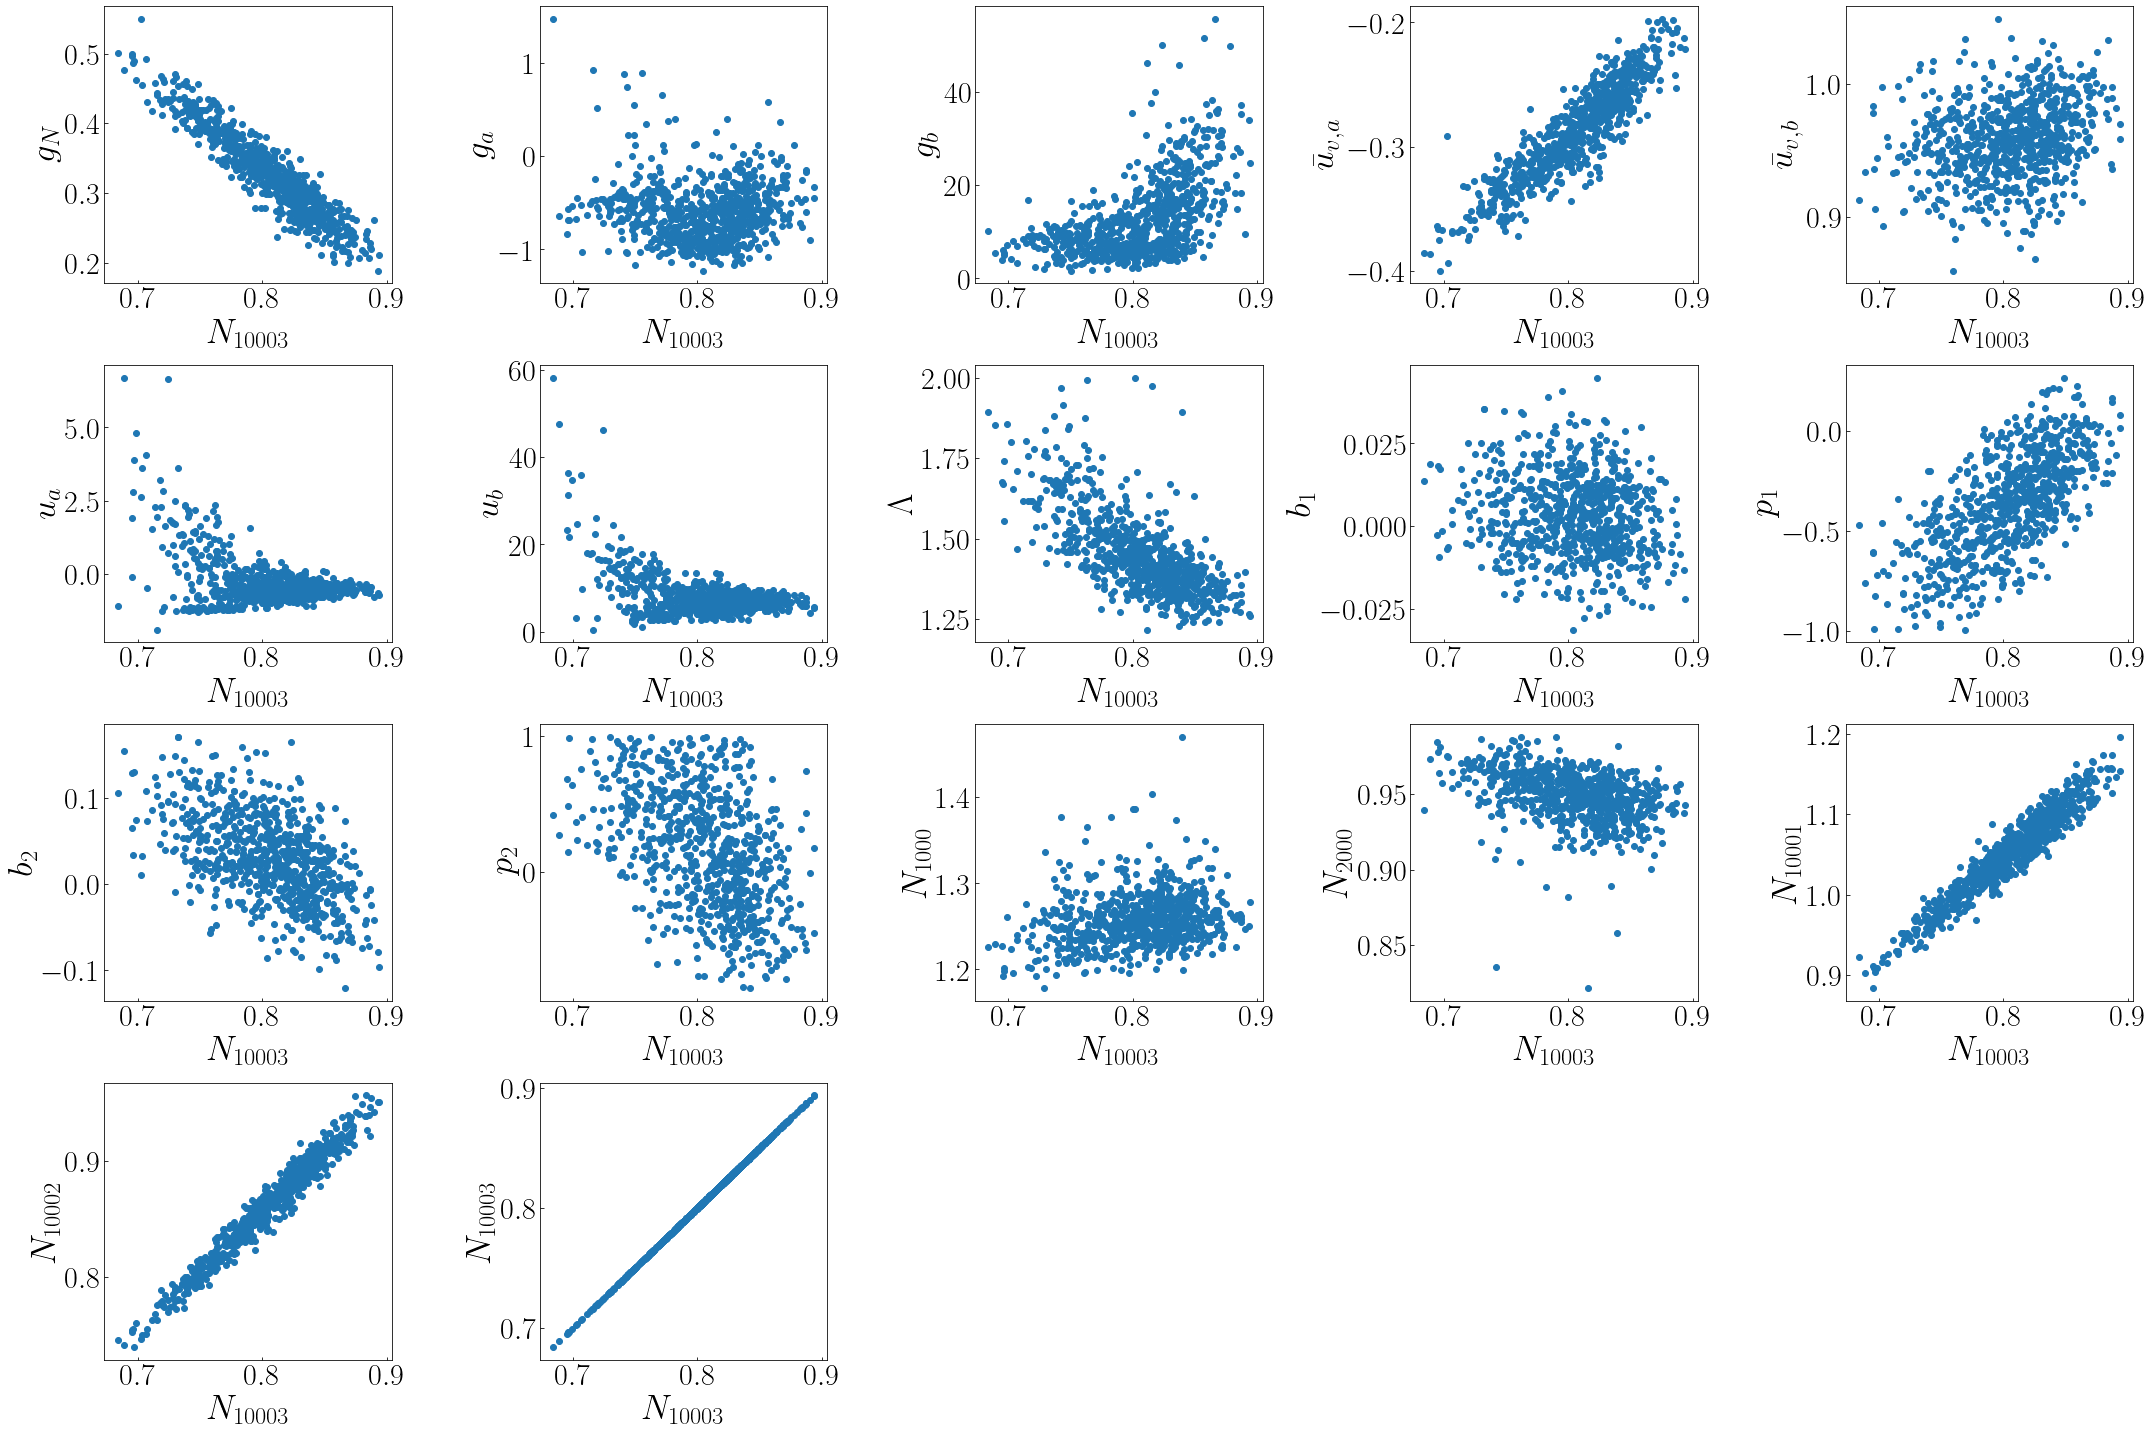

Process w0:
Process w1:
Process w0:
Process w0:
Process w1:
Process w1:
Process w1:
Process w0:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


In [24]:
plot_chi2(wdir,book1.red_chi2)
for k in [1001,1002]:
    plot_data_over_theory(wdir,book1.predictions,k)
    plot_data_and_theory(wdir,book1.predictions,k)
    plot_data_and_theory_sysnosys(wdir,book1.predictions,book1.predictions_nosys,k)
plot_histograms(wdir,book1.samples,'%s/input.npy'%wdir)
plot_correlations(wdir,book1.samples,'%s/input.npy'%wdir)
plot_systematics(wdir,book1.samples,book1.predictions,'%s/input.npy'%wdir)
plot_pdfs(wdir,nolattPDFs,nosysPDFs,book1.pdfs)
plot_pdfs_reps(wdir,nolattPDFs,nosysPDFs,book1.pdfs)
plot_pdfs_all(wdir,nolattPDFs,book1.pdfs)
plot_pdfs_all_reps(wdir,nolattPDFs,book1.pdfs)
par_2d_scatter(wdir,book1.samples,'%s/input.npy'%wdir)

In [61]:
wdir='analysis-LCS/pITD/B1B2P1P2F1F2-fromDYLN/'
book1=BOOK(wdir,'%s/input.npy'%wdir)

In [74]:
def plot_correlations_test(wdir,samples,inputfile,active_list=[]):
    load_config2(inputfile)
    set_active_params(active_list)
    conf['bootstrap'] = False
    resman=RESMAN(parallel=True,datasets=True)
    parman=resman.parman

    parmean=np.mean(samples,axis=0)
    
    cov=np.zeros((len(parmean),len(parmean)))
    for i in range(len(parmean)):
        for j in range(len(parmean)):
            for k in range(len(samples)):
                cov[i][j]+=(samples[k][i]-parmean[i])*(samples[k][j]-parmean[j])
    cov/=(len(samples)-1)
    
    correlation=np.zeros(cov.shape)
    for i in range(len(correlation)):
        for j in range(len(correlation[i])):
            correlation[i][j]=cov[i][j]/(cov[i][i]*cov[j][j])**0.5
            
    order=parman.order
    
    nrows,ncols=1,1
    py.figure(figsize=(13*ncols,10*nrows))
    ax=py.subplot(nrows,ncols,1)

    labs=[]
    for i in range(len(order)):
        if order[i][1]=='pdf-pion':
            parname=order[i][2][-1]
            if parname=='a': parname=r'\alpha'
            elif parname=='b': parname=r'\beta'
            if 'ubv' in order[i][2]:
                labs.append(r'$%s_{v}$'%parname)
            elif 'u' in order[i][2]:
                labs.append(r'$%s_{s}$'%parname)
            elif 'g' in order[i][2]:
                labs.append(r'$%s_{g}$'%parname)
        elif 'lambda'==order[i][2]:
            labs.append(r'$\Lambda$')
        elif 'lat-sys'==order[i][1]:
            parname=order[i][2][0]
            power=order[i][2][1]
            labs.append(r'$%s_{%s}$'%(parname,power))
        elif order[i][0]==2:
            expt=order[i][2]
            if expt==1000: expname='H1'
            elif expt==2000: expname='ZEUS'
            elif expt==10001: expname='E615'
            elif expt==10002: expname='NA10(1)'
            elif expt==10003: expname='NA10(2)'
            labs.append(r'$n_{\rm %s}$'%expname)
            
            
    lines=[]
    normflag=False
    for i in range(len(order)-1):
        if order[i][0]==1:
            if str(order[i][2]).split(' ')[0]!=str(order[i+1][2]).split(' ')[0]:
                if order[i][1]!='lat-sys':
                    lines.append(True)
                else: lines.append(False)
            else: lines.append(False)
        elif order[i][0]==2 and normflag==False:
            lines[-1]=True
            lines.append(False)
            normflag=True
        else: lines.append(False)
    lines.append(False)
            
    im=ax.imshow(correlation,cmap='Spectral')
    cbar = ax.figure.colorbar(im, ax=ax, ticks=[-1,-0.875,-0.75,-0.625,-.5,-0.375,-0.25,-0.125,0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1])
    im.set_clim(-1,1)
#     cbar.ax.set_yticks([-1,-0.875,-0.75,-0.625,-.5,-0.375,-0.25,-0.125,0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1])
    cbar.ax.set_yticklabels([r'$-1$',r'',r'$-0.75$',r'',r'$-0.5$',r'',r'$-0.25$',r'',r'$0$',r'',r'$0.25$',r'',r'$0.5$',r'',r'$0.75$',r'',r'$1$'])
    cbar.ax.tick_params(labelsize=20) 
    ax.set_xticks(range(len(order)))
    ax.set_xticklabels(labs)
    ax.set_yticks(range(len(order)))
    ax.set_yticklabels(labs)
    ax.tick_params(direction='out',which='both',axis='both',labelsize=26)
    py.setp(ax.get_xticklabels()[-5:],rotation=-45,ha='left',rotation_mode='anchor')
    for i in range(len(lines)):
        if lines[i]==True:
            ax.axhline(y=i+0.5,c='k')
            ax.axvline(x=i+0.5,c='k')

    
    py.tight_layout()            
    checkdir('%s/gallery'%wdir)
    py.savefig('%s/gallery/correlations.png'%wdir)
    py.savefig('%s/gallery/correlations.pdf'%wdir)


loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading pITD data sets 1001
loading pITD data sets 1002


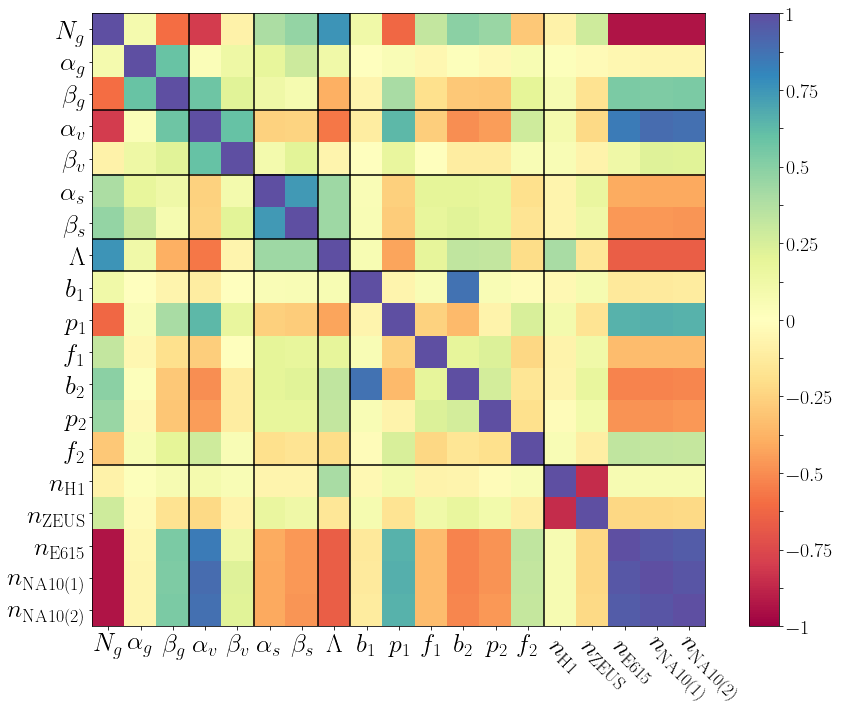

In [75]:
plot_correlations_test(wdir,book1.samples,'%s/input.npy'%wdir)